In [12]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis



In [10]:
radii = [20,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
stats_dict = {}
for i in tqdm(radii):
    params = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{i}.parquet')
    params = params.set_index('station_id')
    if params.empty:
        continue
    if 'FRTECH' in params.index:
        params = params[params.index!='FRTECH']

    to_remove = ['station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
    params = params.drop(to_remove, axis=1)
    scaler = StandardScaler()

    params_scaled = scaler.fit_transform(params)
    params_scaled = pd.DataFrame(params_scaled, columns=params.columns, index=params.index)
    params_scaled.columns.name = 'Parameter'
    # remove columns with more than 7 NaN values
    params_scaled = params_scaled.dropna(thresh=params_scaled.shape[0] - 7, axis=1)
    stats_dict[i] = params_scaled


  0%|          | 0/19 [00:00<?, ?it/s]/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
  5%|▌         | 1/19 [00:00<00:02,  7.90it/s]/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/li

In [11]:
stats_dict

{20: Parameter   BuAdj  BuIBD  BuAre_count  BuAre_mean  BuAre_median  BuAre_std  \
 station_id                                                                   
 FRGLBA        NaN    NaN    -0.816497   -0.578839     -0.326379  -1.300263   
 FRKART        NaN    NaN    -0.816497    1.615385      1.399125  -0.083265   
 FRLAND        0.0    NaN     1.632993   -1.027322     -1.361156   1.511919   
 FRSTUH        0.0    NaN     0.000000   -0.009224      0.288411  -0.128392   
 
 Parameter   BuAre_min  BuAre_max  BuAre_sum  BuAre_nunique  ...  StrSCl_sum  \
 station_id                                                  ...               
 FRGLBA      -0.112067  -1.460911  -1.154569      -0.816497  ...         NaN   
 FRKART       1.611777   0.896743  -0.504896      -0.816497  ...         0.0   
 FRLAND      -1.113894   0.953816   1.549155       1.632993  ...         NaN   
 FRSTUH      -0.385816  -0.389648   0.110309       0.000000  ...         NaN   
 
 Parameter   StrSCl_nunique  StrSCl_mo

In [20]:
# do a factor analysis of every variable in selected stats

radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
fa_scales={}

for i in tqdm(radii):
    X_scaled = stats_dict[i].dropna()

    # Step 2: Determine the number of factors (e.g., set manually or use eigenvalues)
    n_factors = 8  # Example: Choose 5 factors

    # Step 3: Perform Factor Analysis
    fa = FactorAnalysis(n_components=n_factors, random_state=0)
    fa.fit(X_scaled)

    # Step 4: Analyze Results
    factor_loadings = pd.DataFrame(fa.components_.T, index=X_scaled.columns, columns=[f"Factor {i+1}" for i in range(n_factors)])
    fa_scales[i] = factor_loadings

    # Plot top 5 factor loadings for each factor
    for i in range(n_factors):
        print(f"Top 5 factor loadings for Factor {i+1}")
        print(factor_loadings[f"Factor {i+1}"].abs().sort_values(ascending=False).head(5))
        print("\n")


 17%|█▋        | 3/18 [00:00<00:00, 19.44it/s]

Top 5 factor loadings for Factor 1
Parameter
BuAli_IQR         1.215959
BuFF_3D_sum       1.174068
StrAli_sum        1.157424
BuCCD_std_skew    1.152300
BuRough_3D_sum    1.134889
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
BuCon_3D_max    1.064785
BuCon_max       1.064785
BuRough_max     1.063863
BuEPI_3D_max    1.063625
BuERI_max       1.060220
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
BuSA_3D_std     1.131083
BuVol_3D_IQR    1.130467
BuSA_3D_IQR     1.121593
BuAre_IQR       1.114683
BuAre_std       1.108501
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuSWA_3D_min     1.000716
BuSWA_3D_mode    0.966182
BuSWA_3D_sum     0.892099
BuSWA_3D_mean    0.877421
BuHt_mode        0.842945
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
BuCor_IQR        0.840559
BuCor_MAD        0.798722
BuCor_std        0.779000
BuSurf_3D_IQR    0.731420
BuCorDev_min     0.70133

 28%|██▊       | 5/18 [00:00<00:00, 13.60it/s]

Top 5 factor loadings for Factor 1
Parameter
BuSWR_sum           1.079466
BuFF_sum            1.077907
BuSWA_3D_nunique    1.071246
BuFra_sum           1.066348
BuFra_3D_sum        1.052693
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
StrGam400_sum      1.066638
StrENR400_sum      1.059971
StrClo400_count    1.042407
StrSCl_count       1.042407
StrGam400_count    1.042407
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
BuFD_mean         0.730575
BuCon_mean        0.726187
BuCon_3D_mean     0.726185
BuCubo_3D_mean    0.681328
BuRec_mean        0.681288
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuCor_mean      0.805275
BuERI_MAD       0.775148
BuRough_mean    0.758170
BuCon_MAD       0.724843
BuCon_3D_MAD    0.724841
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
BuHt_std        0.792678
BuHt_IQR        0.776049
BuFF_3D_skew    0.775535
StrDeg_MAD      0.72915

 39%|███▉      | 7/18 [00:00<00:00, 11.11it/s]

Top 5 factor loadings for Factor 1
Parameter
BuFra_3D_sum         0.987054
BuFra_sum            0.983340
BuFF_sum             0.966686
BuFD_sum             0.960908
BuCubo_3D_nunique    0.955869
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
CyAre_nunique    1.071204
CyInd_nunique    1.071204
CyAre_mean       1.071204
CyAre_max        1.071204
CyAre_sum        1.071204
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
BuFD_max       0.878078
BuFD_std       0.840164
BuPerC_min     0.783016
BuPerC_mode    0.783016
BuSqu_mode     0.783016
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuRec_max         0.878774
BuCubo_3D_max     0.878696
BuSA_3D_skew      0.817530
BuCubo_3D_mean    0.795821
BuRec_mean        0.795761
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
BuDep_3D_IQR     0.884575
BuCube_3D_IQR    0.858297
BuCf_3D_IQR      0.858297
BuFF_3D_IQR      0.849967
BuHe

 50%|█████     | 9/18 [00:00<00:00,  9.76it/s]

Top 5 factor loadings for Factor 1
Parameter
BuFra_sum           0.952265
BuFra_3D_sum        0.950232
BuFF_sum            0.943362
BuFD_sum            0.934432
BuCorDev_nunique    0.921973
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
CyAre_sum     1.020706
CyInd_sum     1.020706
CyInd_max     1.020706
CyAre_max     1.020706
CyAre_mean    1.020706
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
BuFD_std      0.878963
BuPerC_std    0.814339
BuSqu_std     0.814339
BuDep_std     0.806599
BuSqu_min     0.785956
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuCubo_3D_max    0.880756
BuSWR_min        0.878916
BuSWR_mode       0.878916
BuFF_min         0.762624
BuFF_mode        0.762624
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
BuDisp_3D_skew    0.706372
BuCf_3D_IQR       0.694967
BuCube_3D_IQR     0.694967
BuHem_3D_IQR      0.680146
BuFF_3D_IQR       0.659542
Nam

 67%|██████▋   | 12/18 [00:01<00:00,  7.37it/s]

Top 5 factor loadings for Factor 1
Parameter
BuFra_sum           0.921347
BuFra_3D_sum        0.913756
BuCon_nunique       0.912037
BuFD_sum            0.911364
BuCCD_mean_count    0.901628
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
BuFR_mode     0.936828
BuFR_min      0.936828
BuAre_min     0.908024
BuAre_mode    0.908024
BuLAL_mode    0.908015
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
StrOpe_IQR       0.740832
BuEx_MAD         0.729439
StrHD_min        0.703509
StrHD_mode       0.703509
StrCyc400_IQR    0.702405
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuRan_mean      0.911427
BuShI_mean      0.911357
BuCCo_mean      0.897253
BuShI_median    0.896404
BuCCo_median    0.882893
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
StrLin_MAD        0.574165
BuRough_3D_MAD    0.543739
BuDep_3D_MAD      0.506304
BuOri_max         0.501974
BuFF_3D_IQR       0.

 83%|████████▎ | 15/18 [00:01<00:00,  8.29it/s]

Top 5 factor loadings for Factor 1
Parameter
BuSWR_sum         0.934198
BuFra_sum         0.931174
BuFra_3D_sum      0.923638
BuFD_sum          0.916561
BuCorDev_count    0.909898
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
BuAre_mode    0.964257
BuAre_min     0.964257
BuPer_min     0.951399
BuPer_mode    0.951399
BuLAL_mode    0.940421
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
StrCyc400_nunique    0.679199
StrOpe_IQR           0.664758
BuDisp_MAD           0.638206
StrOpe_nunique       0.621528
BuEx_IQR             0.621094
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuElo_mean    0.870313
BuShI_mean    0.855303
BuCCo_mean    0.852063
BuRan_mean    0.845641
BuSpi_mean    0.822204
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
CyAre_std      0.785833
CyAre_mean     0.772448
BuOri_max      0.760251
CyAre_sum      0.741108
BuSA_3D_max    0.723200
Name: Fa

100%|██████████| 18/18 [00:01<00:00,  9.21it/s]

Top 5 factor loadings for Factor 1
Parameter
BuElo_sum    0.925413
BuSqC_sum    0.925062
BuShI_sum    0.923389
BuERI_sum    0.923074
BuCCo_sum    0.922744
Name: Factor 1, dtype: float64


Top 5 factor loadings for Factor 2
Parameter
StrBet400_MAD        0.643530
StrBet400_IQR        0.639610
StrClo400_max        0.631305
StrCyc400_nunique    0.594461
StrClo400_std        0.593831
Name: Factor 2, dtype: float64


Top 5 factor loadings for Factor 3
Parameter
BuEPI_3D_max       0.592886
BuRough_3D_mode    0.548691
BpM_std            0.516670
BpM_max            0.515123
BuCCD_std_mode     0.512468
Name: Factor 3, dtype: float64


Top 5 factor loadings for Factor 4
Parameter
BuLAL_mode         1.076469
BuCCD_mean_mode    1.076035
BuPer_mode         1.075498
BuCWA_mode         1.075402
BuAre_mode         1.074703
Name: Factor 4, dtype: float64


Top 5 factor loadings for Factor 5
Parameter
BuRec_mean          0.855859
BuCubo_3D_mean      0.849553
BuRec_MAD           0.788640
BuSurf_3D_median

In [21]:
factor_loadings

Factor 1  Factor 2  Factor 3      Factor 4      Factor 5  \
Parameter                                                                
BuAdj        -0.660003 -0.234291  0.012216  1.126377e-01 -2.243727e-02   
BuIBD        -0.129262  0.001555 -0.005713 -2.743759e-03  5.953303e-02   
BuAre_count   0.899132 -0.041756  0.028696  4.336401e-09 -5.200216e-11   
BuAre_mean   -0.365321  0.269119 -0.062436 -1.026172e-01  8.281998e-01   
BuAre_median -0.336149  0.232829 -0.056657 -1.079346e-01  7.656352e-01   
...                ...       ...       ...           ...           ...   
StrSCl_skew  -0.221244 -0.236019  0.137432  7.782430e-02 -2.830857e-01   
SVF_mean     -0.204370  0.145768  0.132620 -7.338680e-03  9.594231e-02   
SVF_std      -0.091104 -0.041720 -0.001136  1.364177e-02 -1.647196e-02   
SVF_median   -0.258497  0.154567  0.132359  1.793647e-03  1.120561e-01   
SVF_IQR       0.104032 -0.119311 -0.005813  3.771755e-03  2.332725e-02   

                  Factor 6      Factor 7      Factor 8  
Parameter                                               
BuAdj        -5.574182e-02  1.437757e-01  2.059209e-01  
BuIBD         2.439490e-03  2.278461e-02  1.575207e-02  
BuAre_count  -9.865917e-11 -3.564538e-11  1.207652e-09  
BuAre_mean   -1.595829e-02  1.431214e-01 -1.451649e-02  
BuAre_median -1.960856e-01  2.371428e-01  4.907105e-02  
...                    ...           ...           ...  
StrSCl_skew   2.174798e-01  1.808566e-01  2.530168e-01  
SVF_mean      4.272151e-01  1.317947e-01 -1.215801e-03  
SVF_std      -2.014776e-01  9.021599e-02  5.488490e-02  
SVF_median    4.243734e-01  1.853380e-01  3.516925e-03  
SVF_IQR      -3.150155e-01  1.913447e-02 -2.713285e-02  

[793 rows x 8 columns]

In [16]:
# for each radii, get the top 5 factor loadings for each factor

radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
top5_factors = {}
for i in radii:
    top5_factors[i] = fa_scales[i].abs().sort_values(by='Factor 1', ascending=False).head(5)
    

Index(['FRGART', 'FRGLBA', 'FRGUNT', 'FRKART', 'FRLAND', 'FROWIE', 'FRSTUH',
       'FRWSEE'],
      dtype='object', name='station_id')

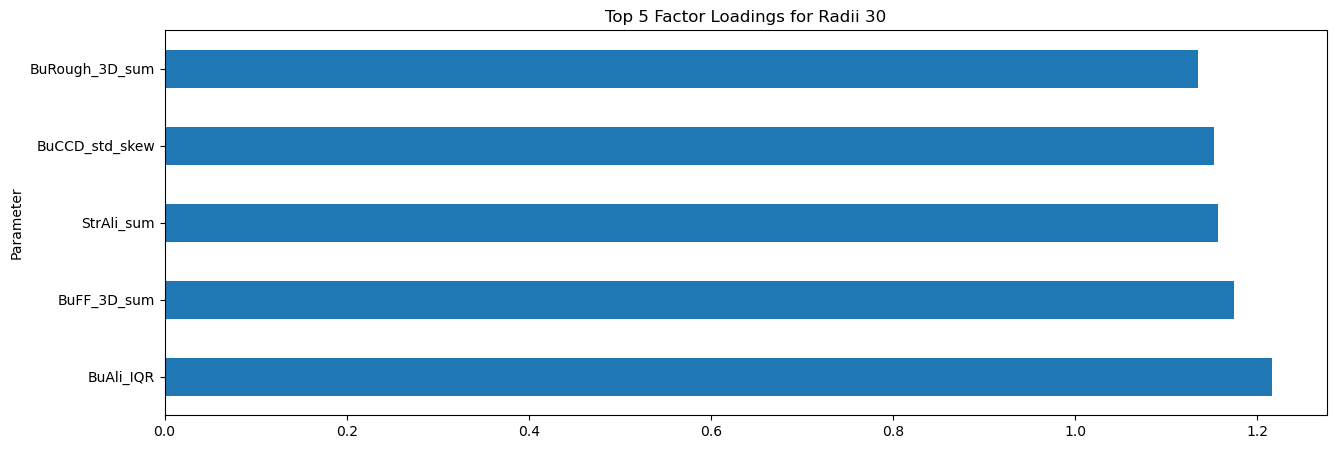

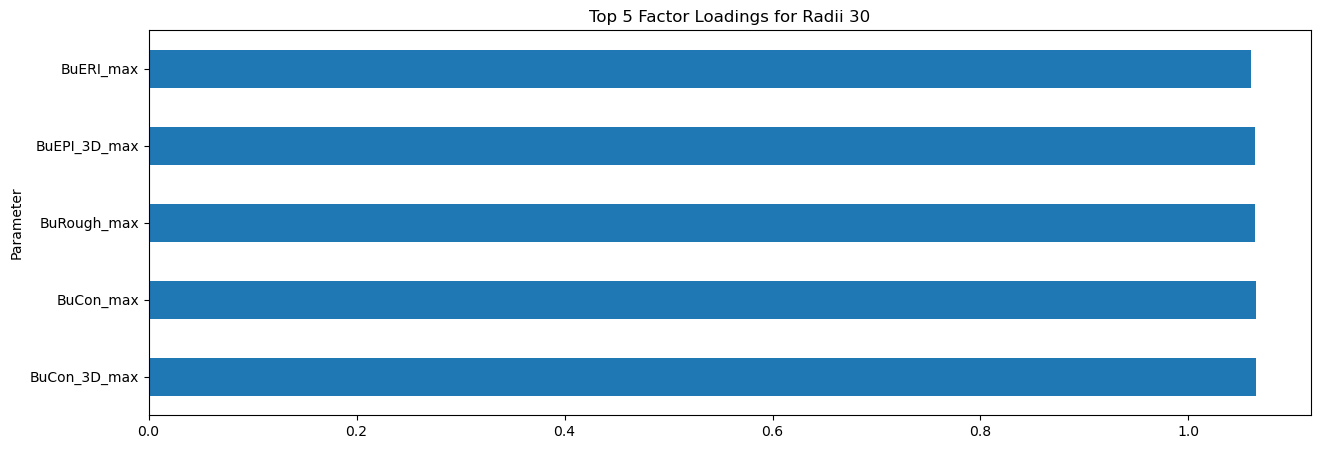

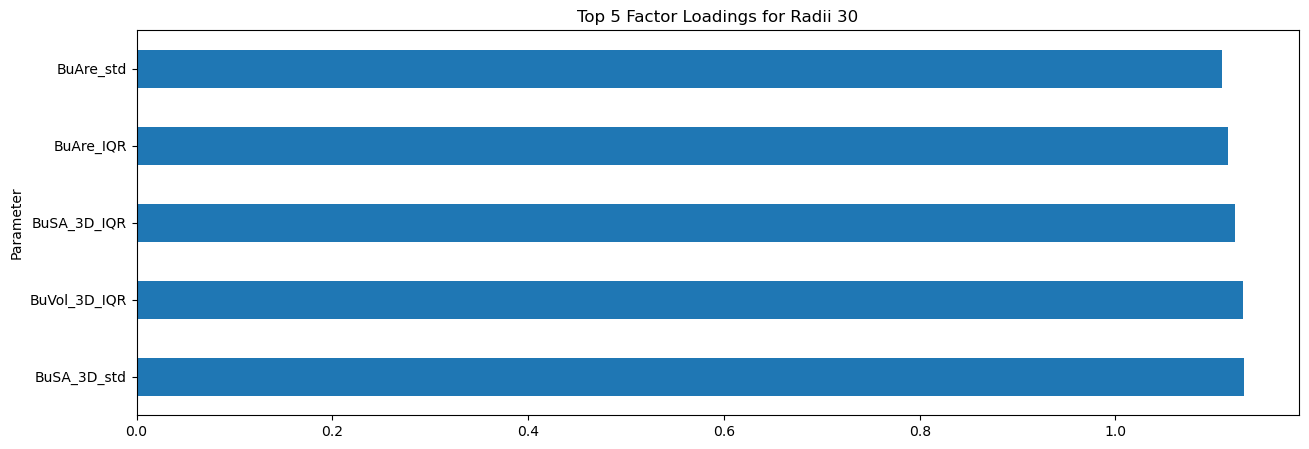

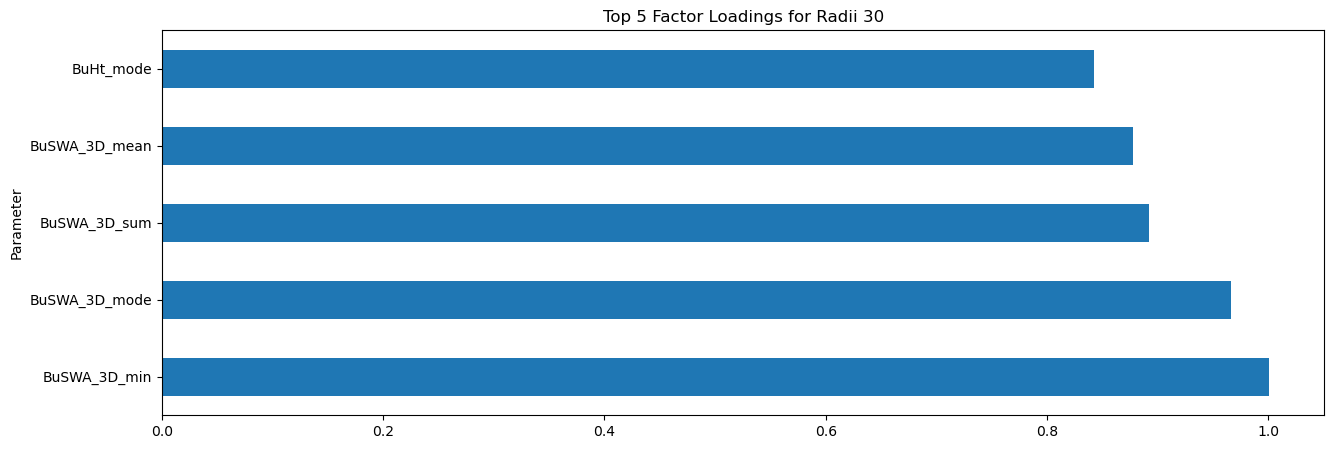

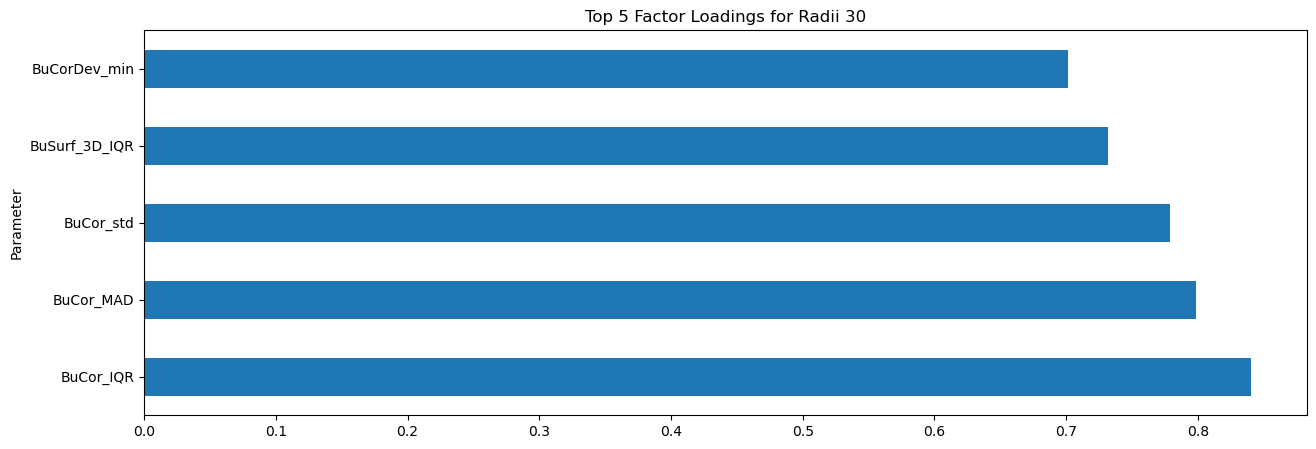

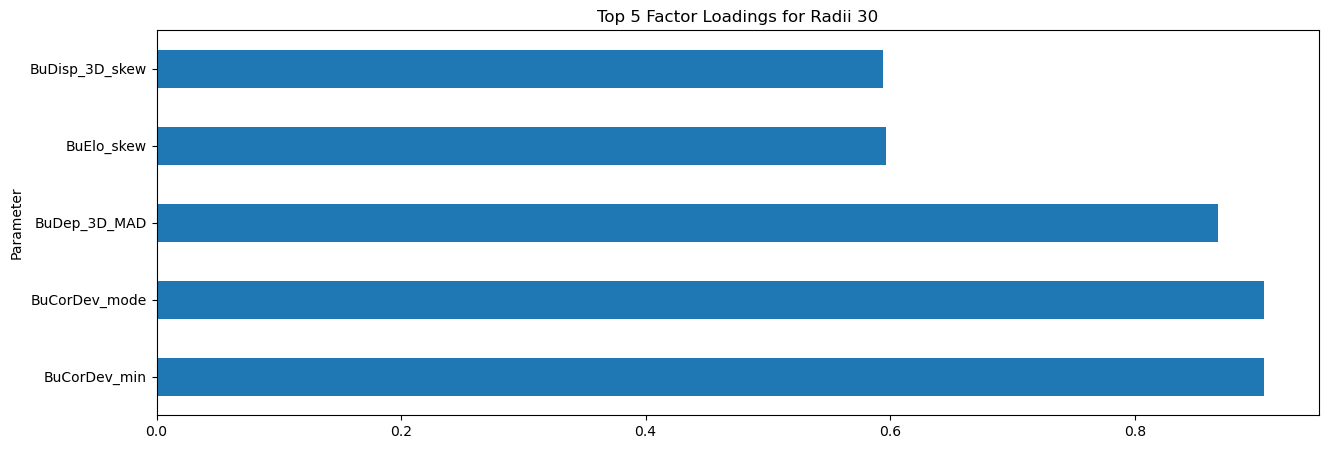

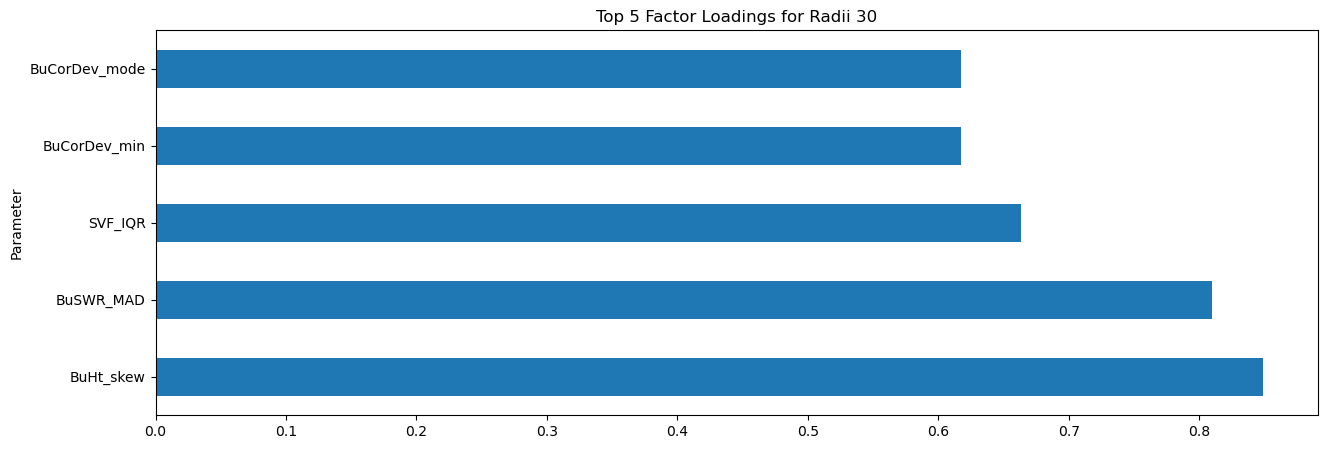

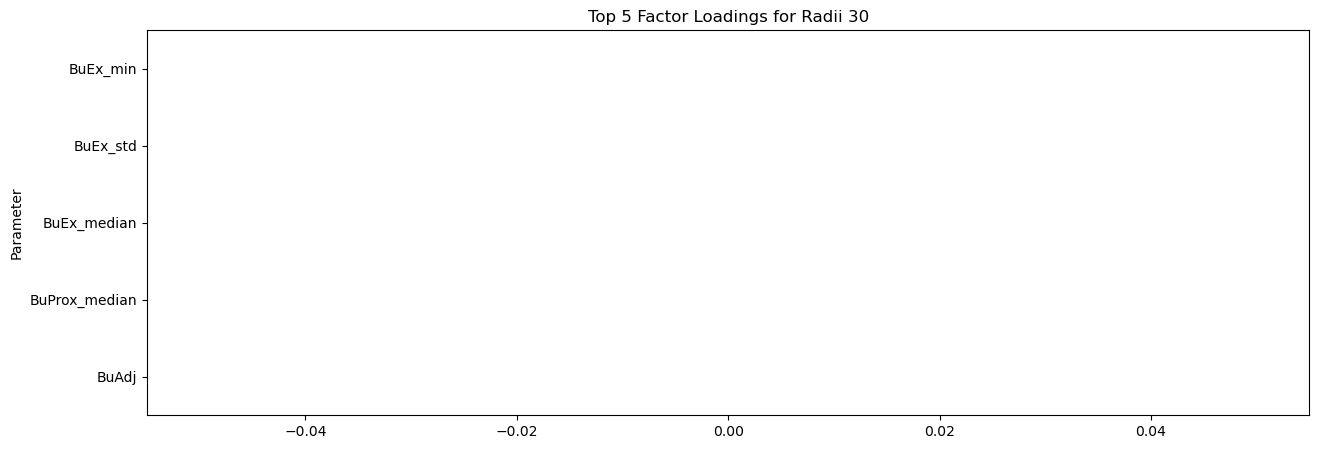

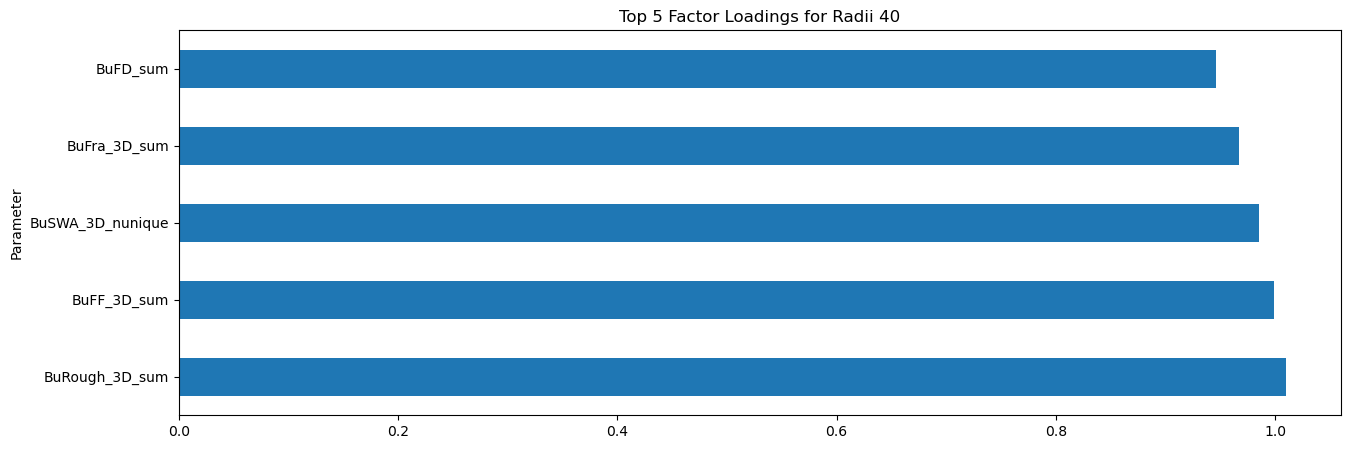

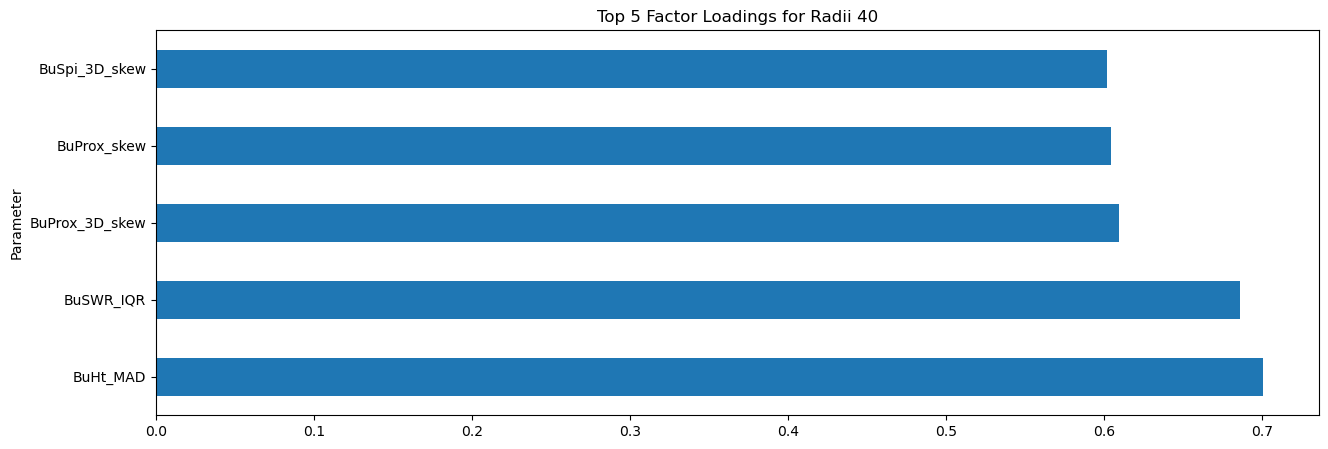

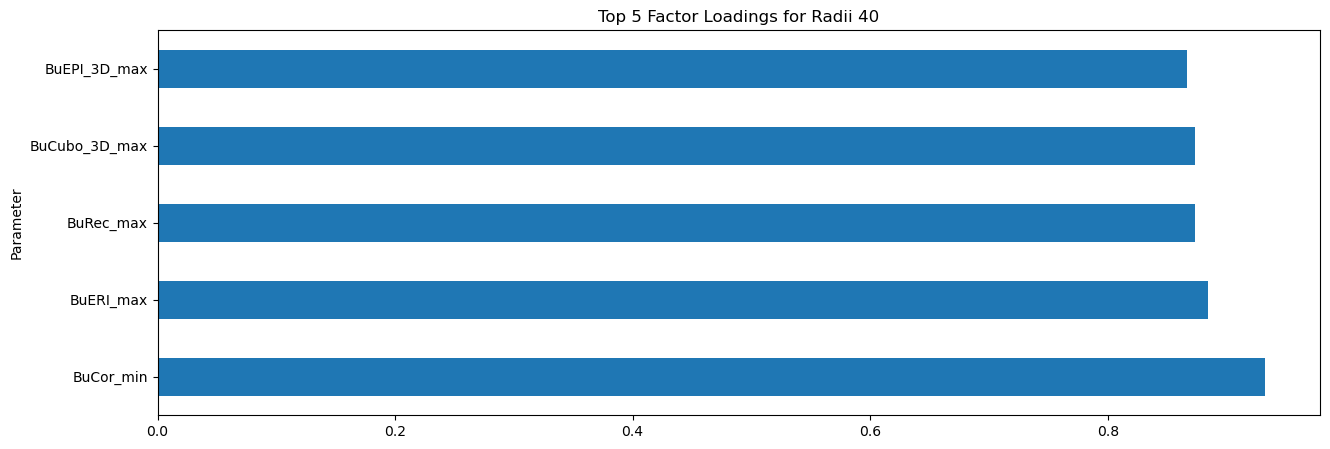

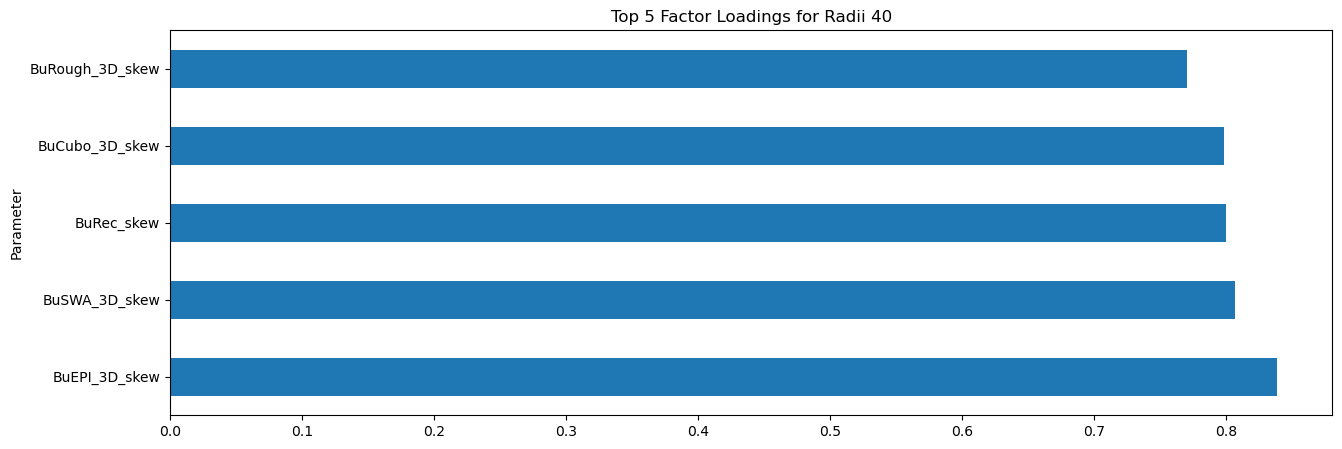

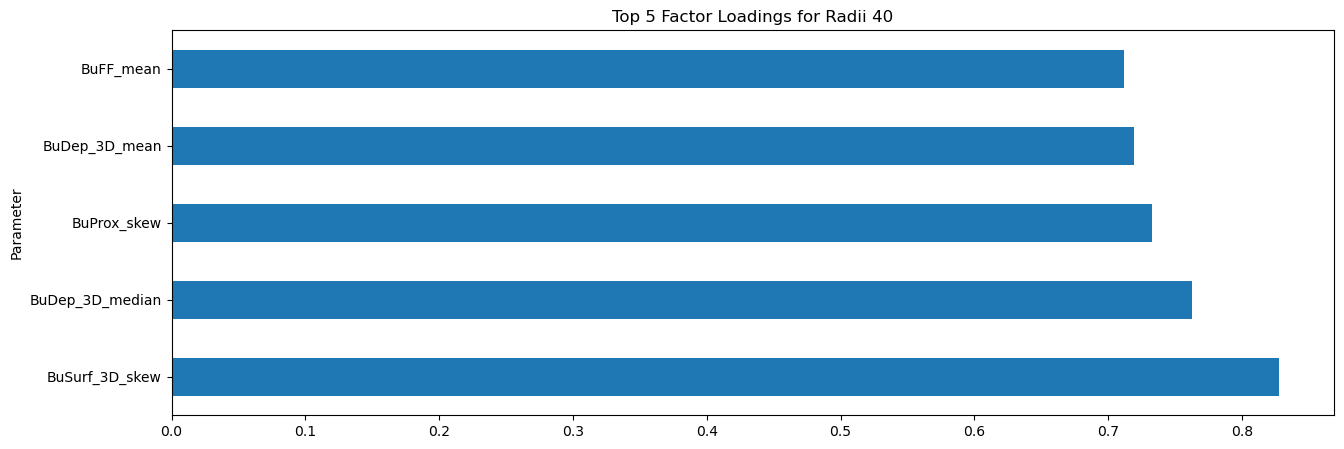

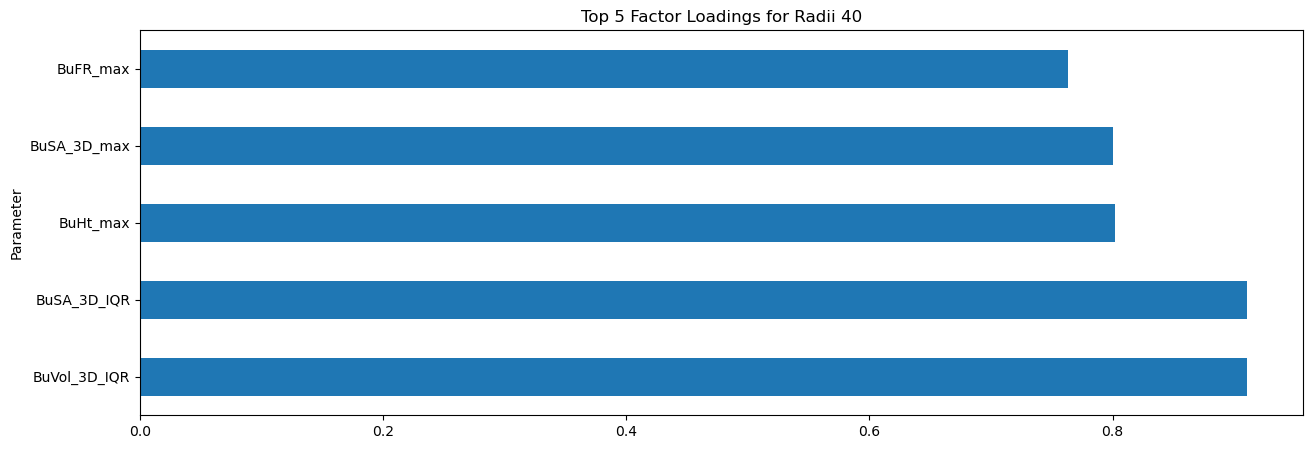

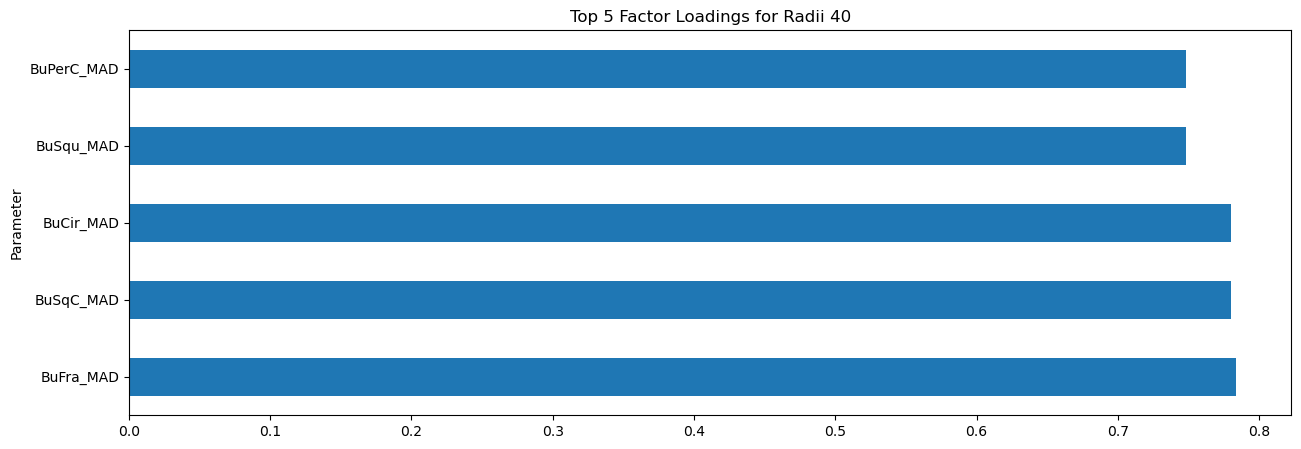

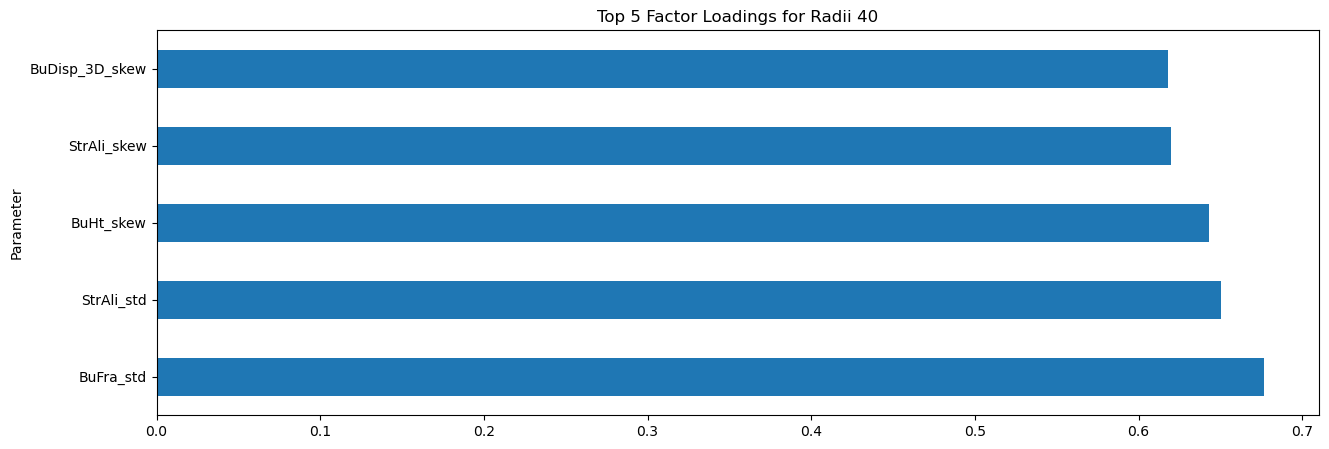

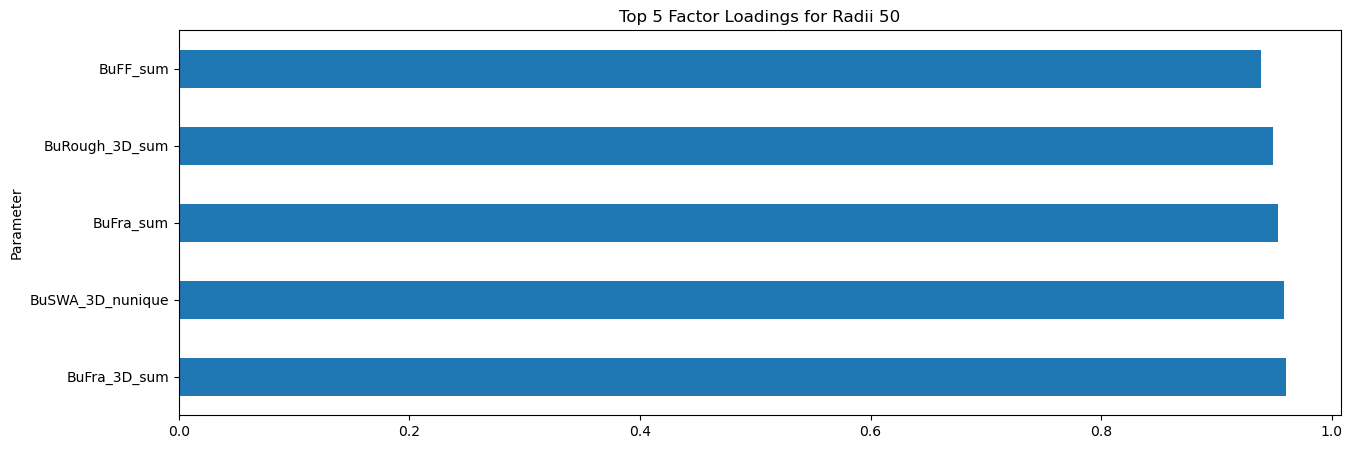

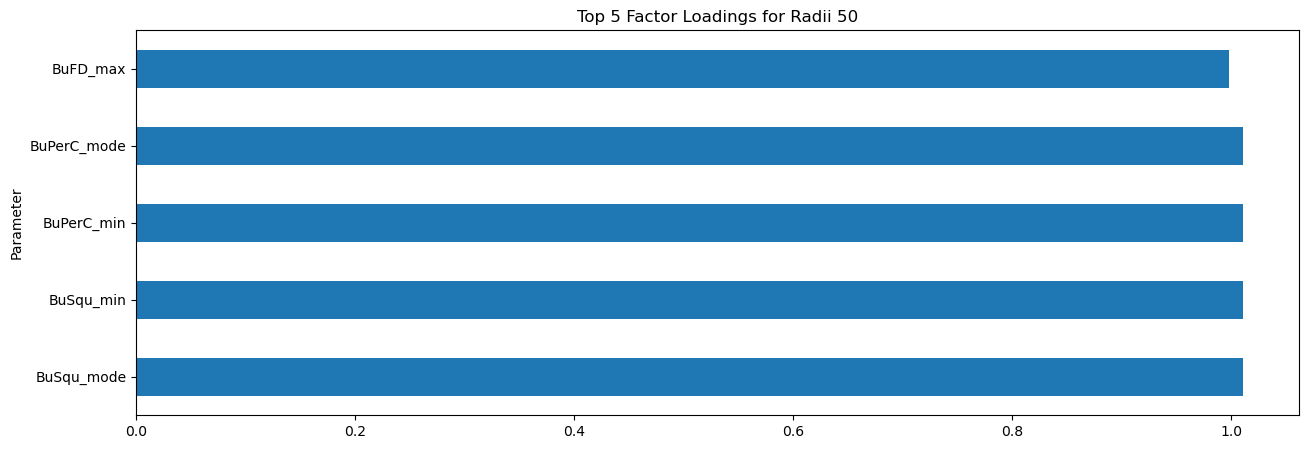

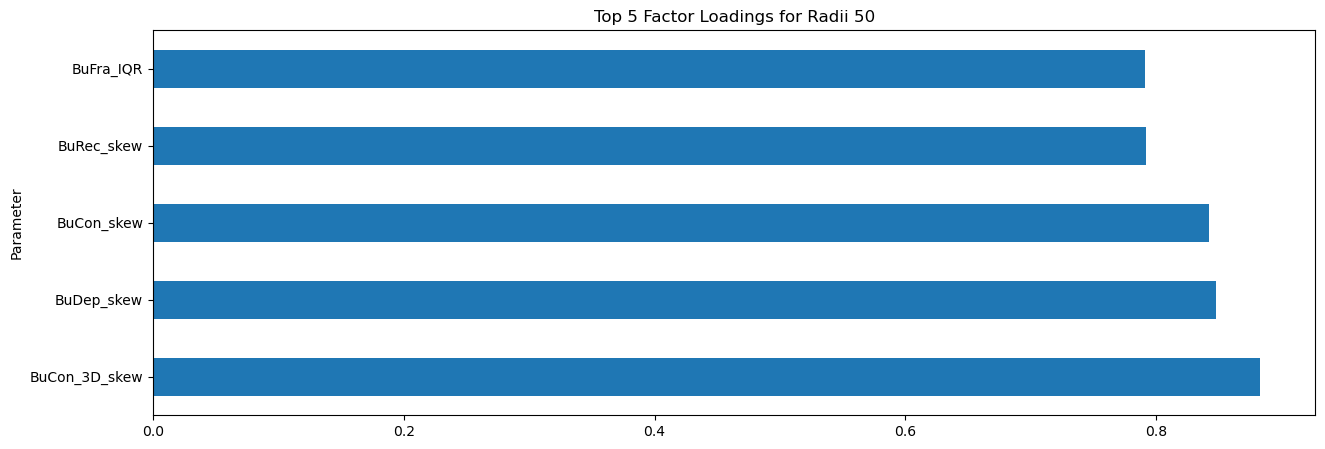

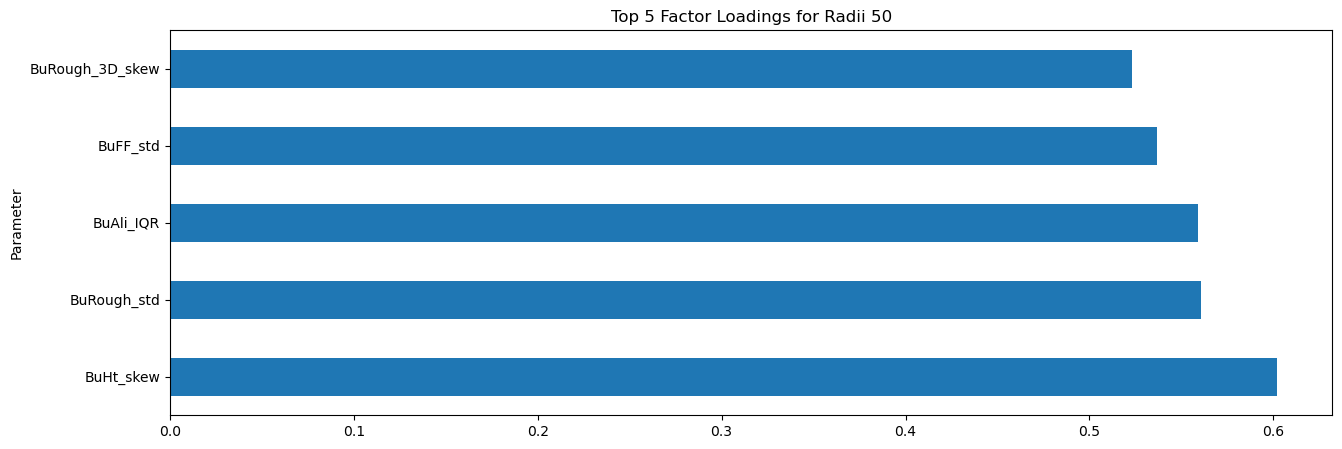

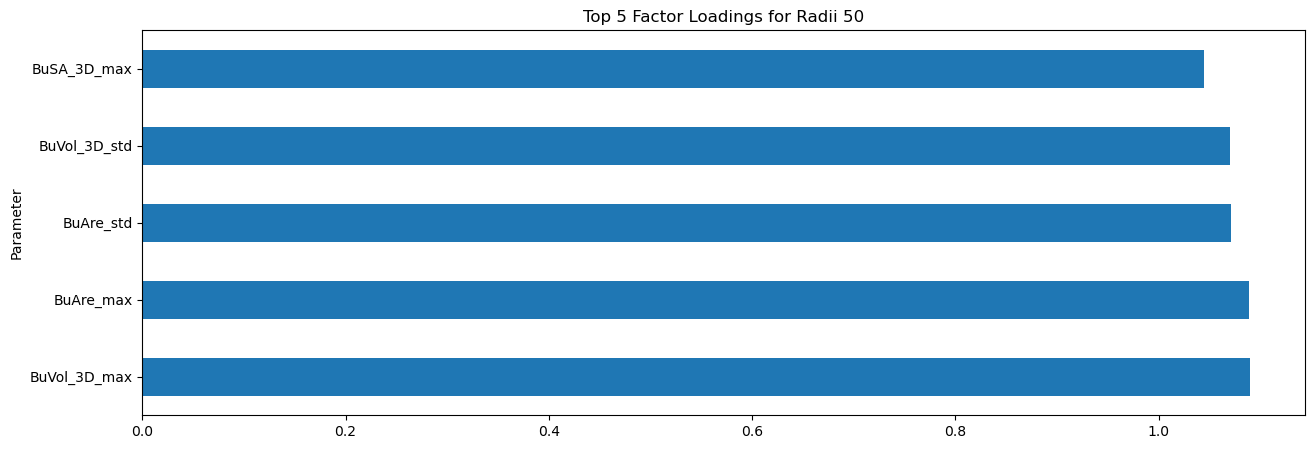

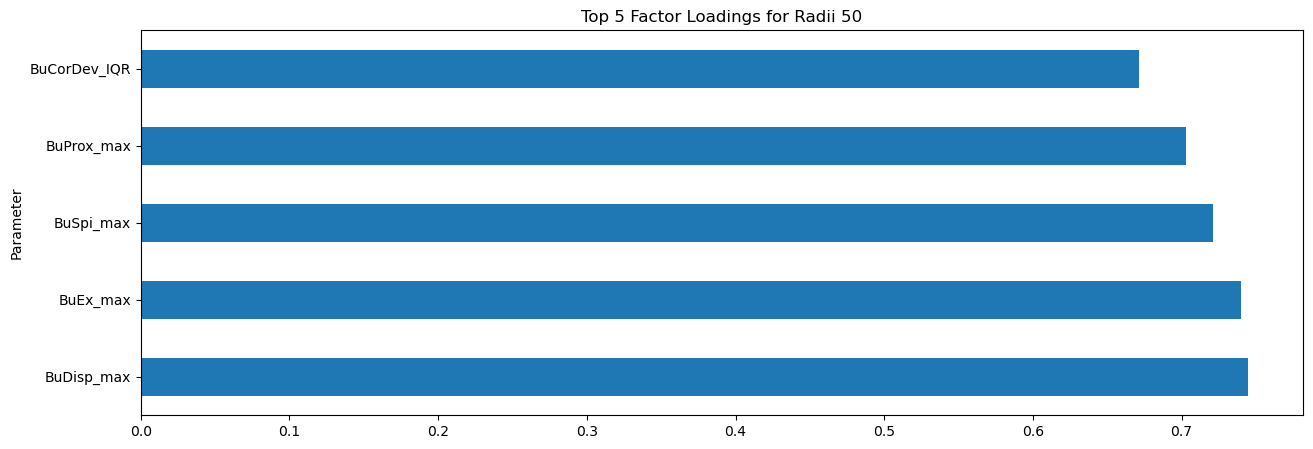

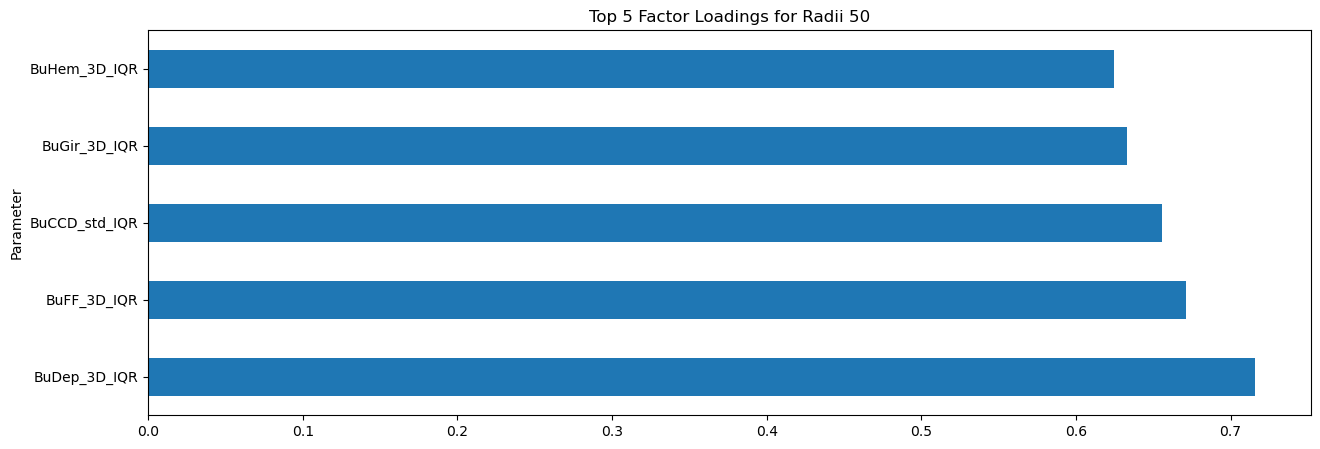

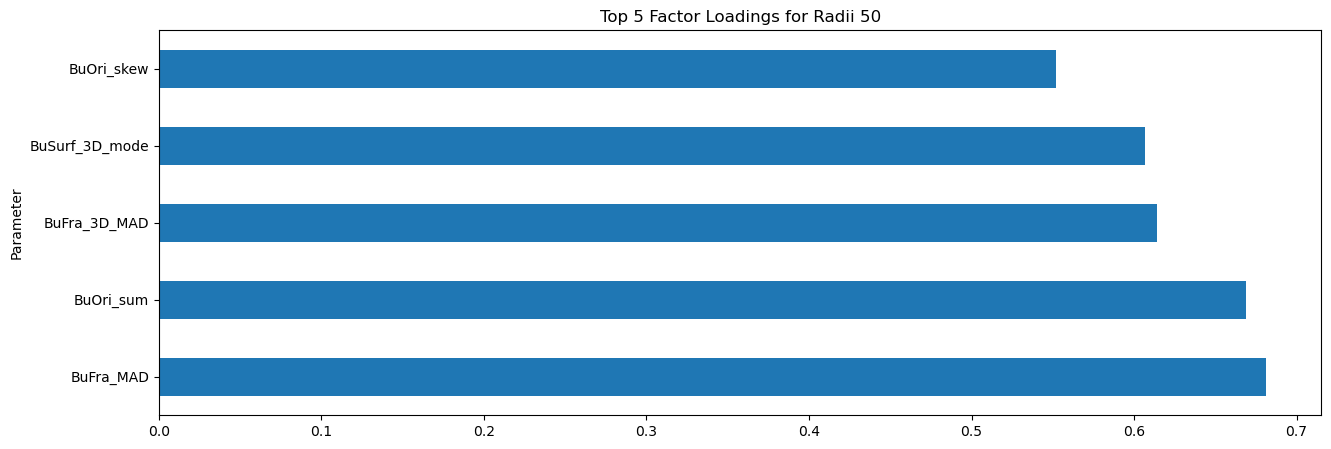

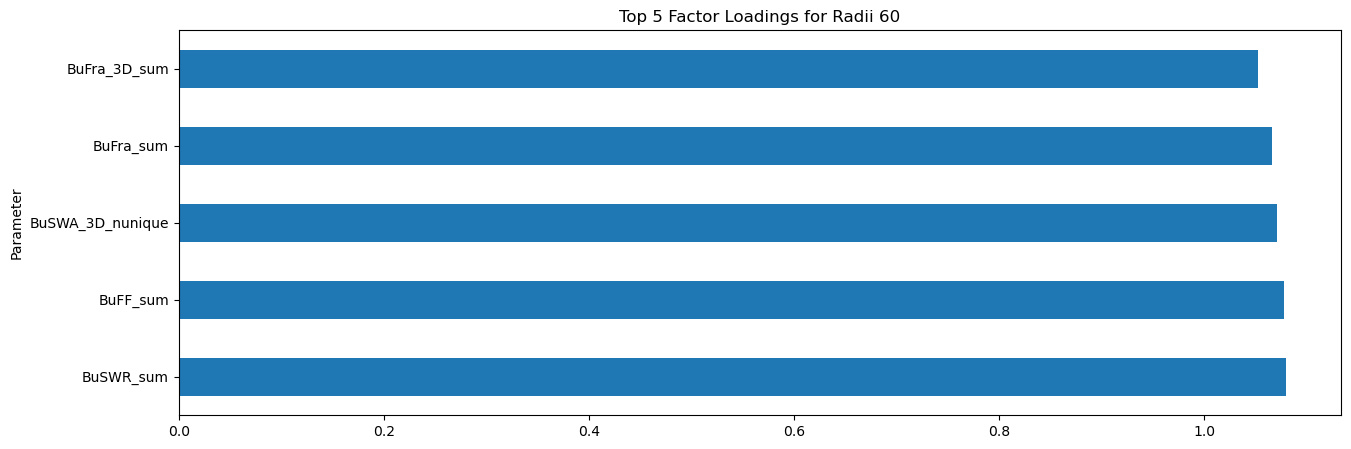

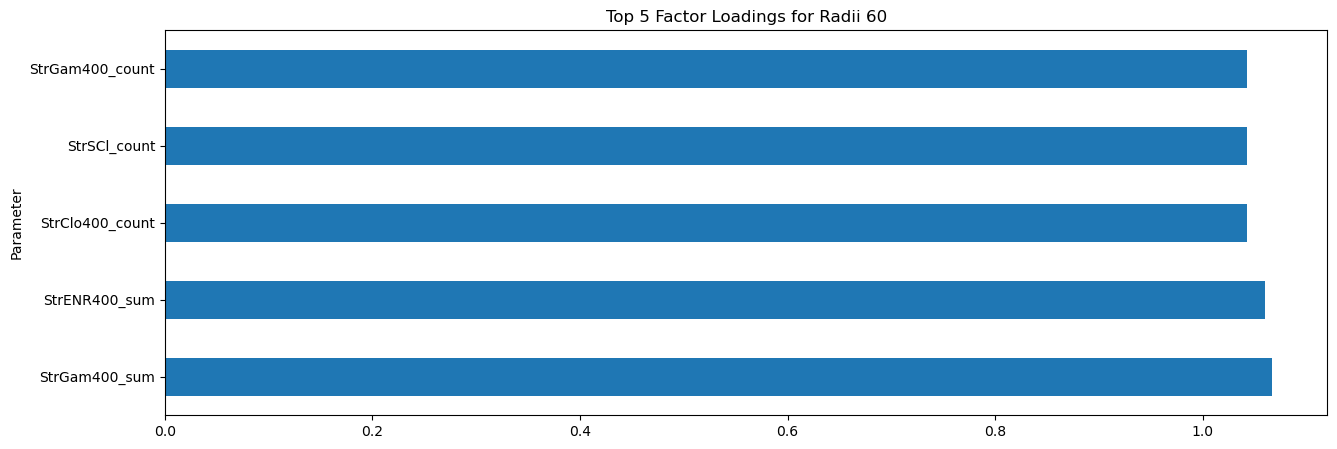

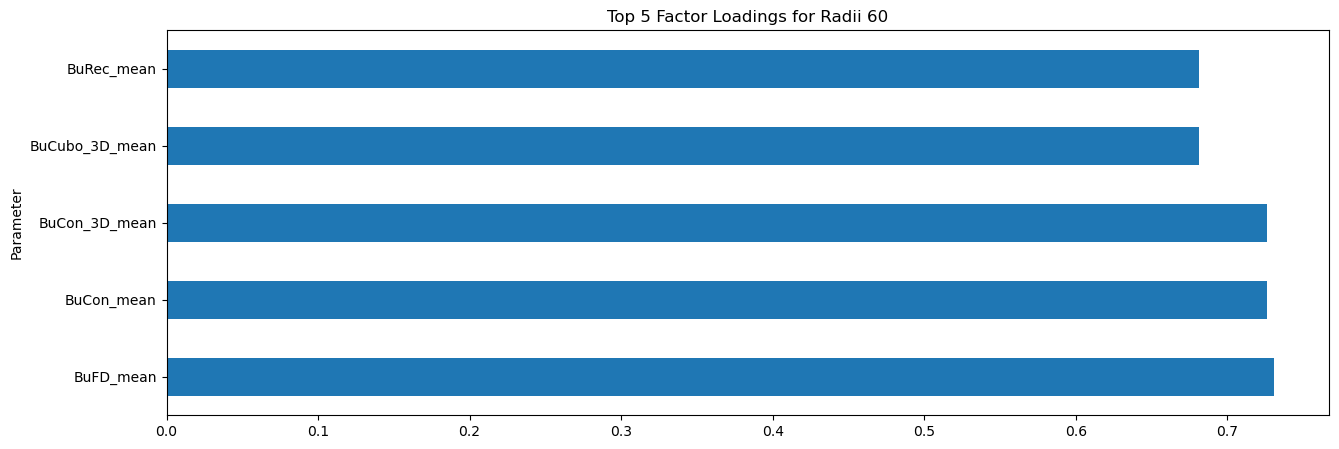

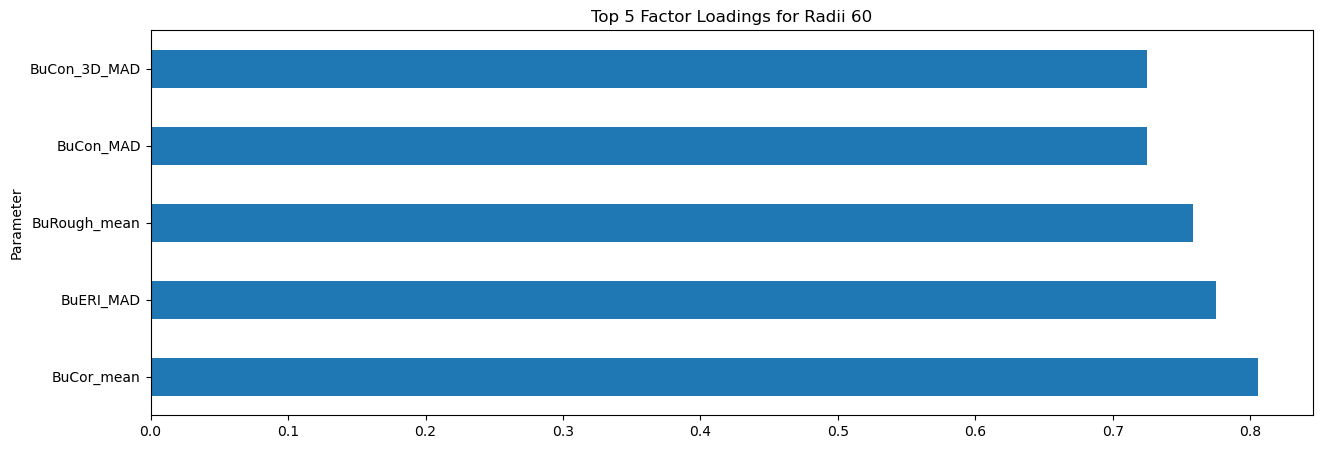

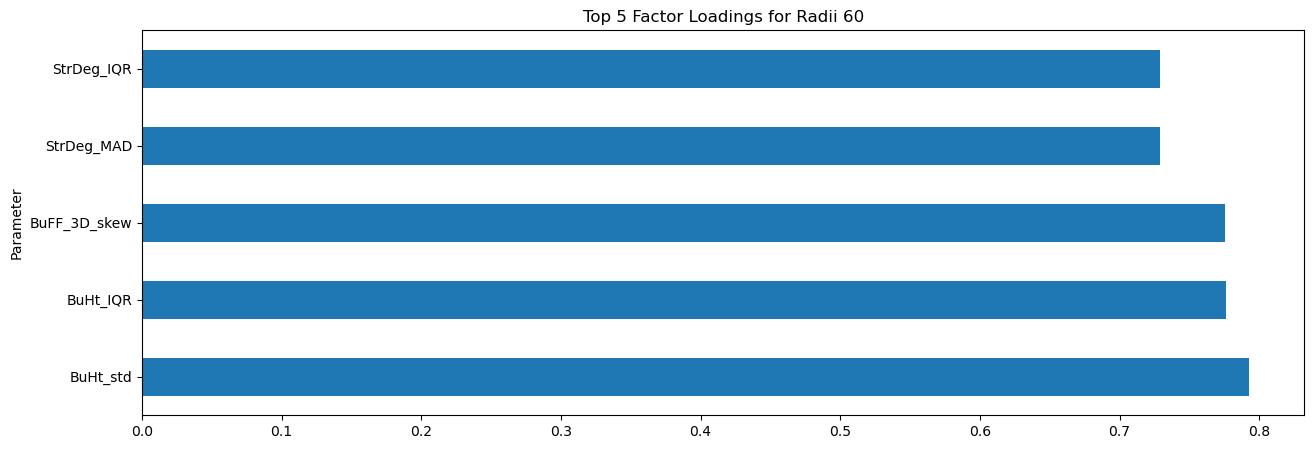

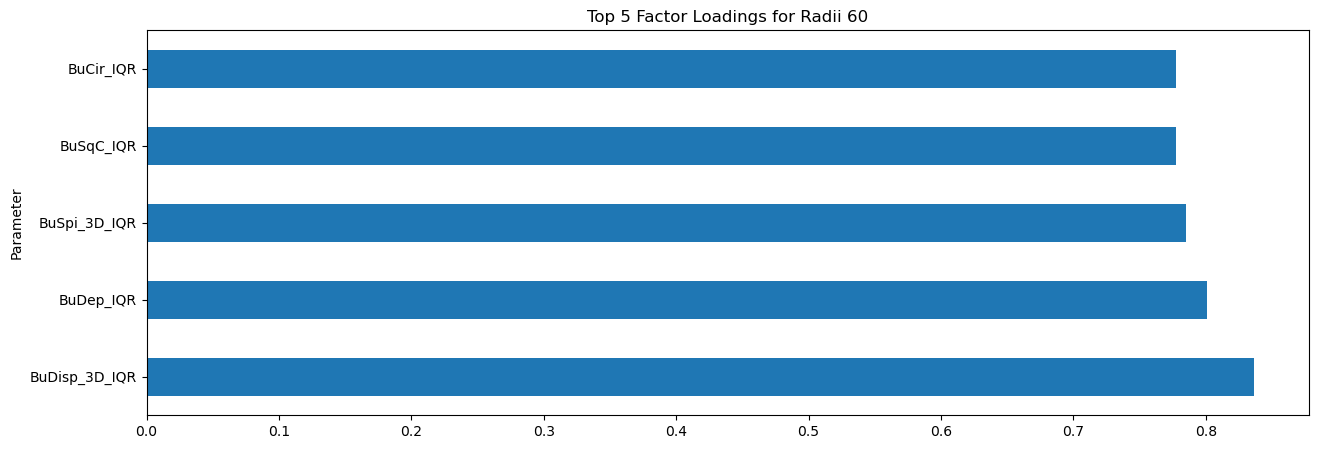

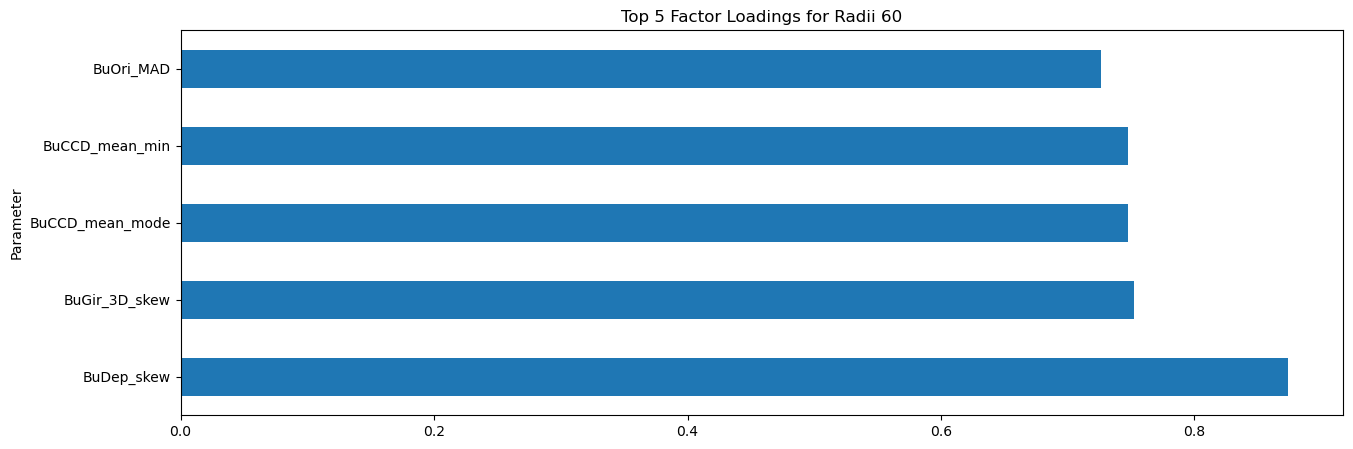

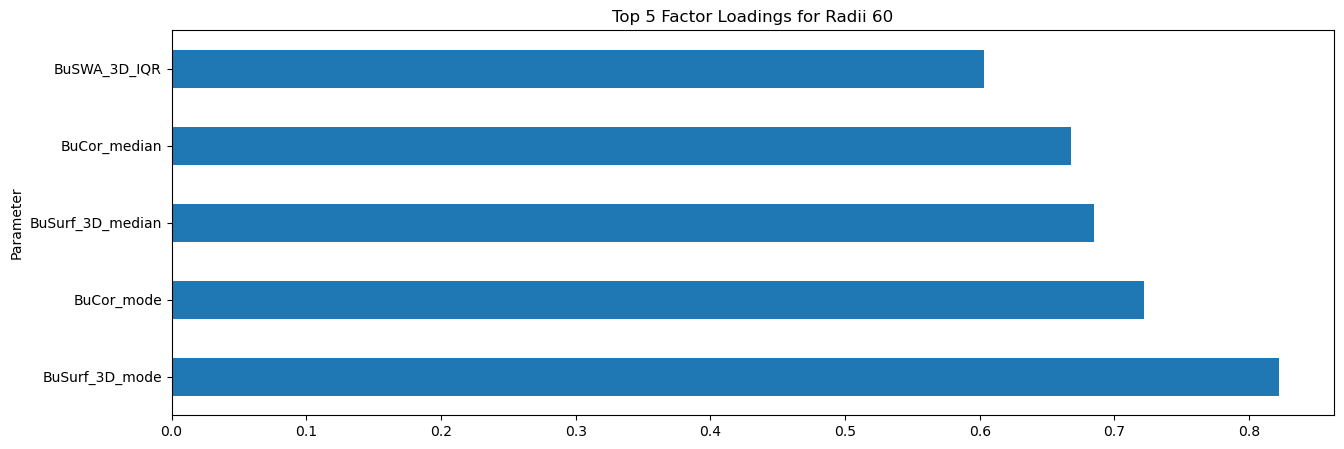

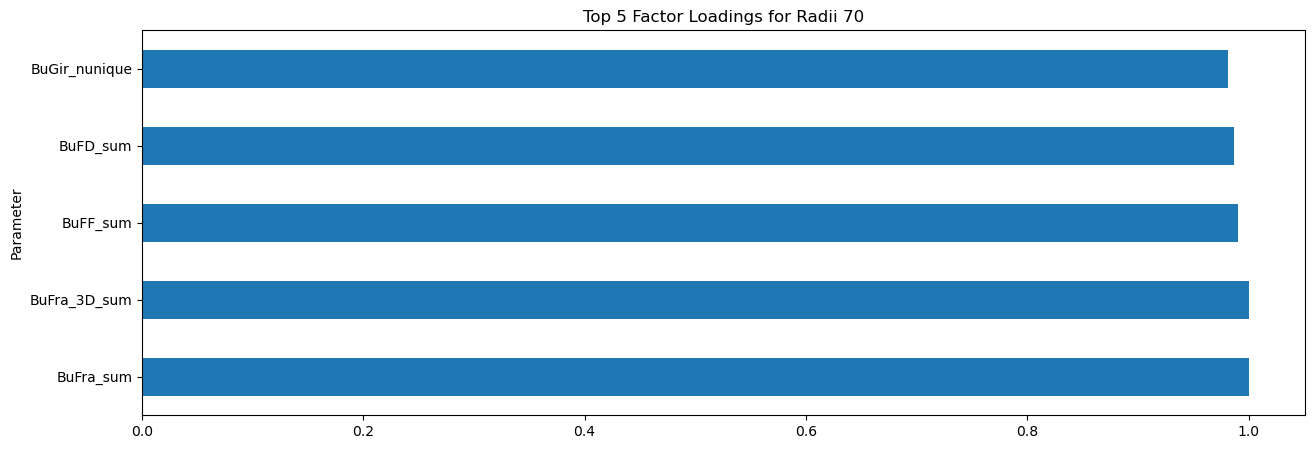

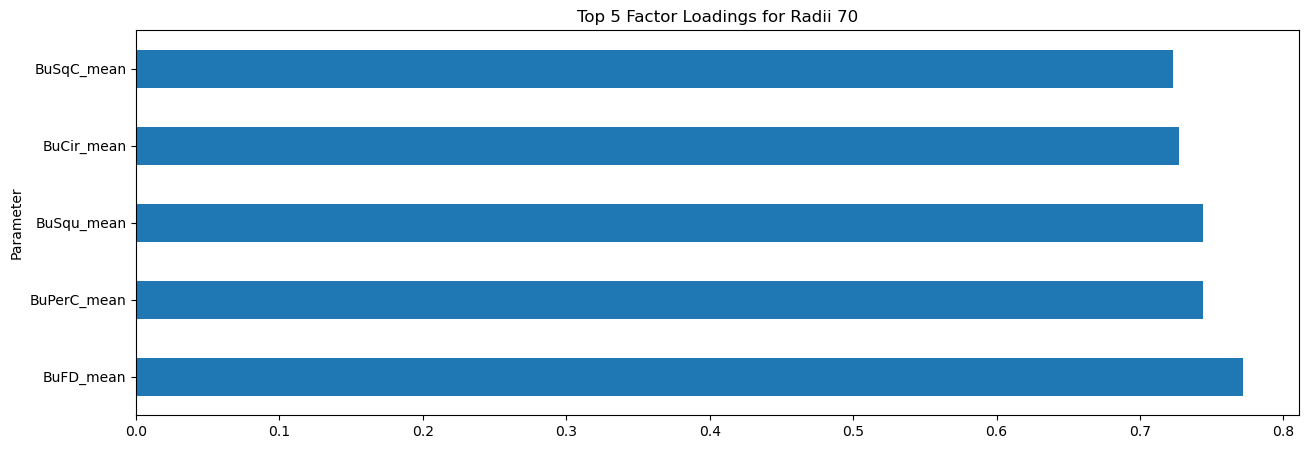

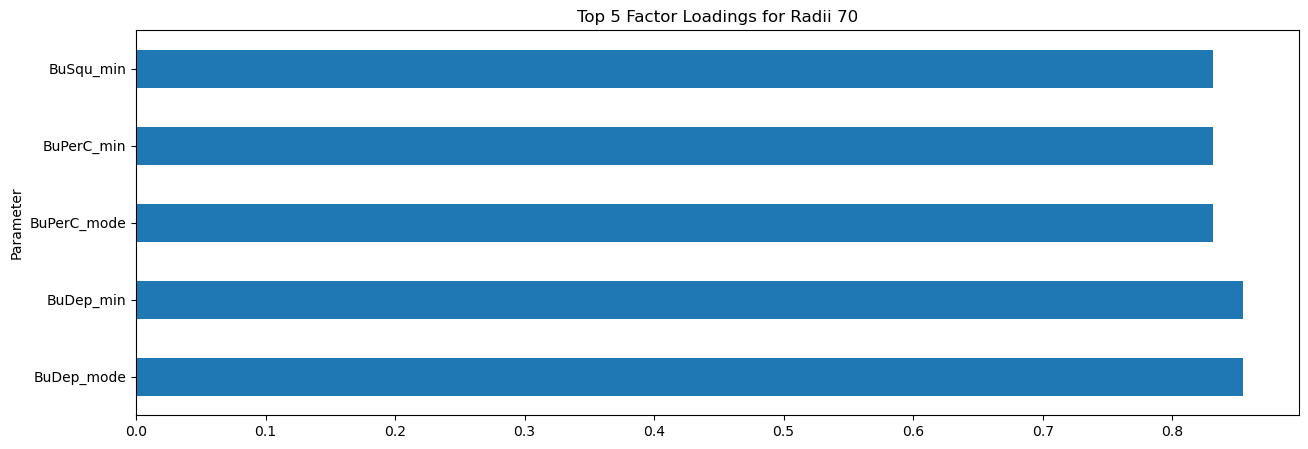

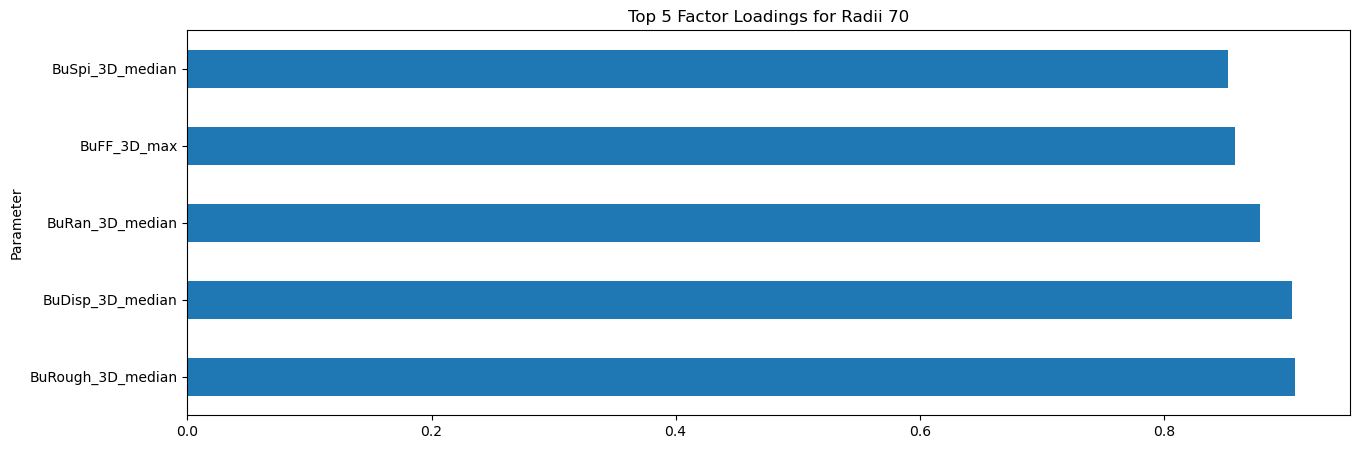

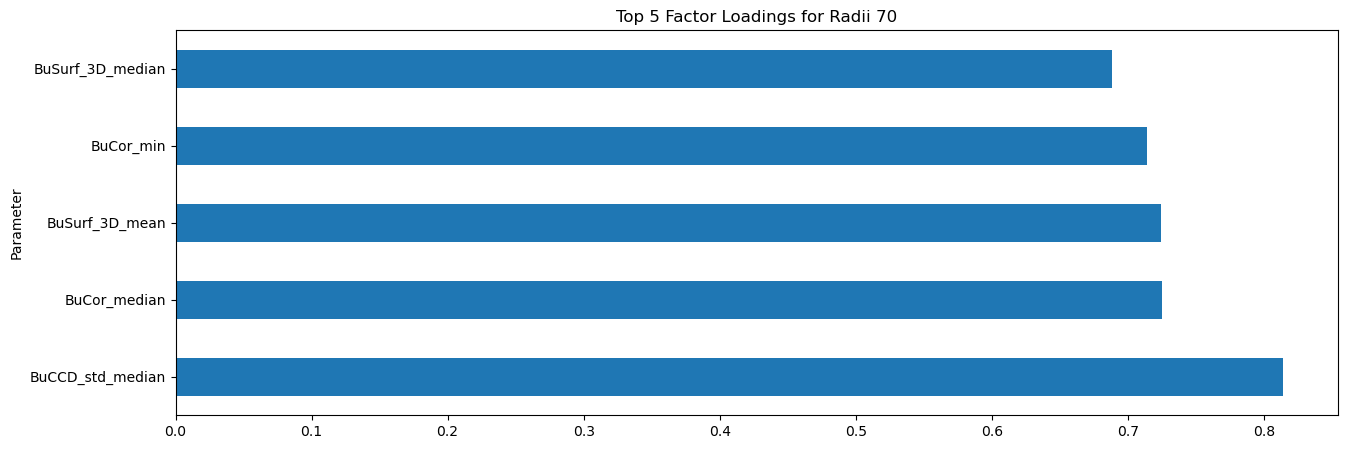

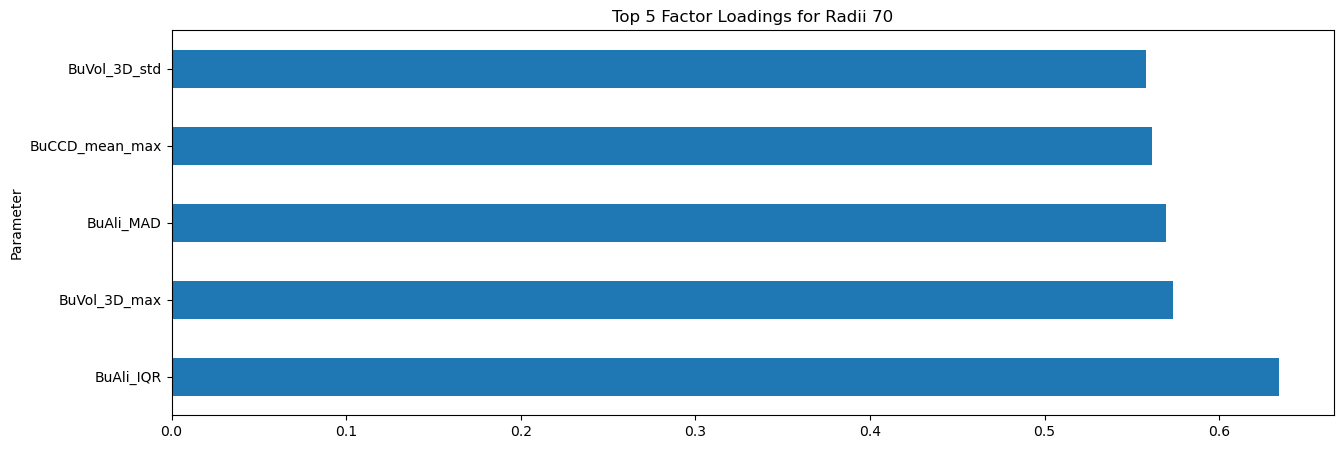

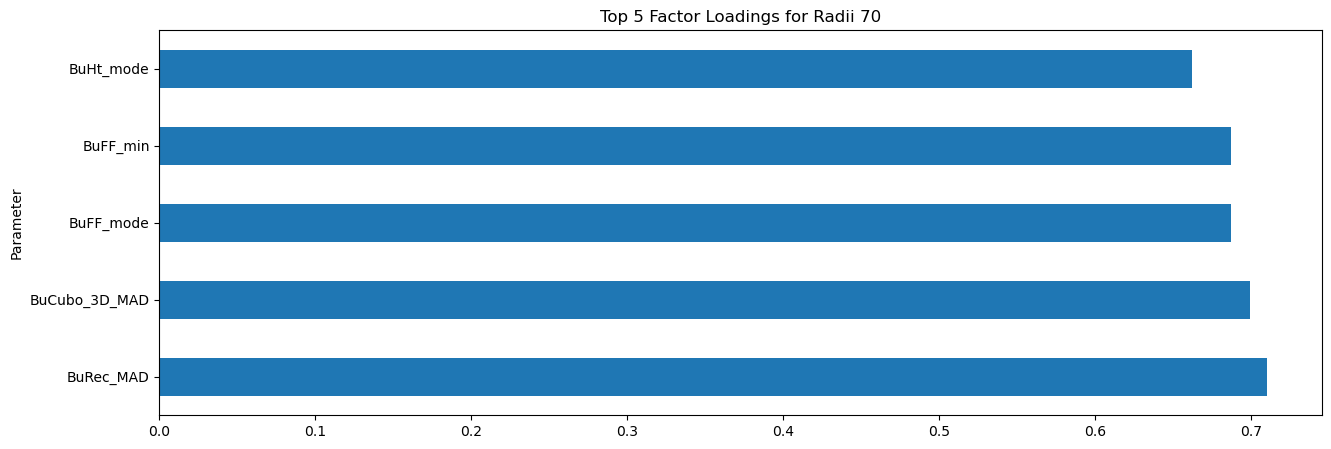

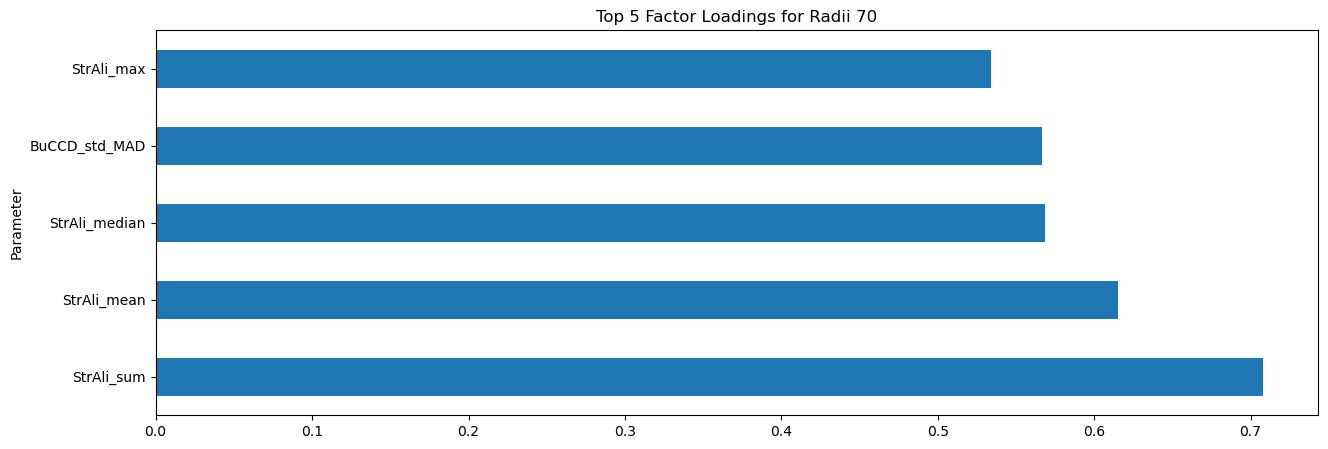

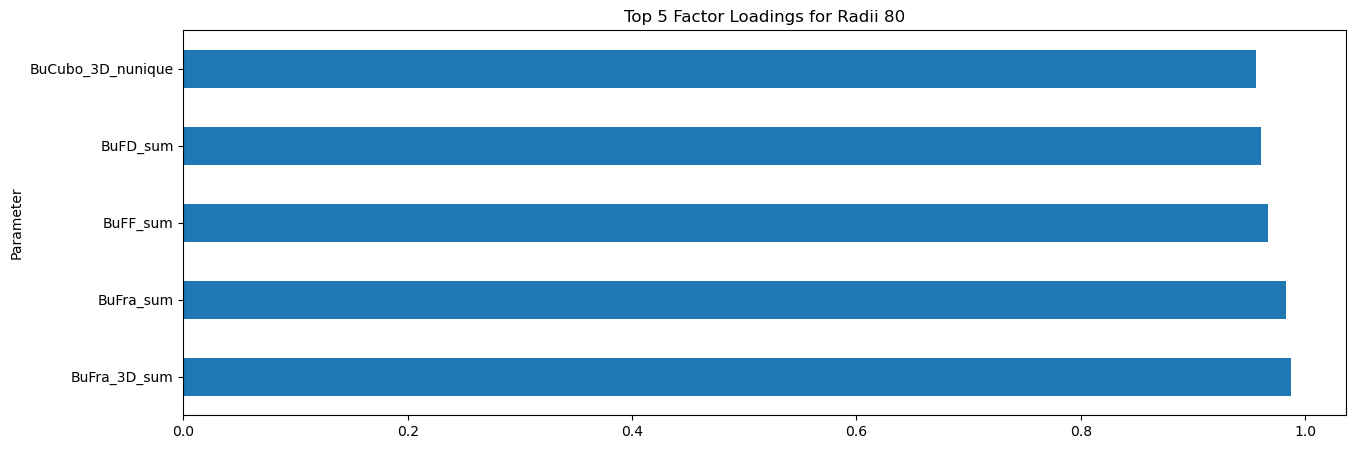

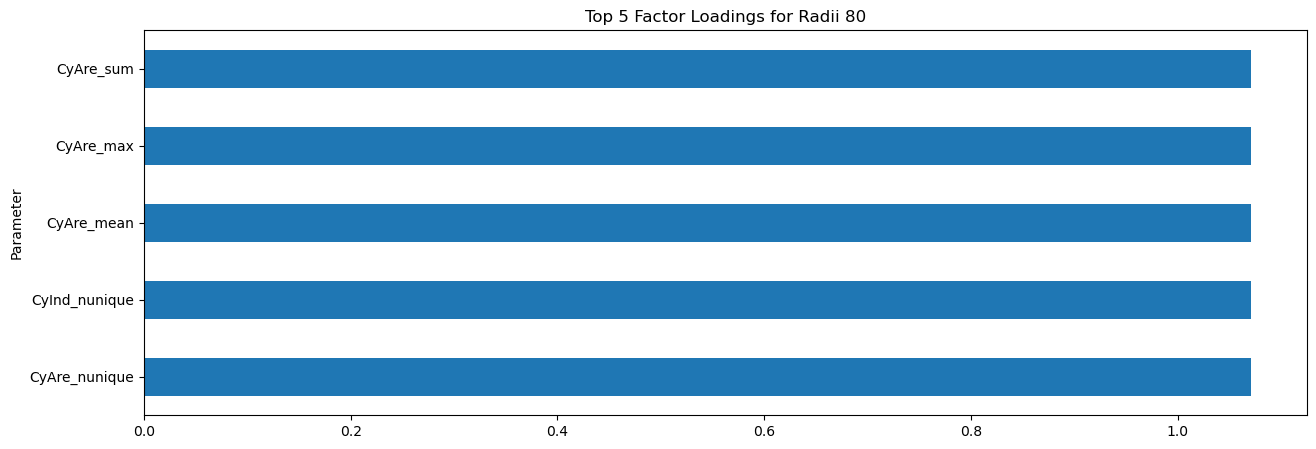

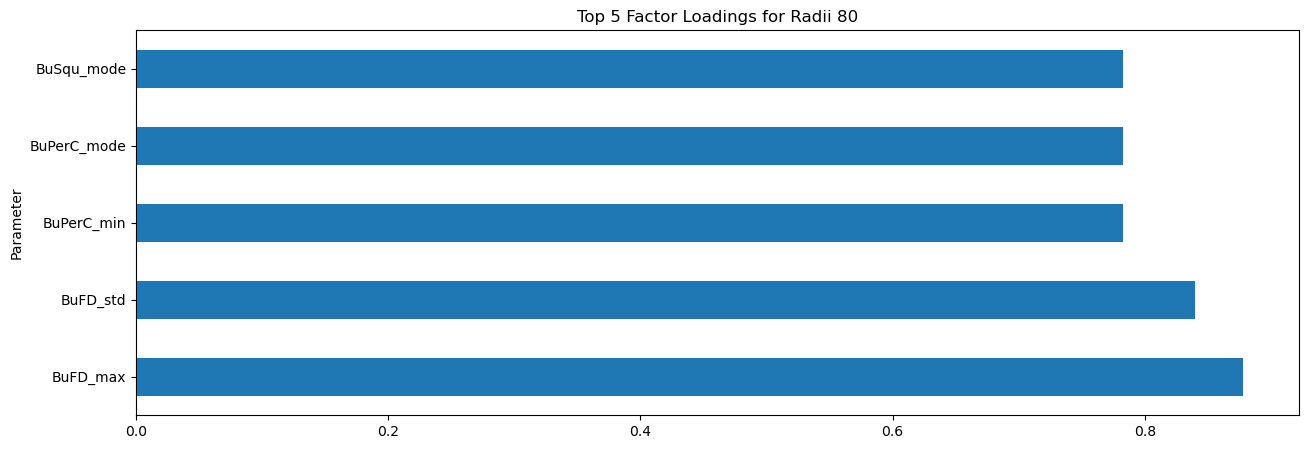

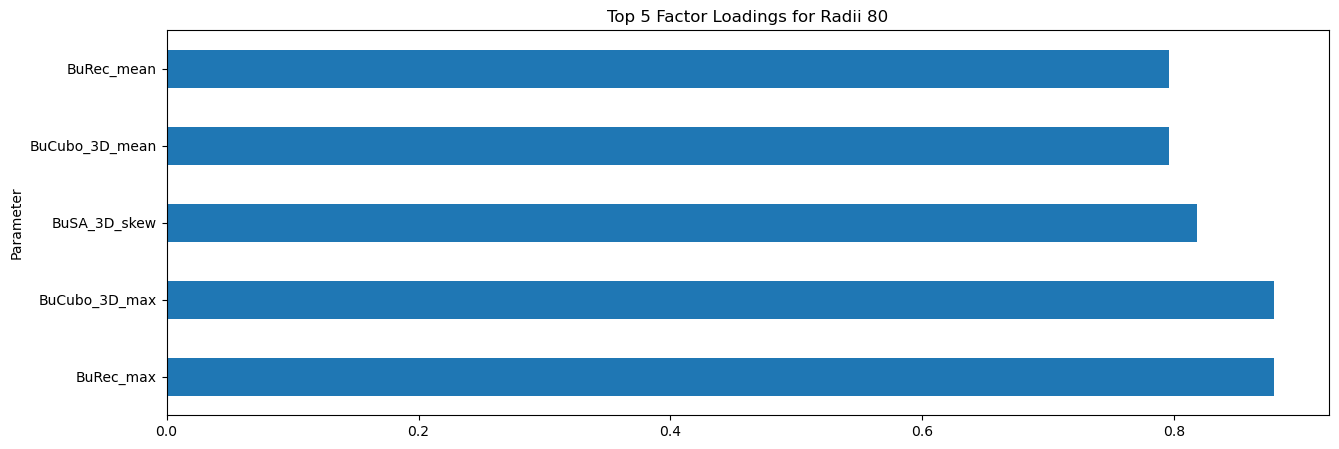

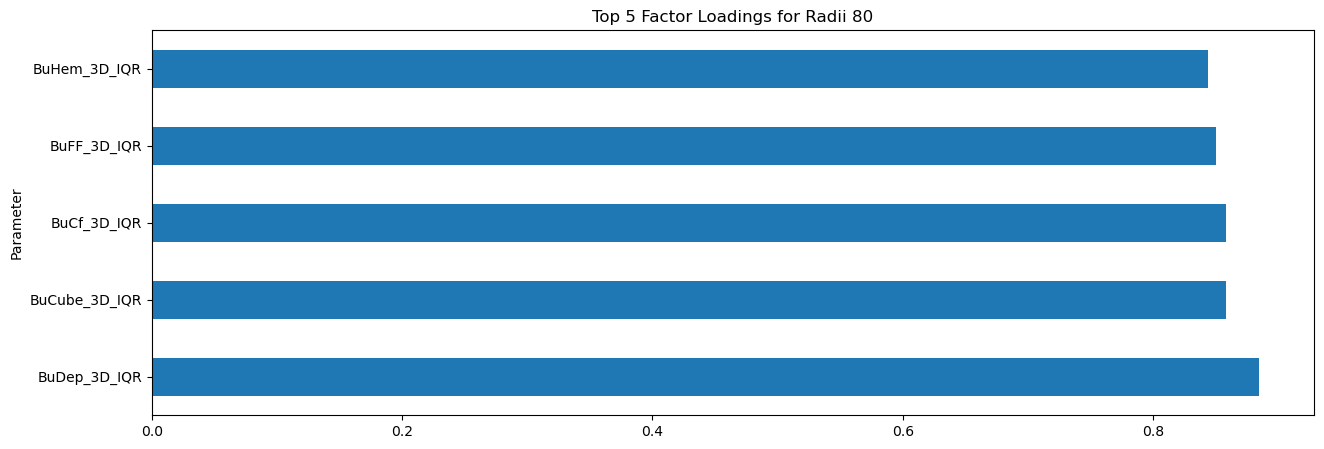

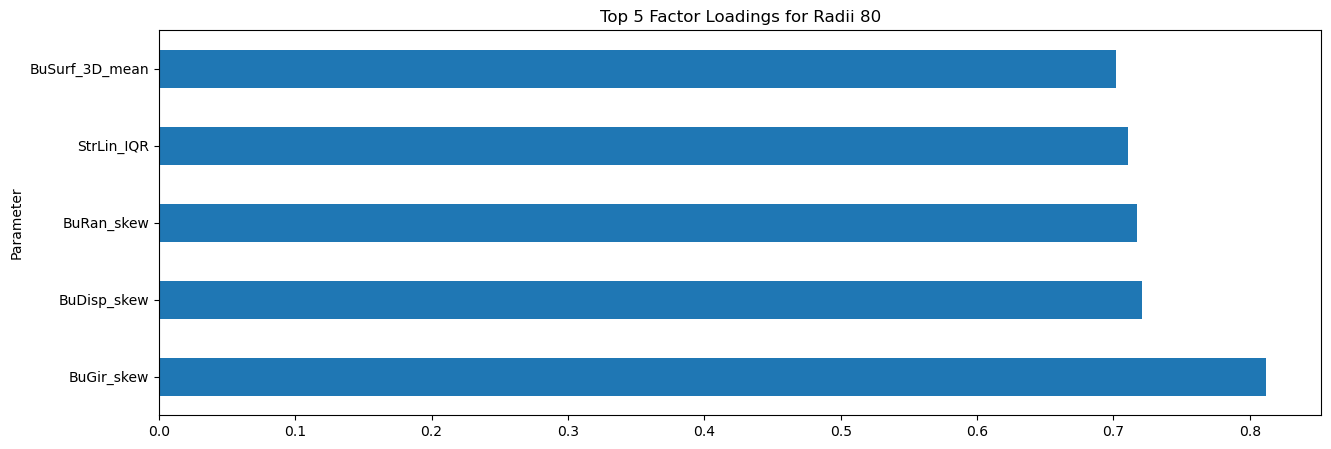

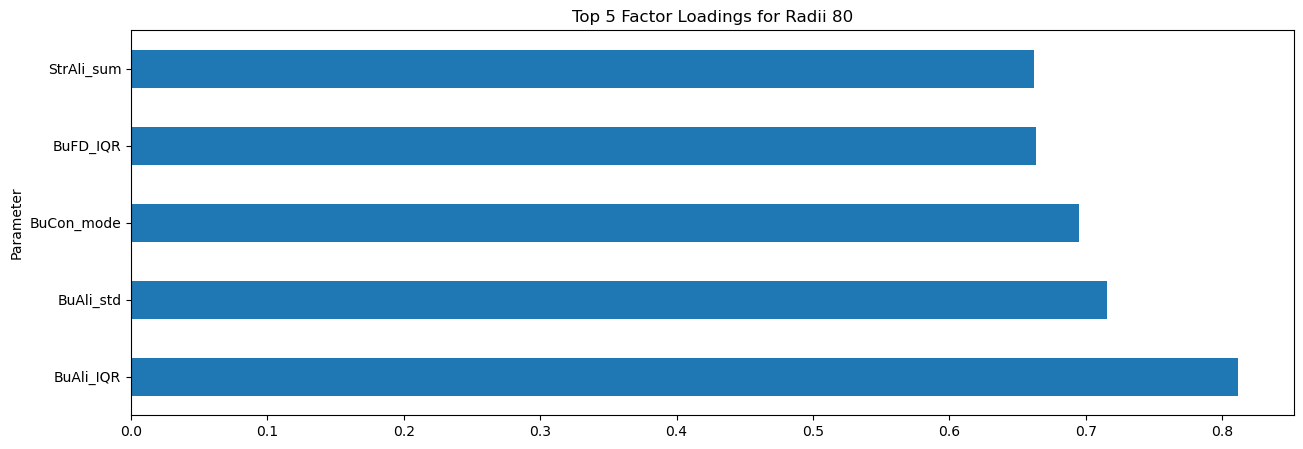

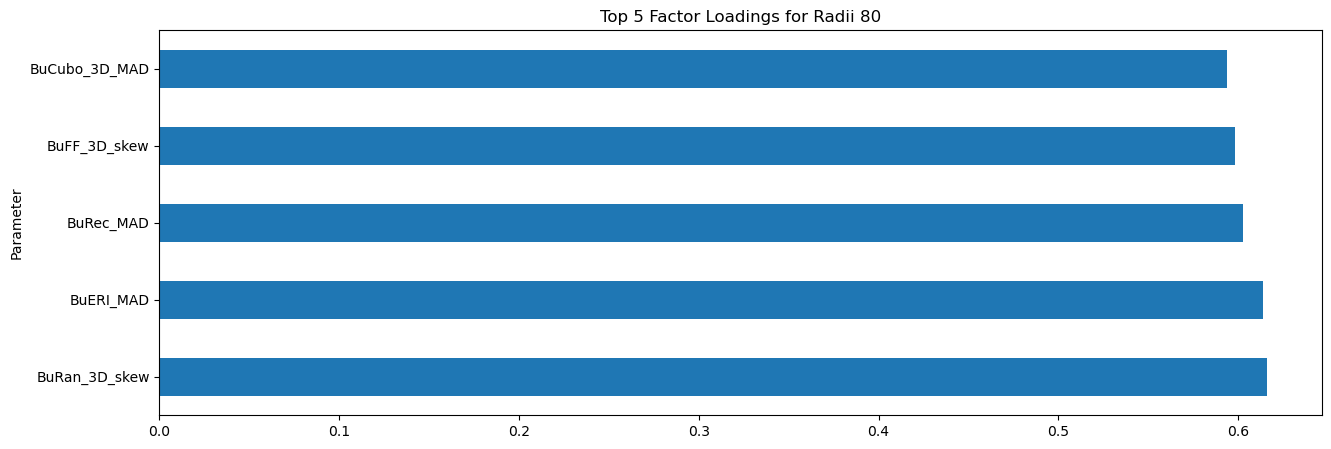

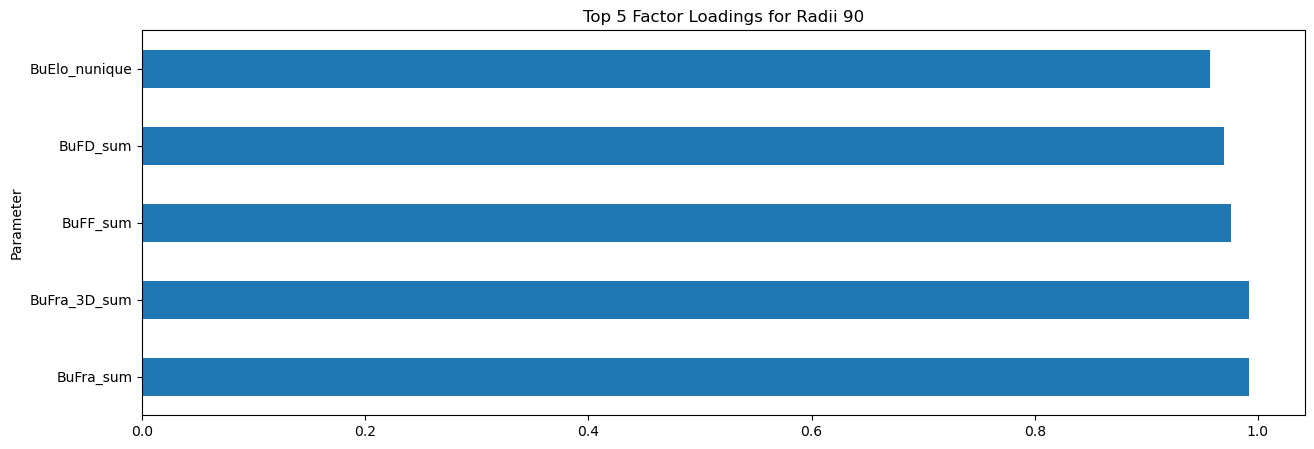

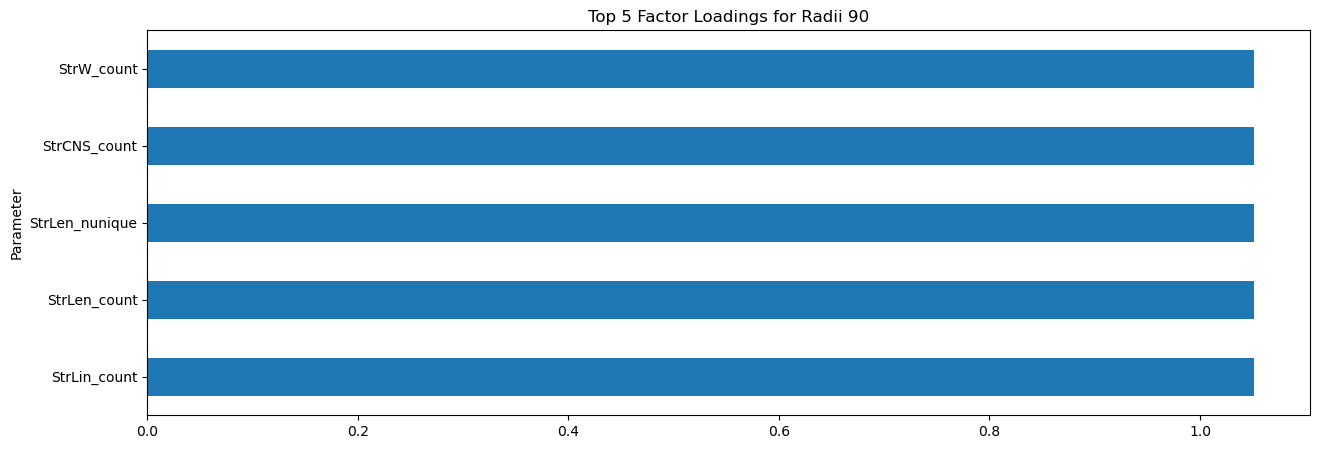

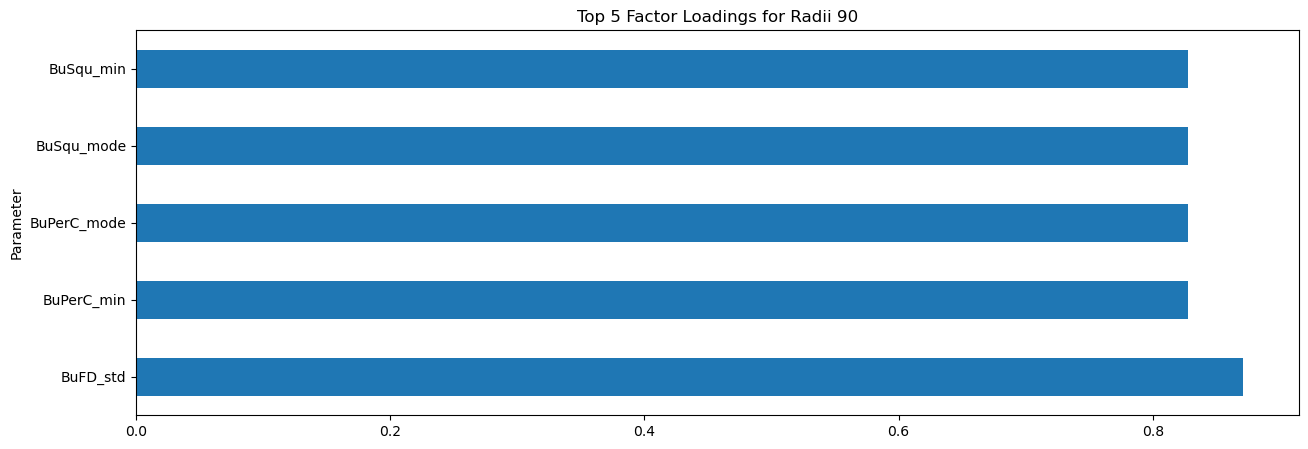

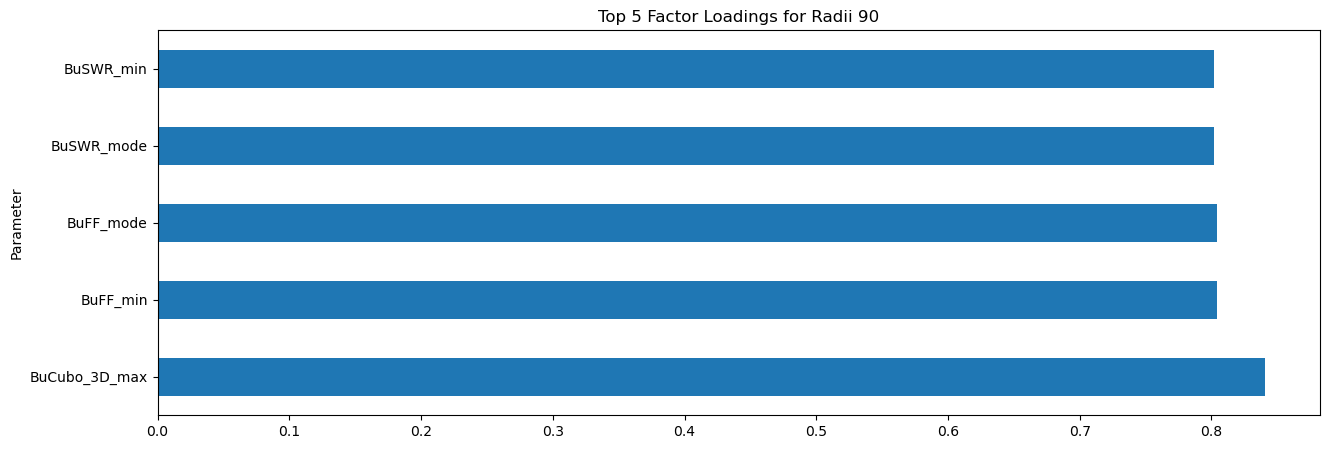

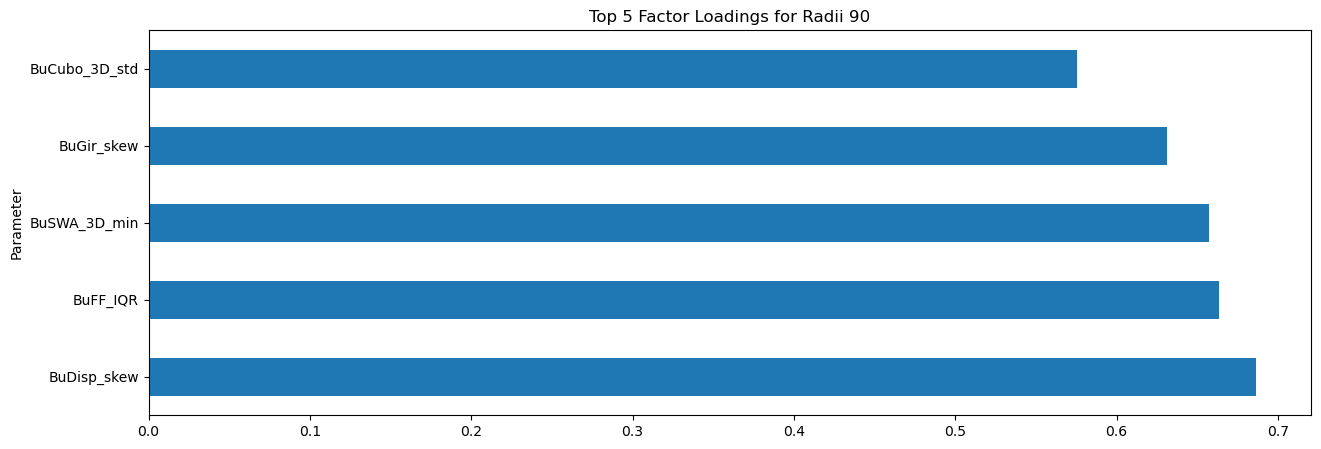

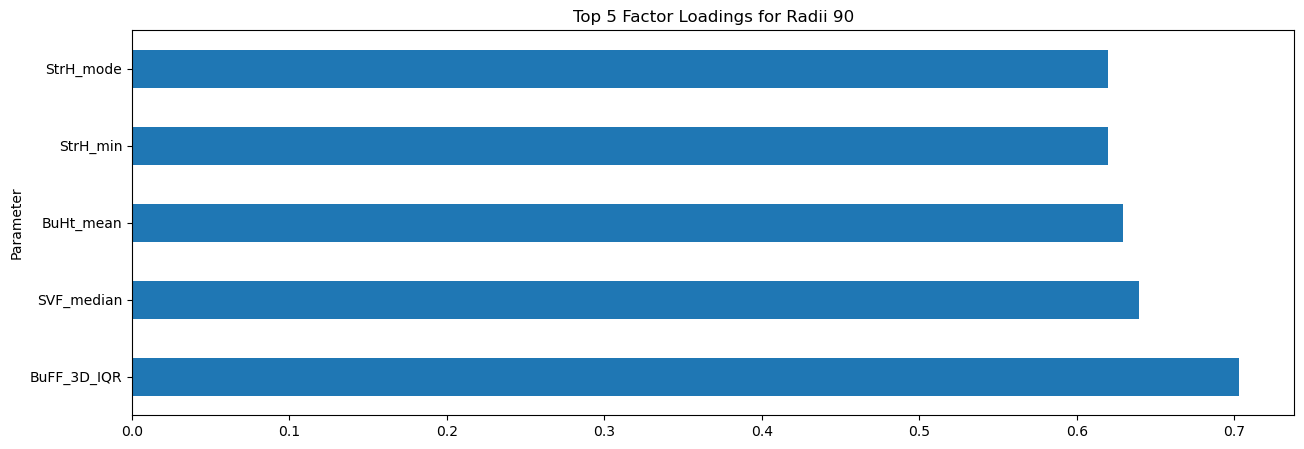

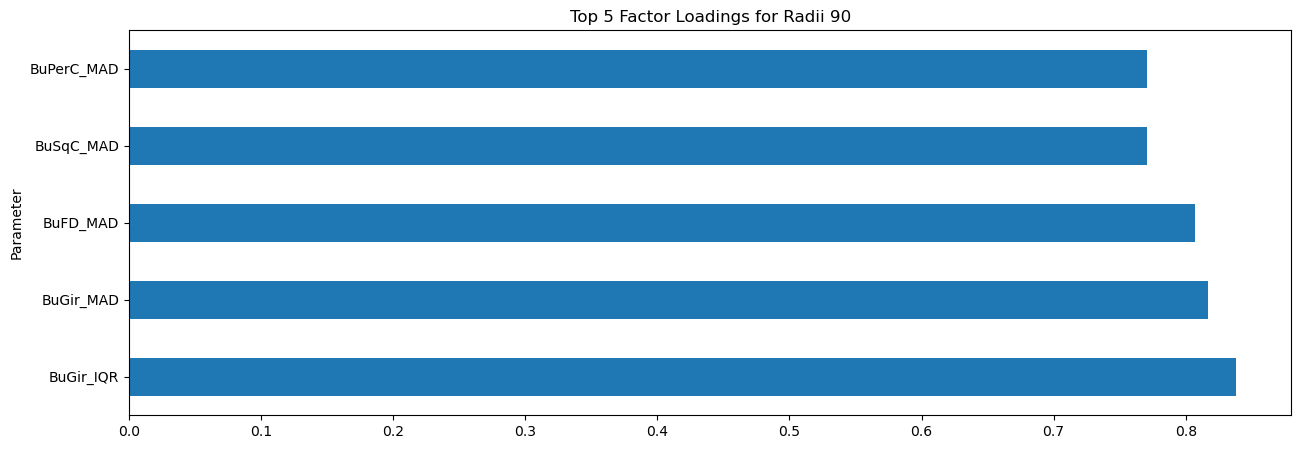

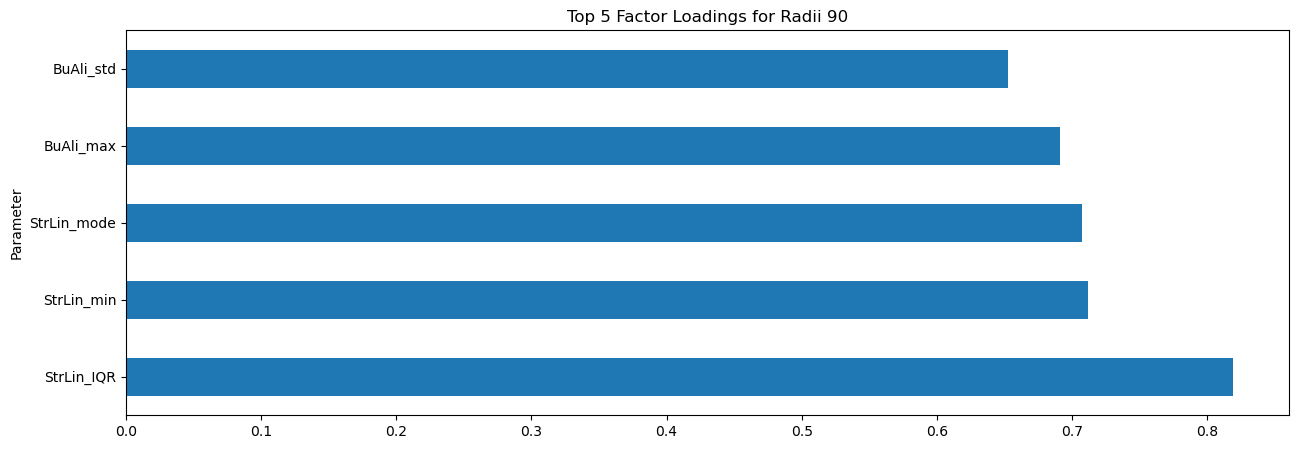

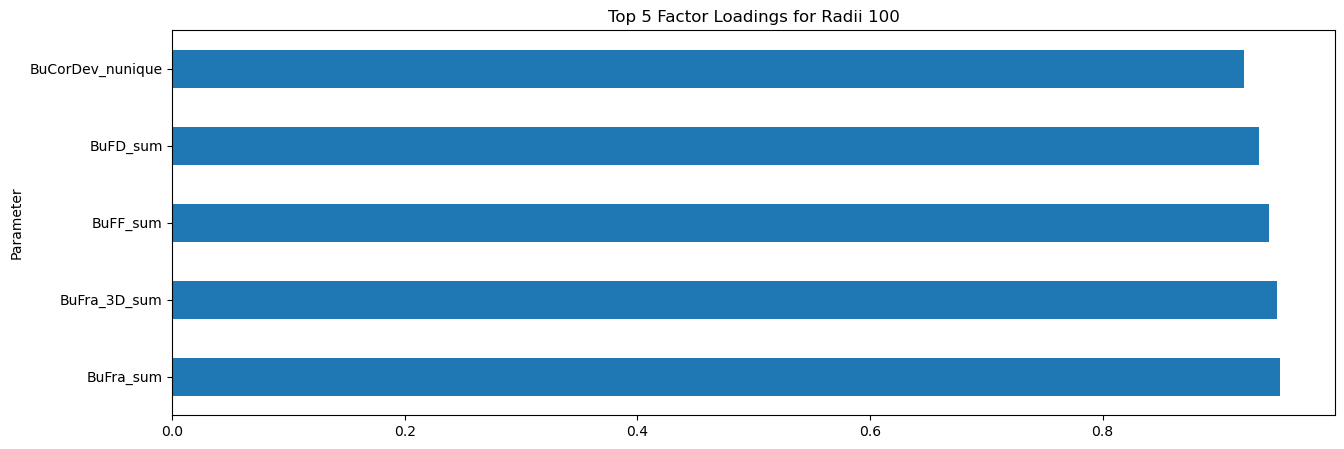

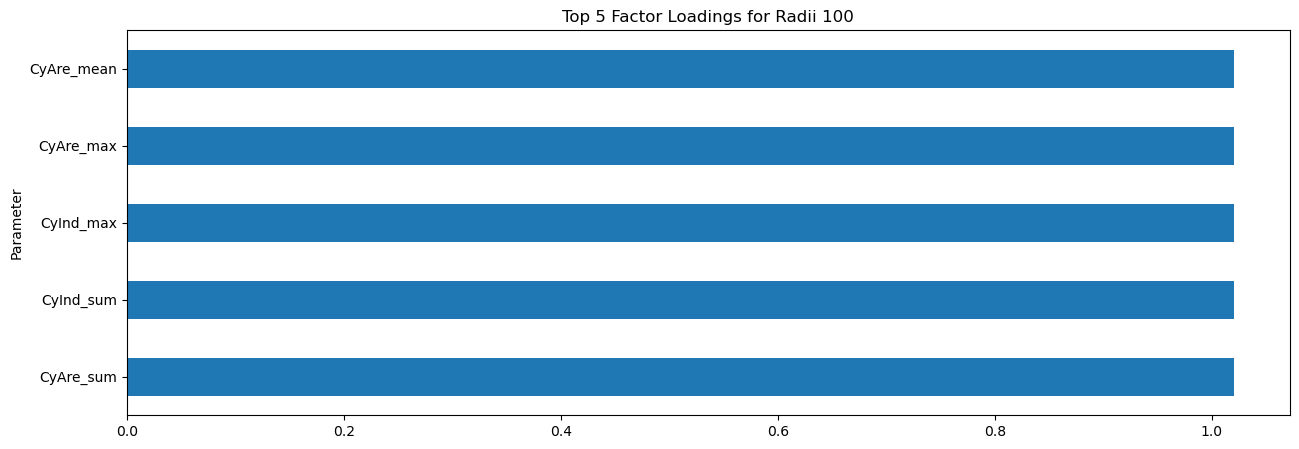

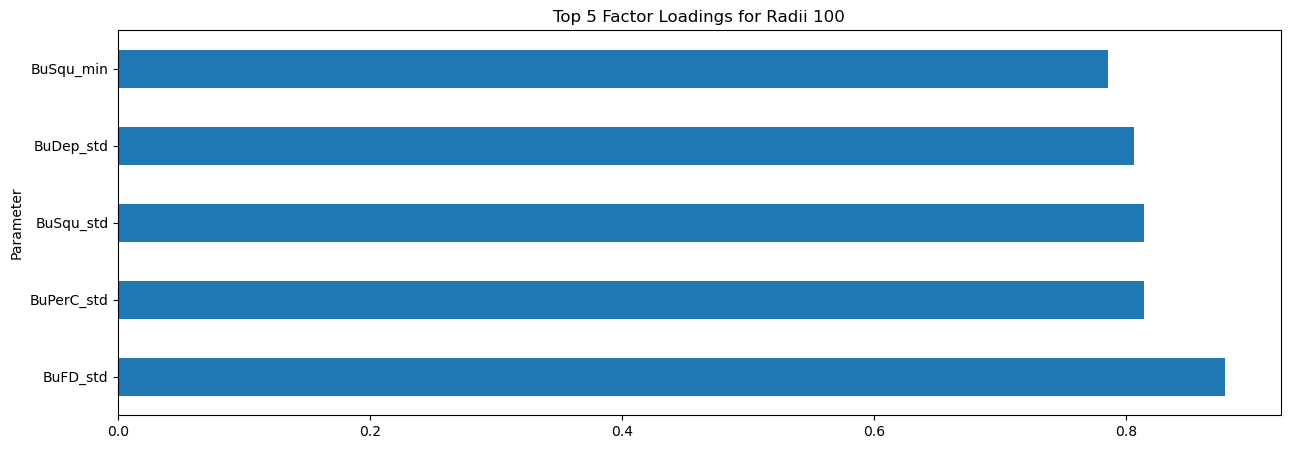

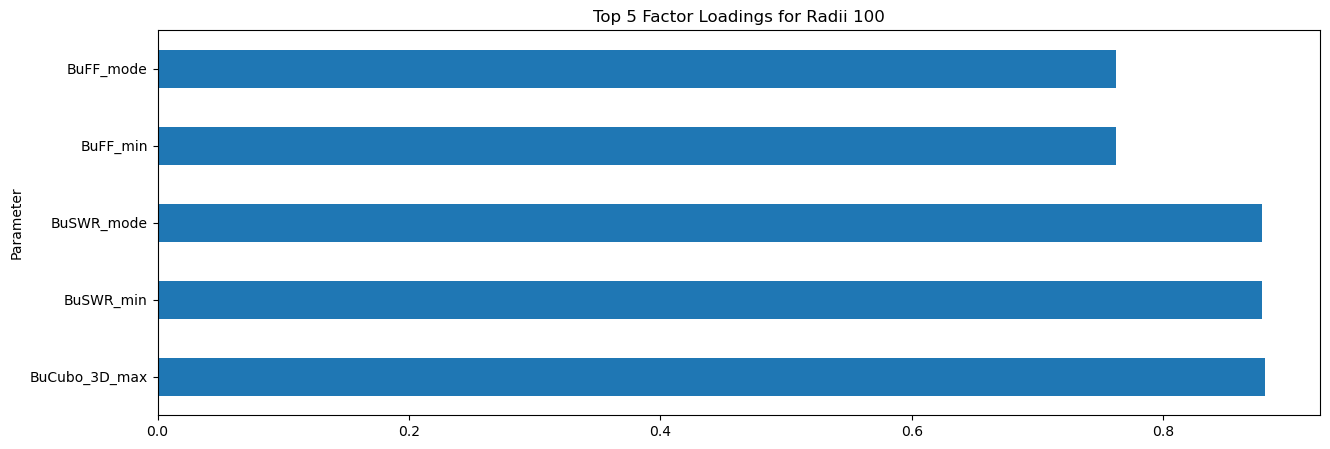

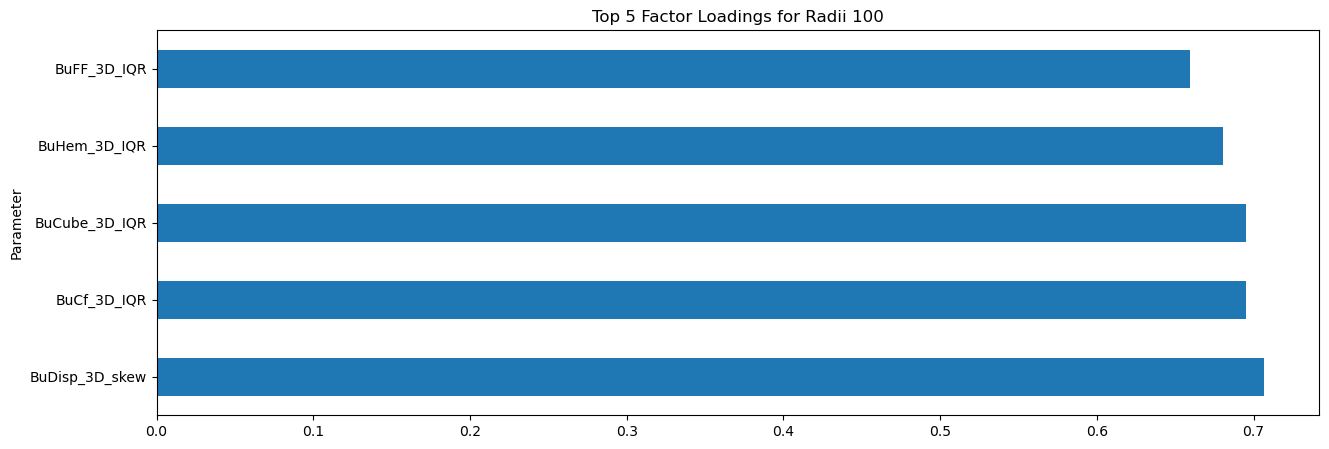

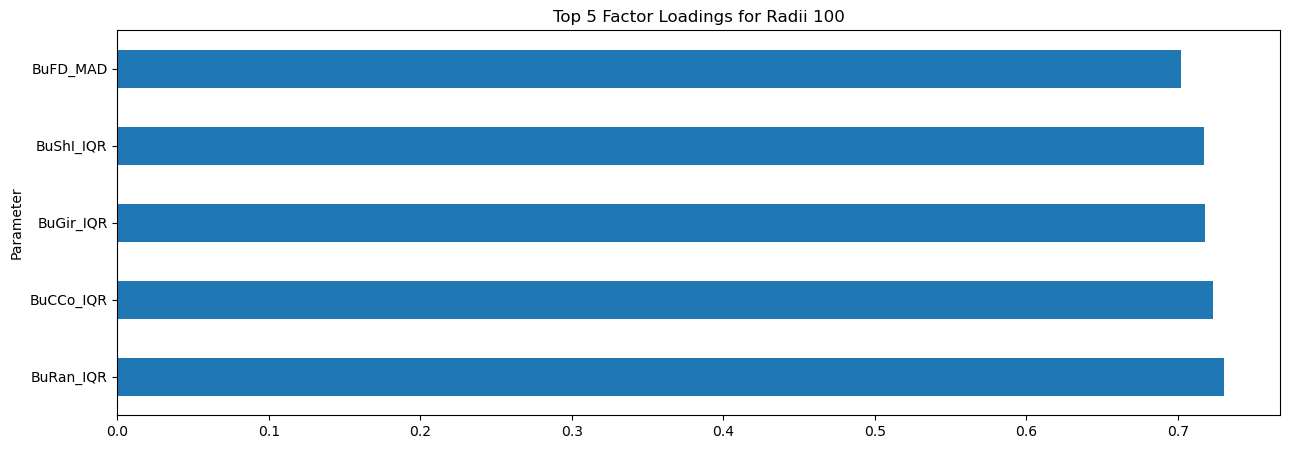

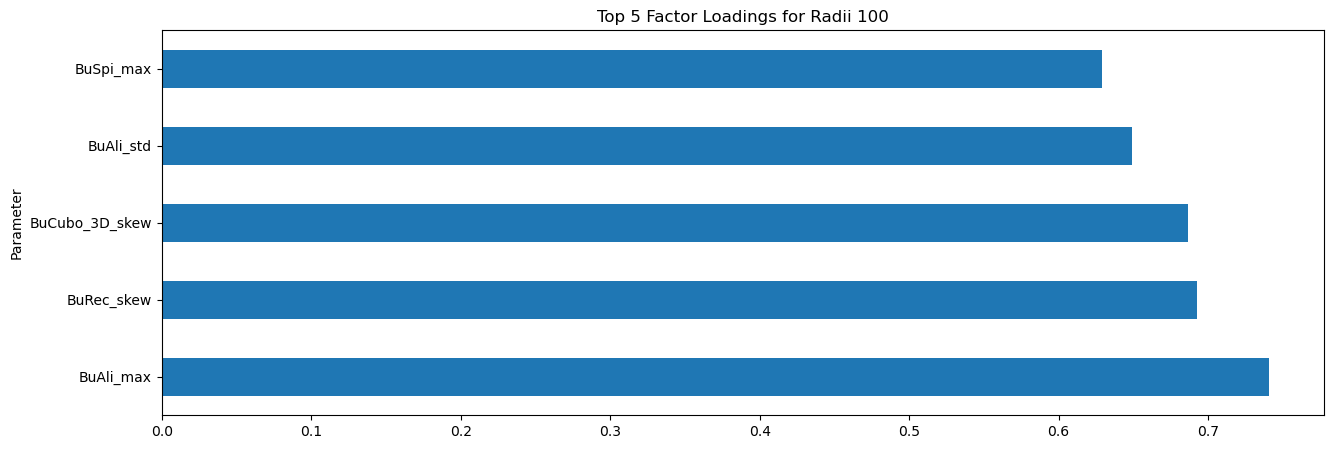

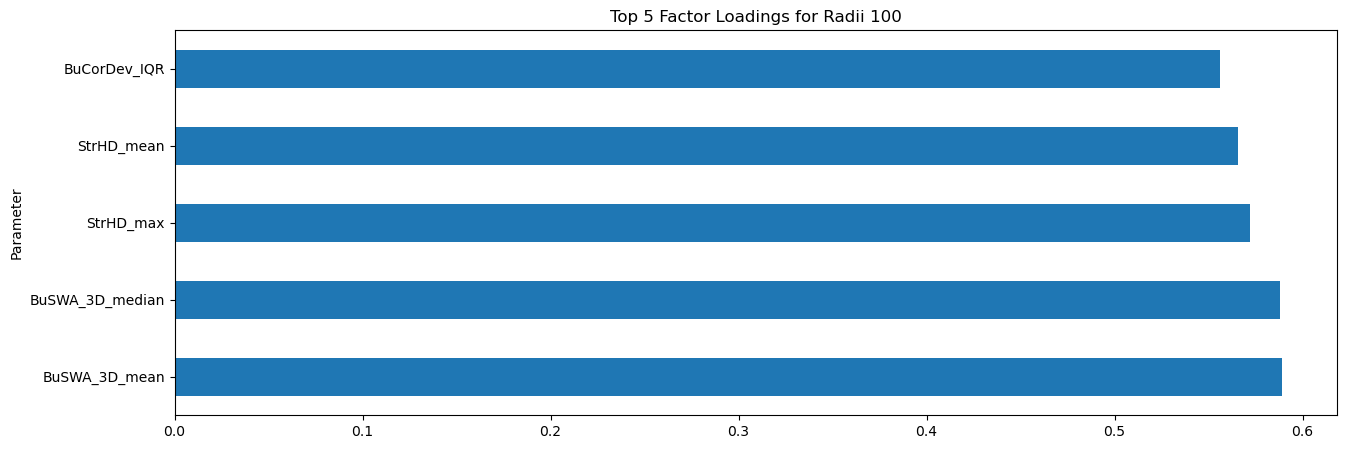

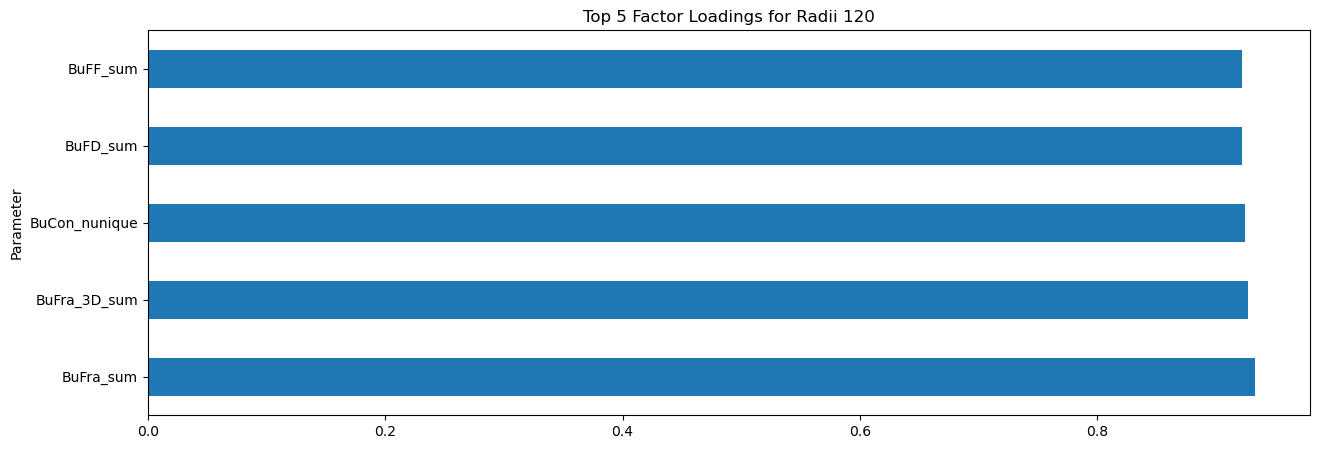

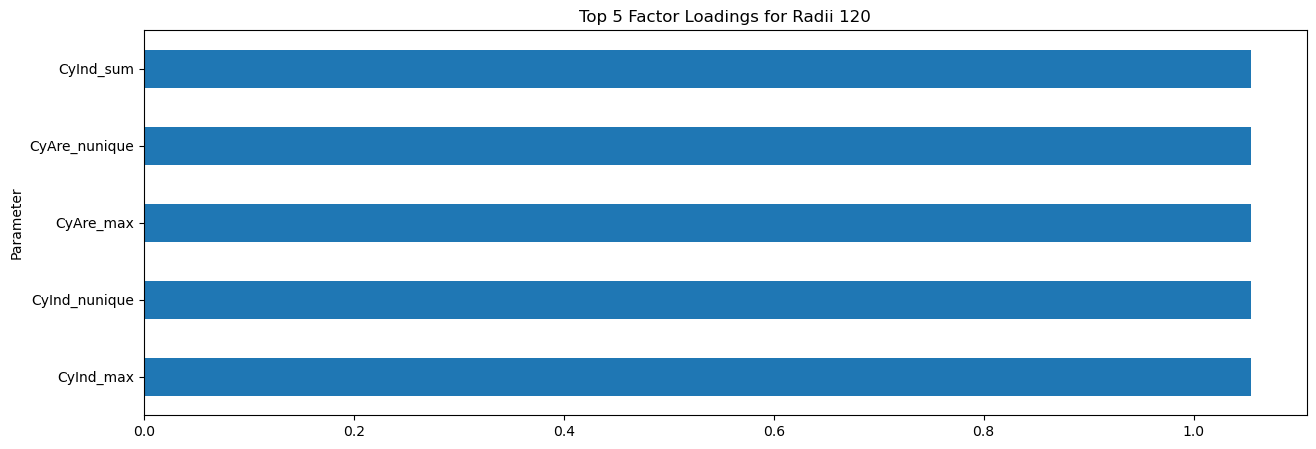

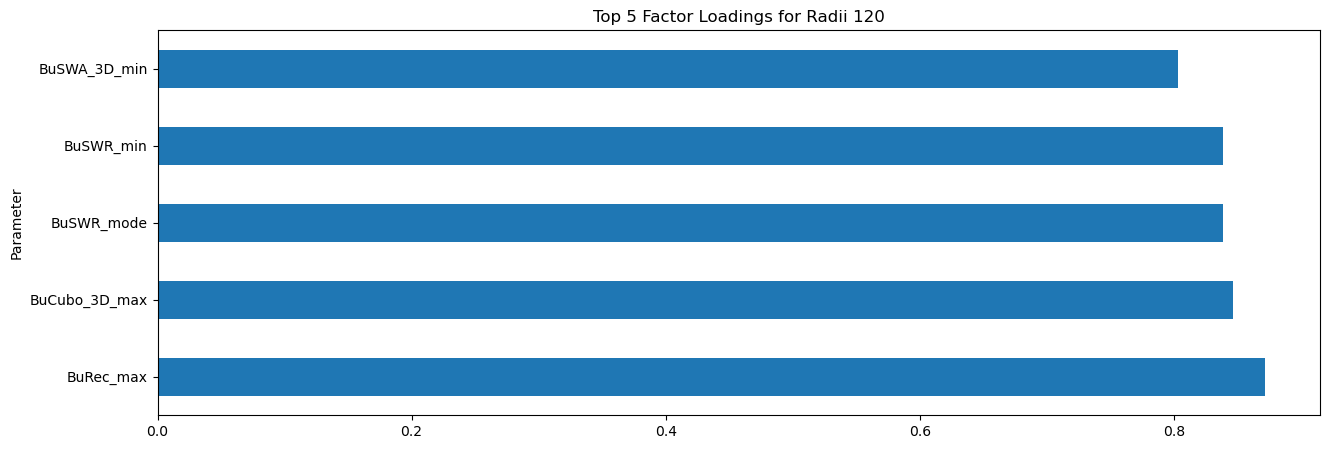

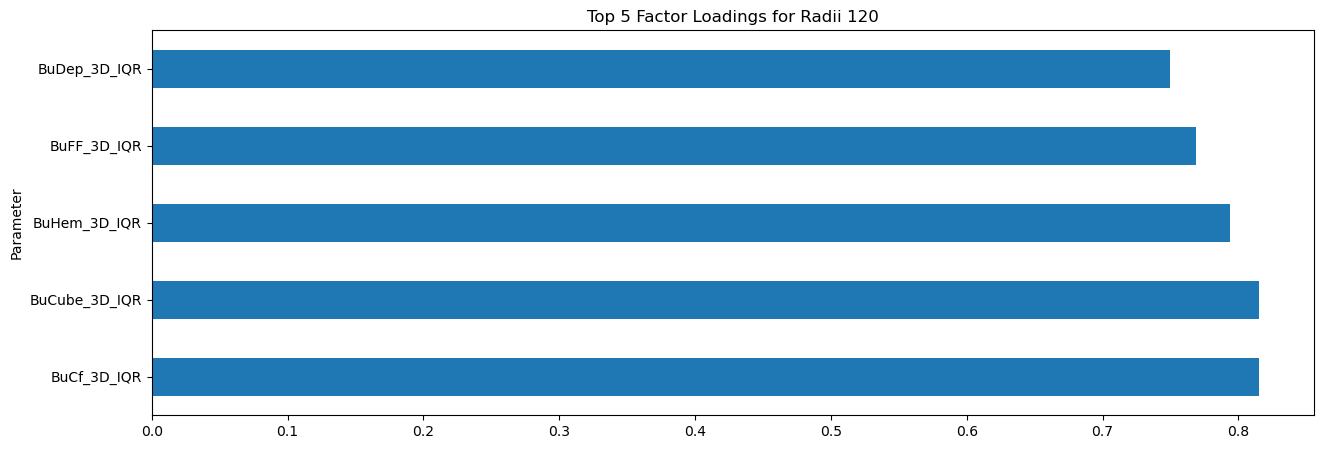

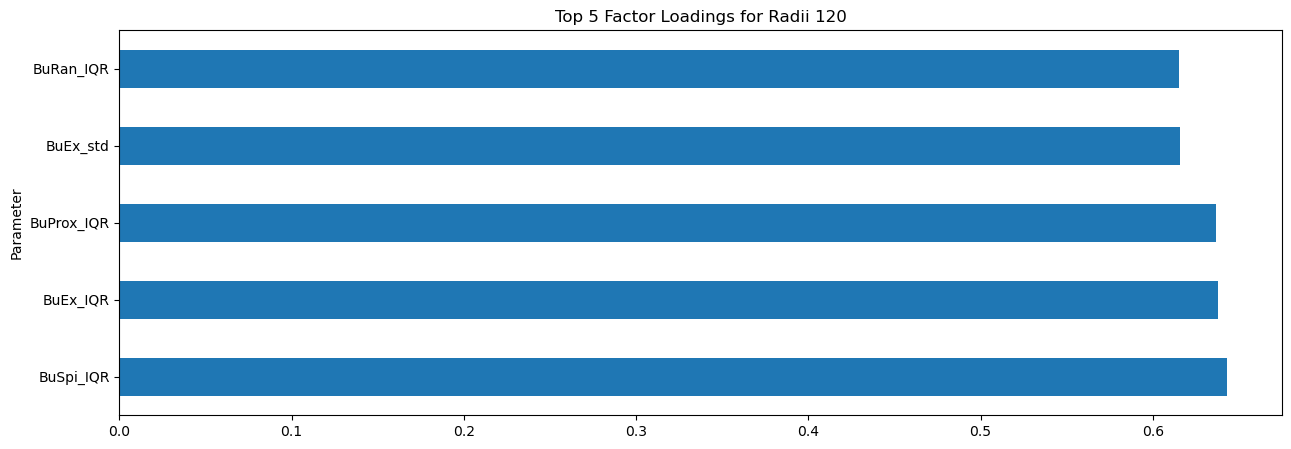

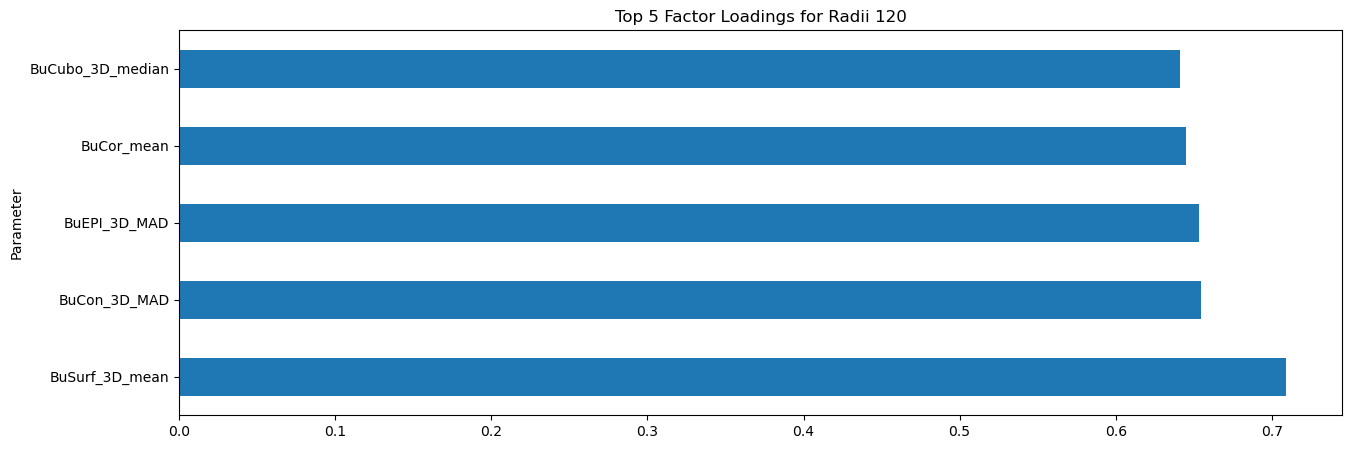

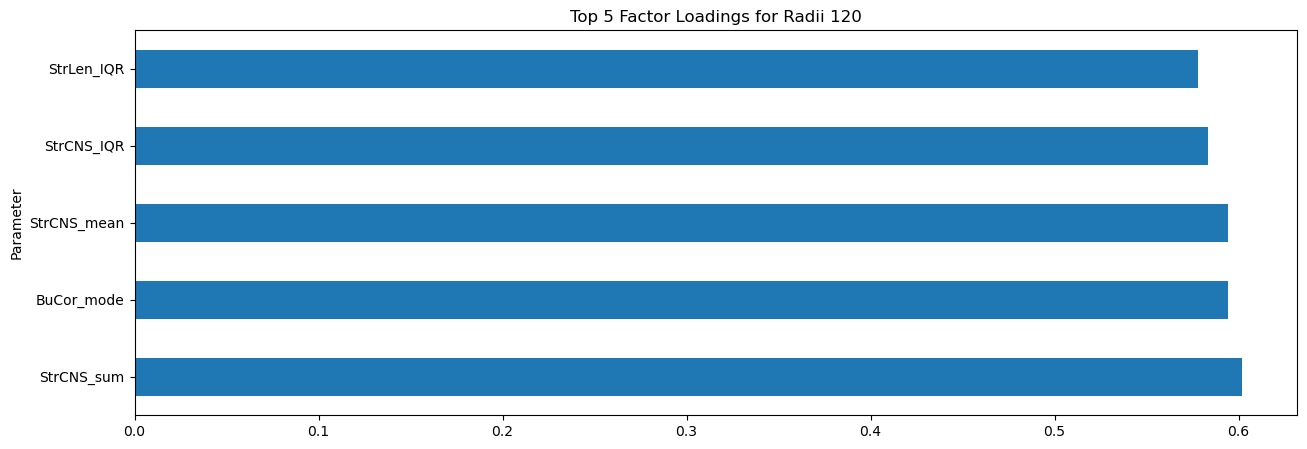

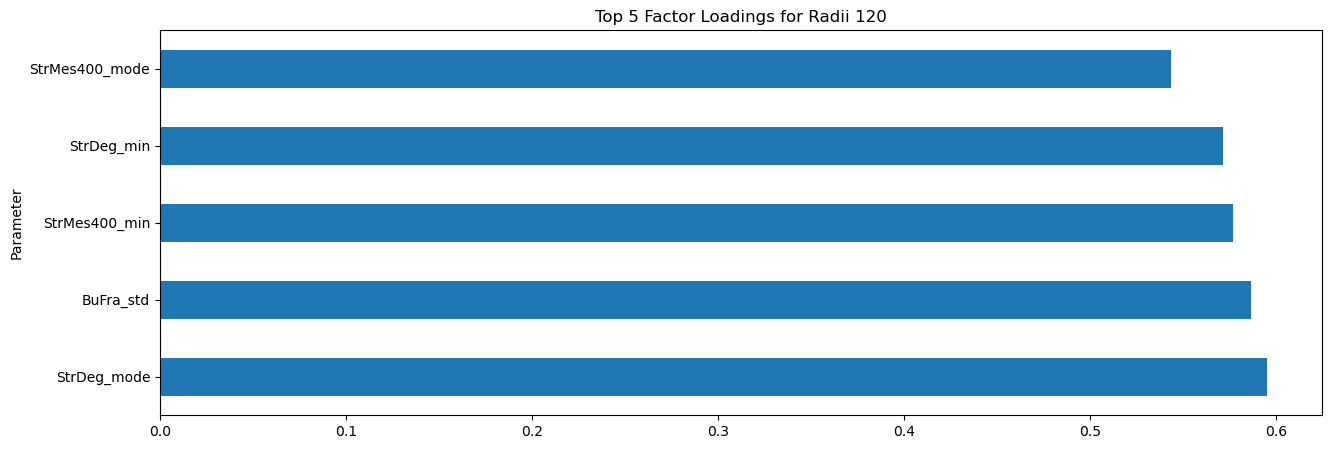

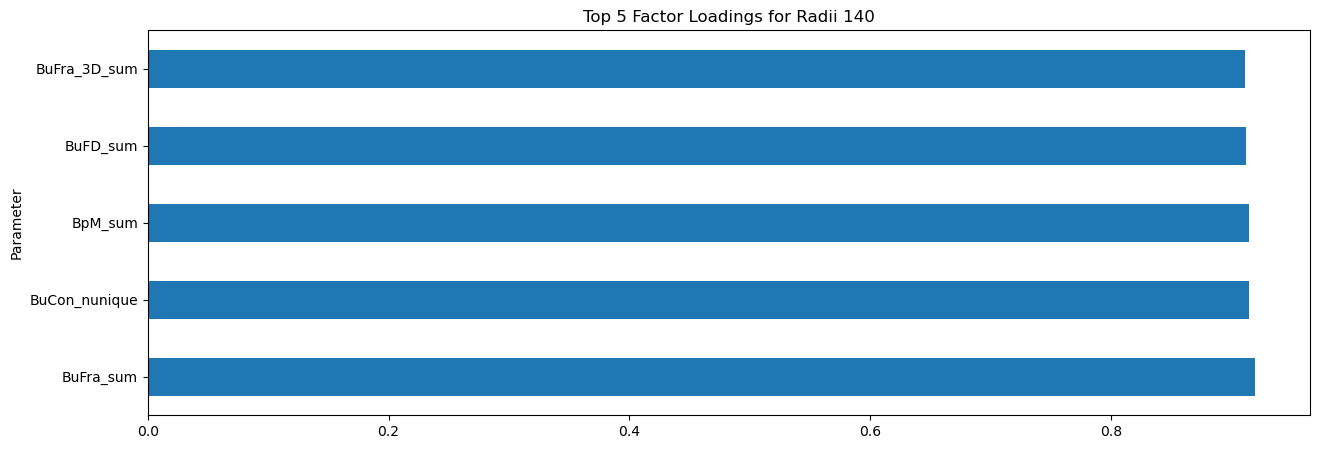

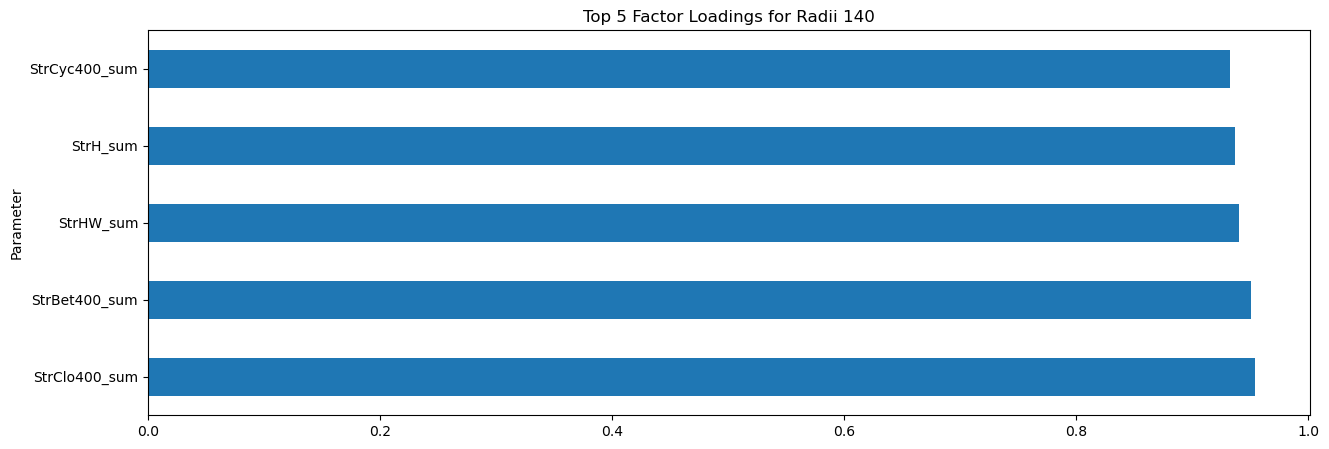

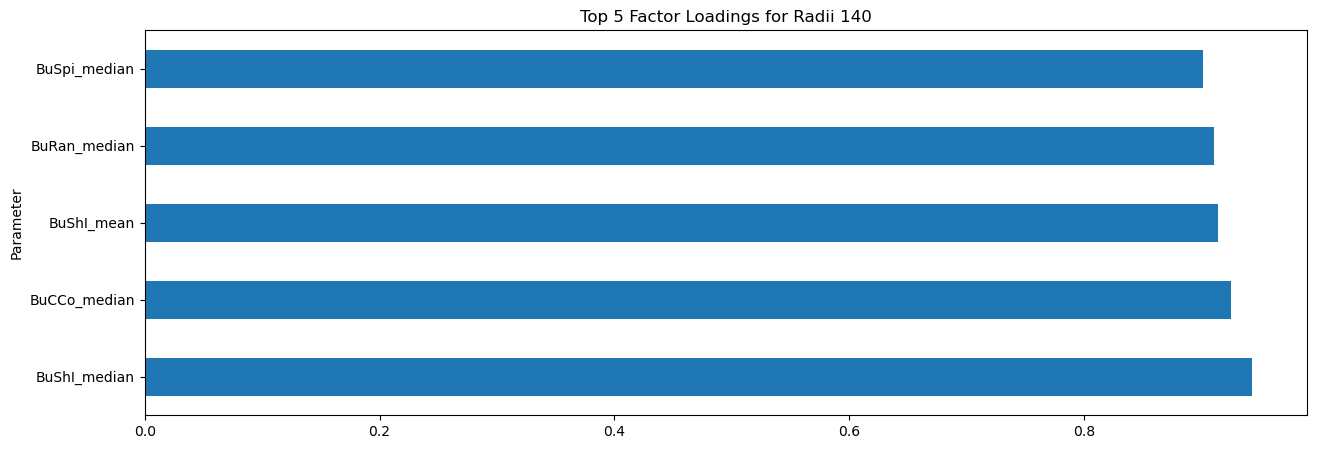

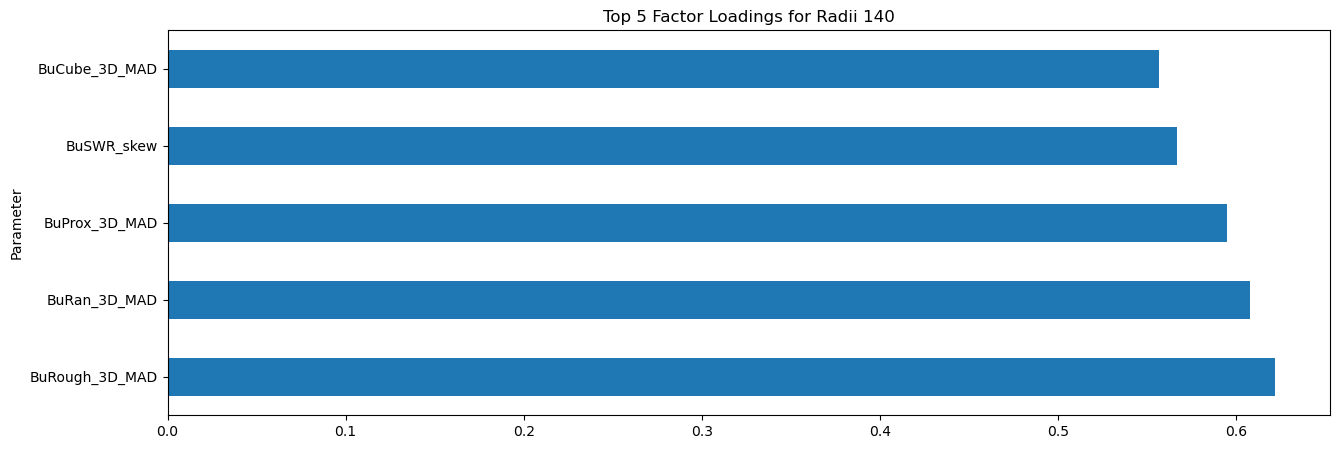

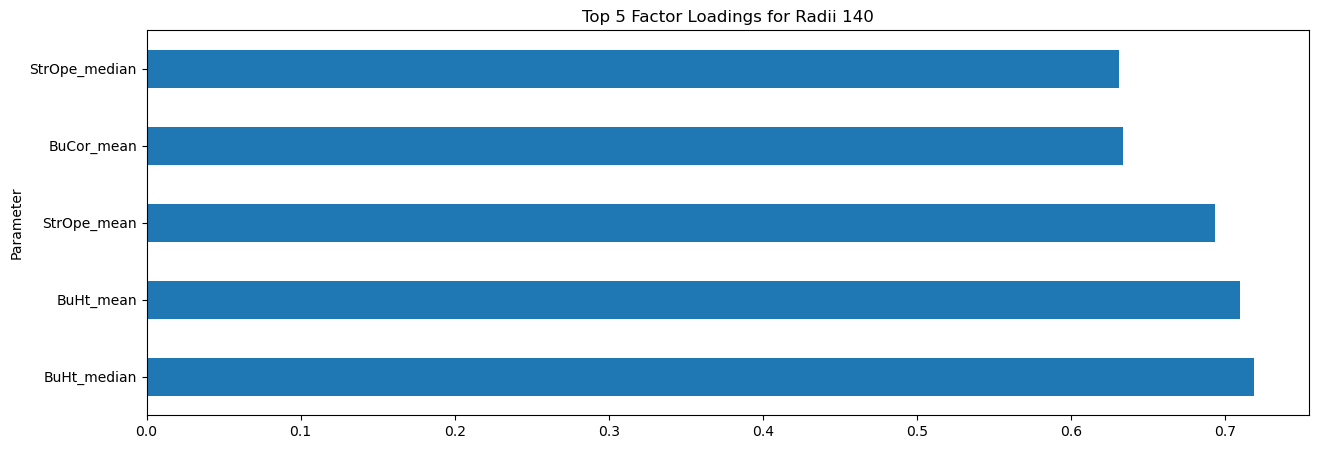

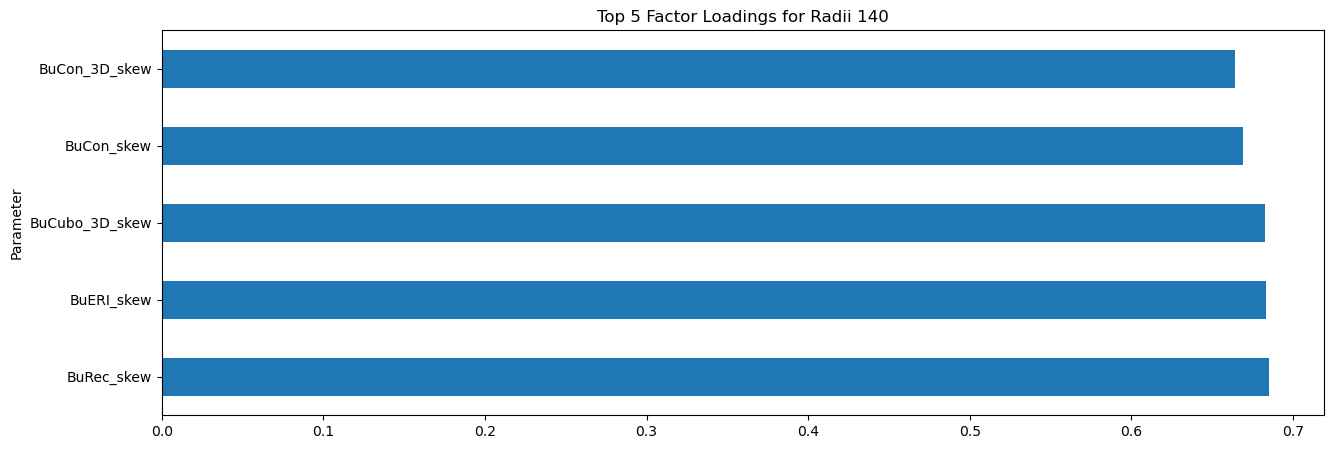

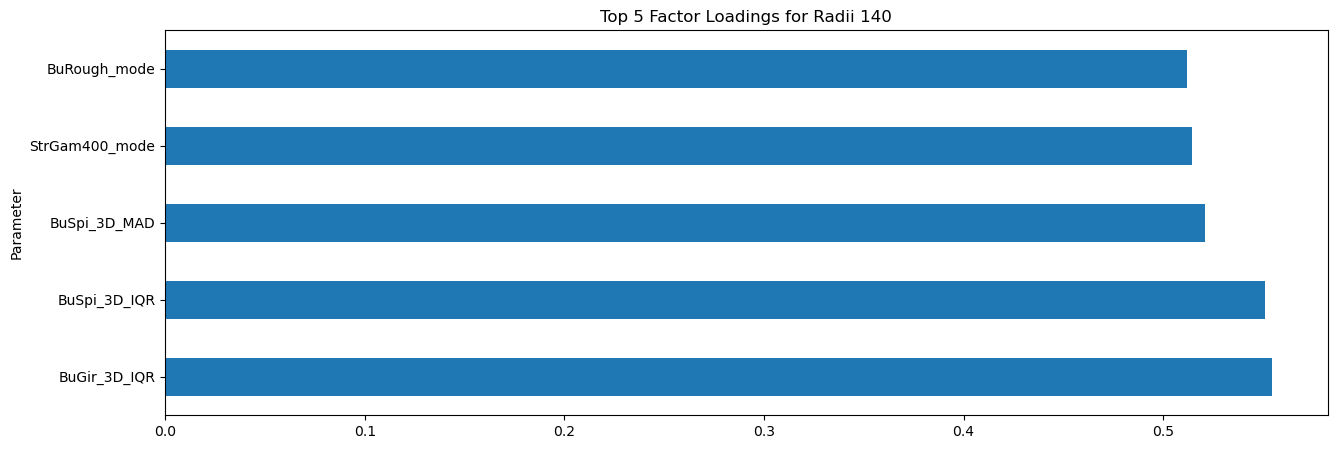

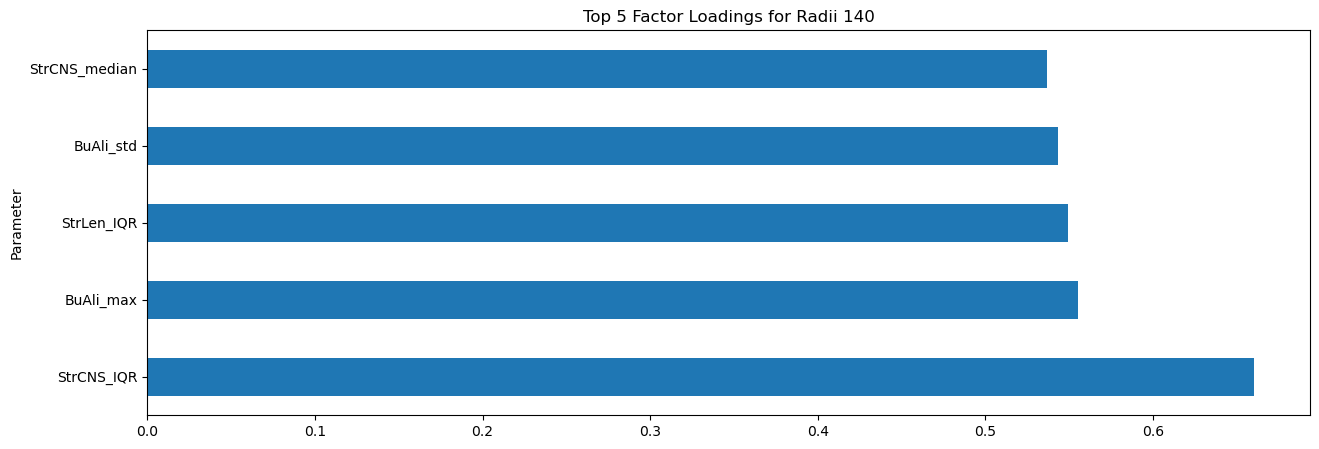

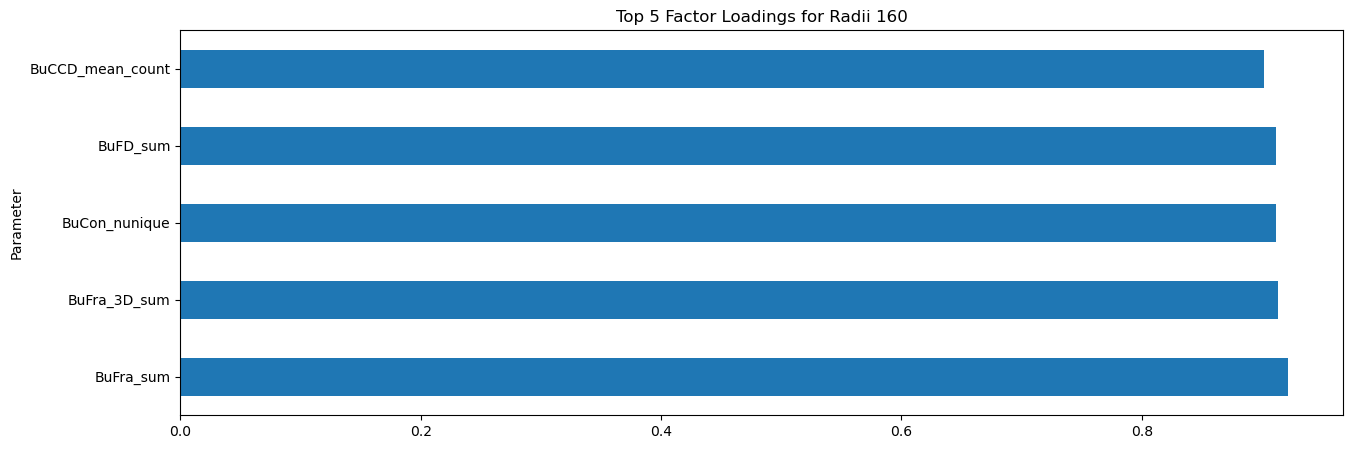

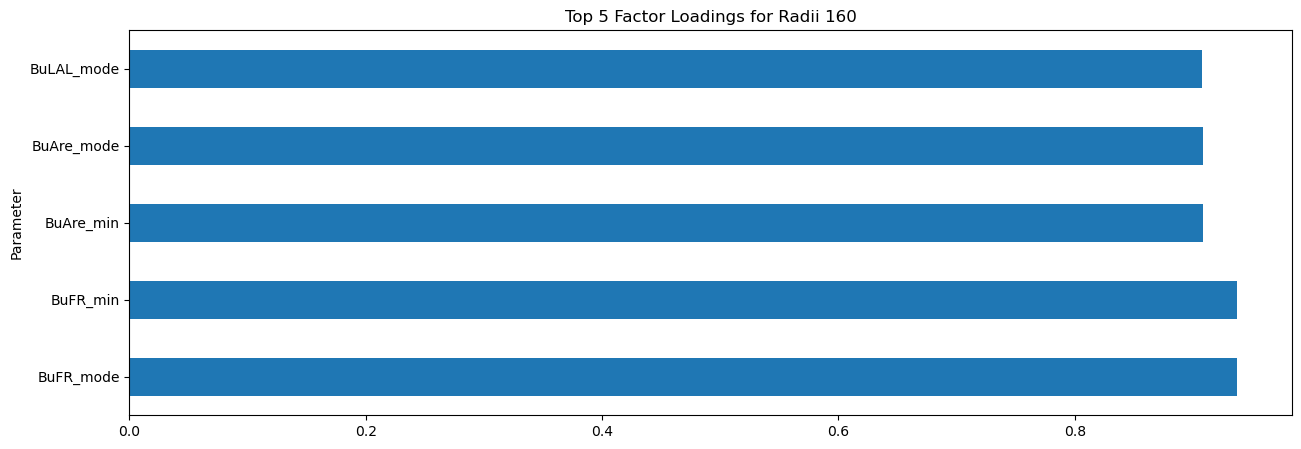

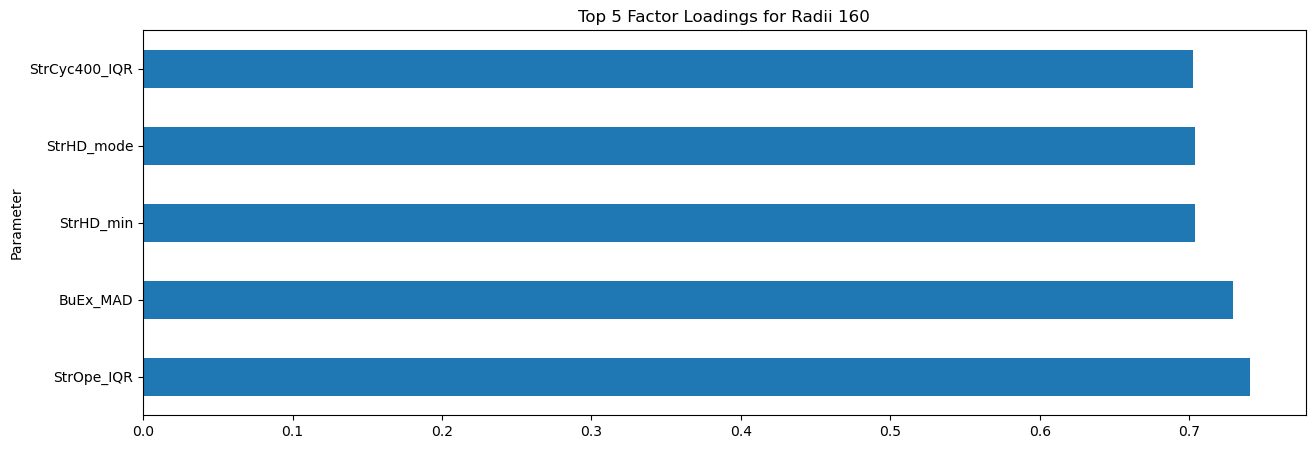

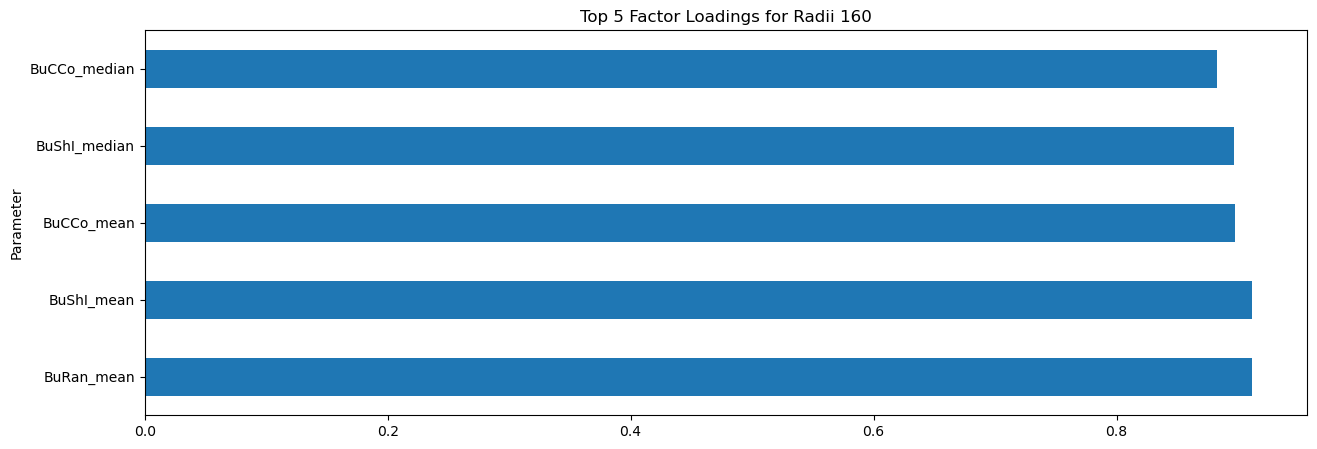

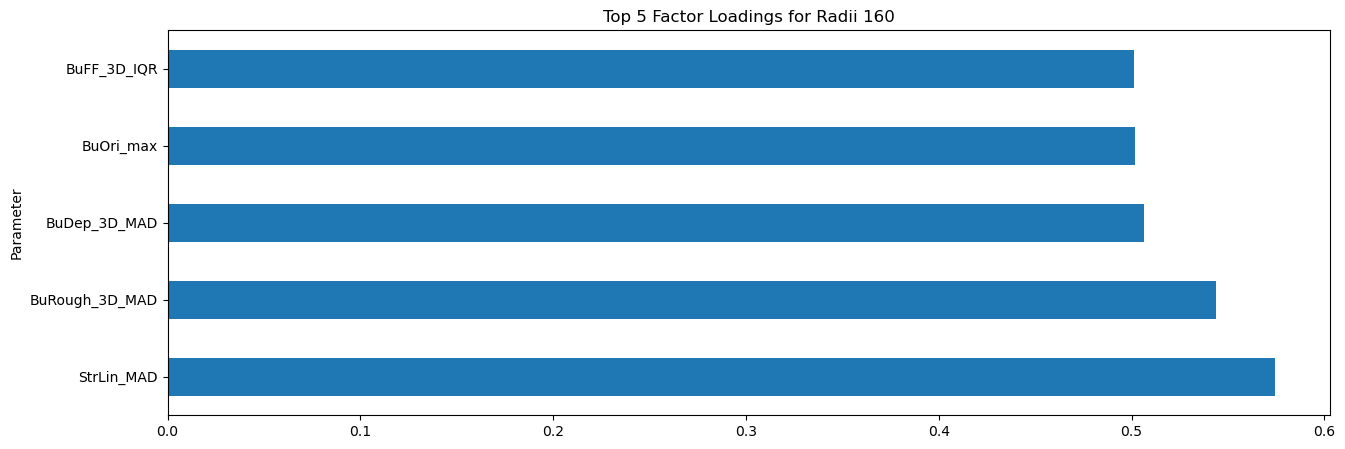

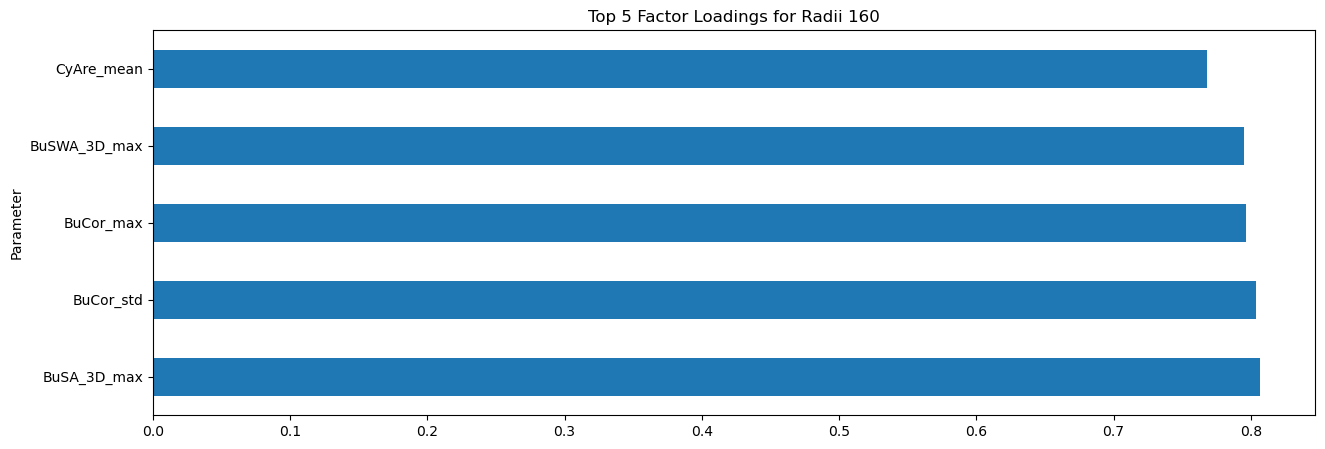

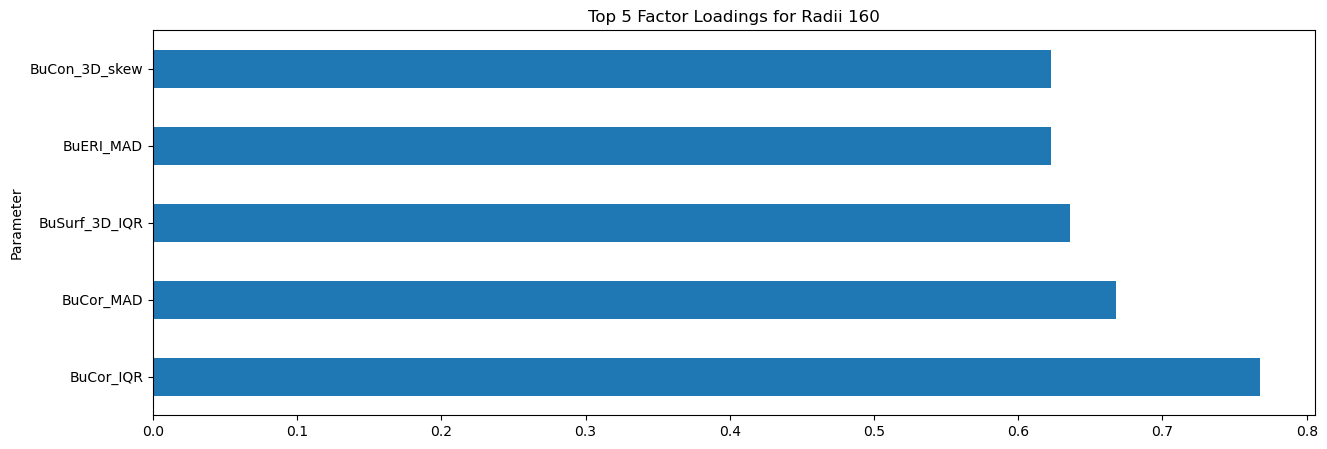

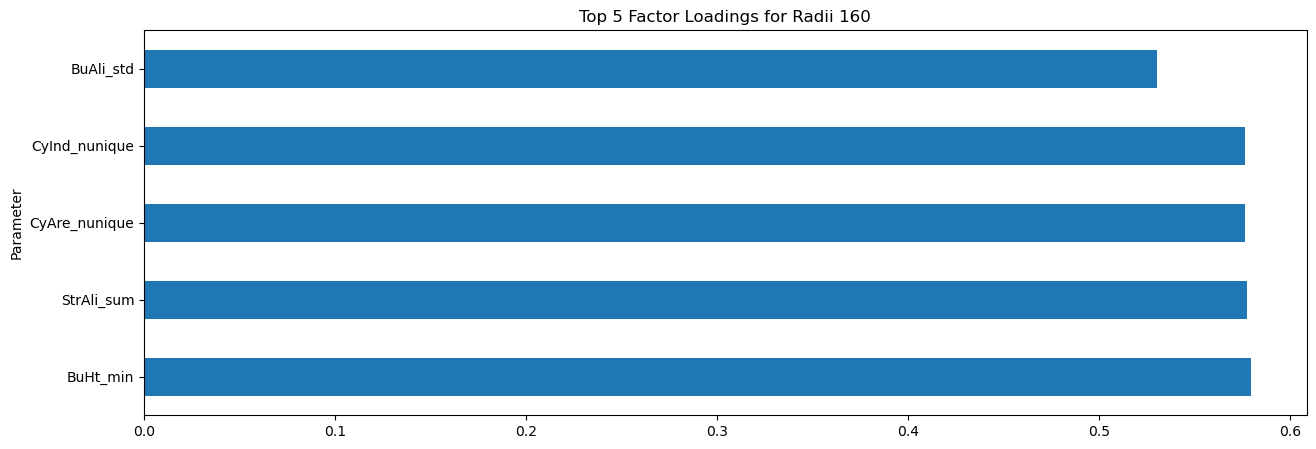

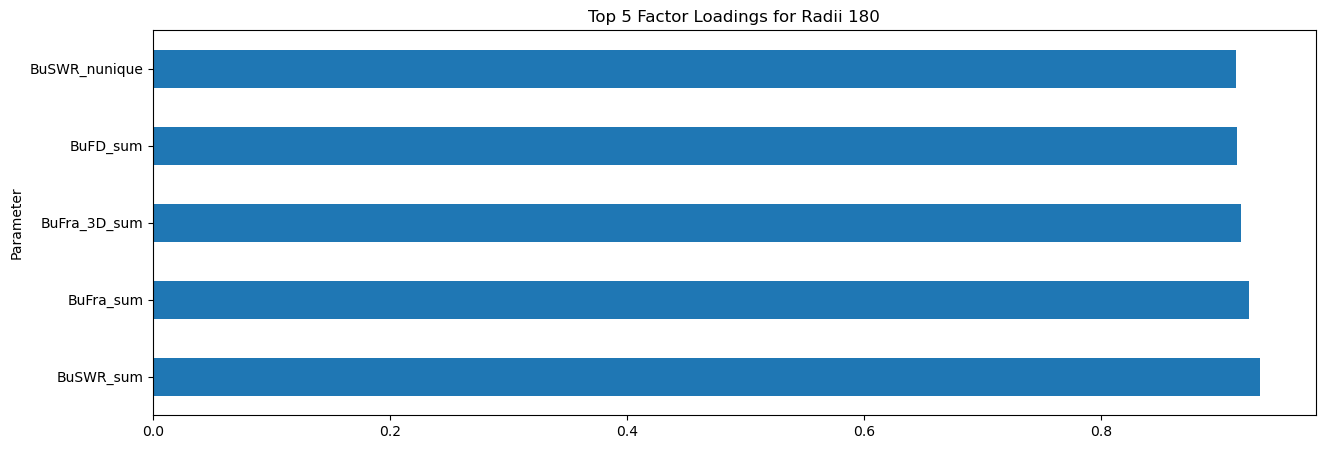

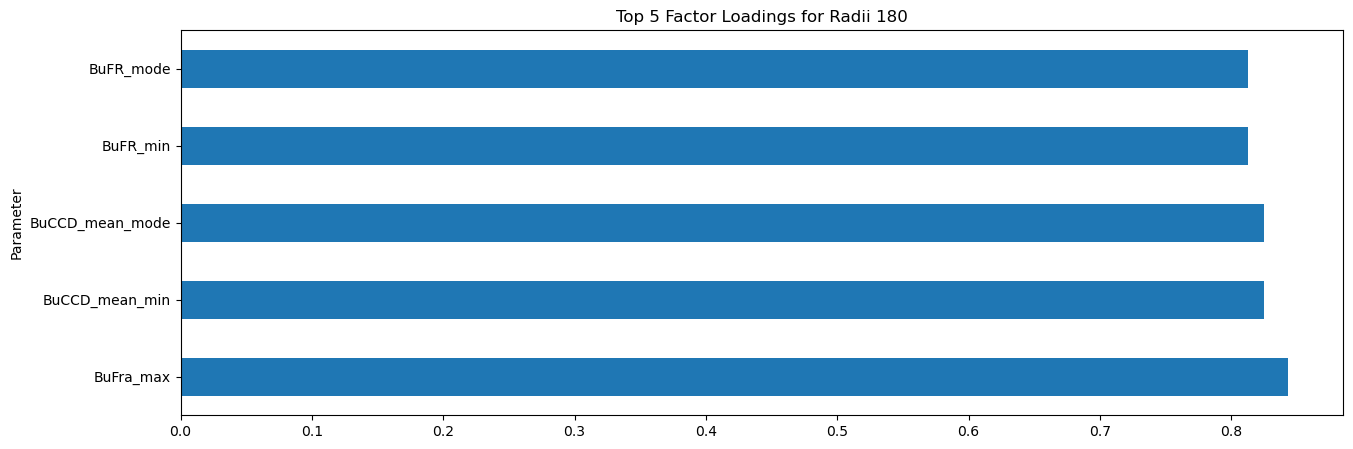

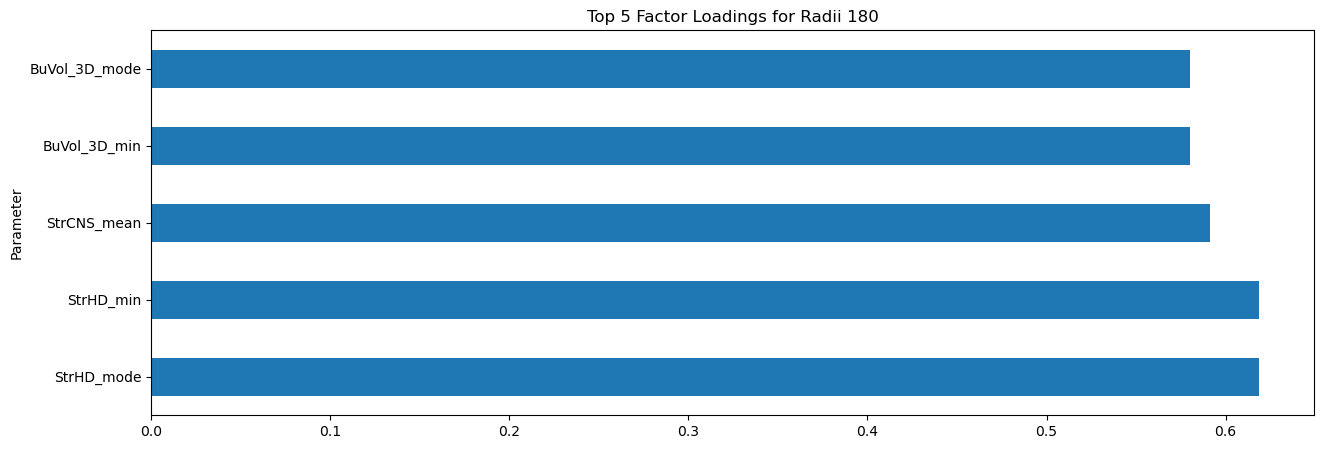

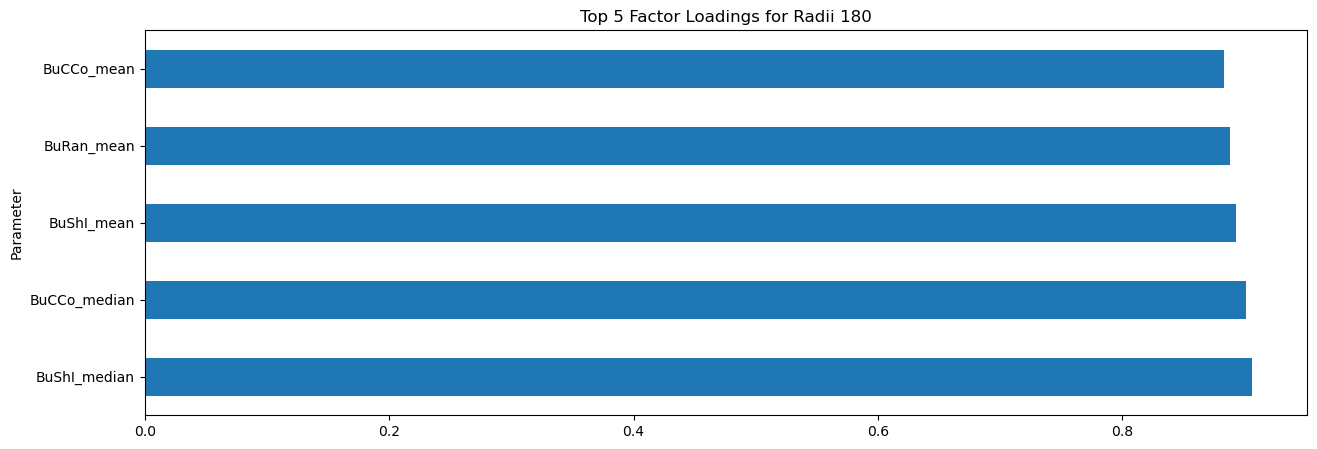

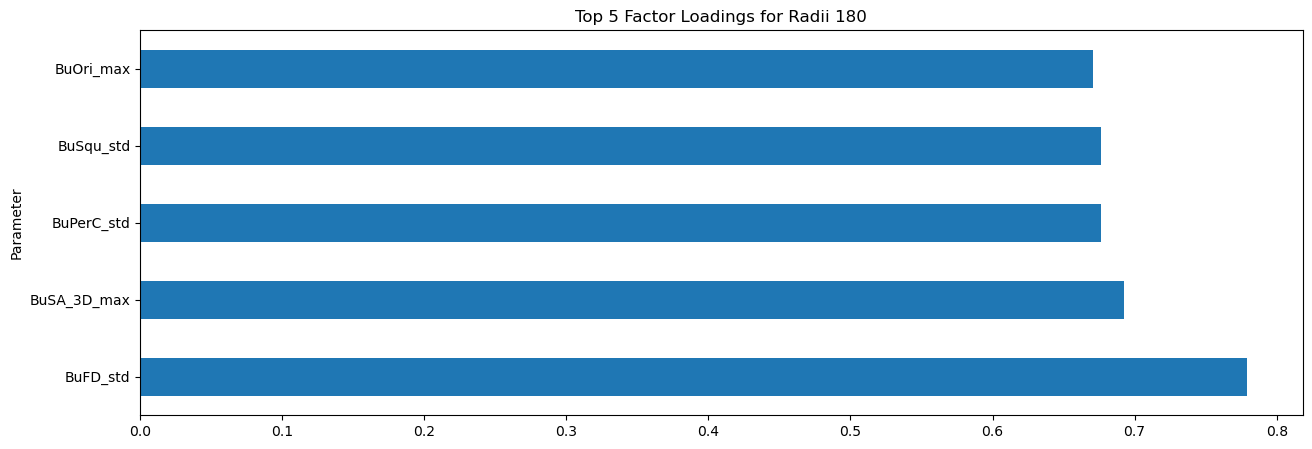

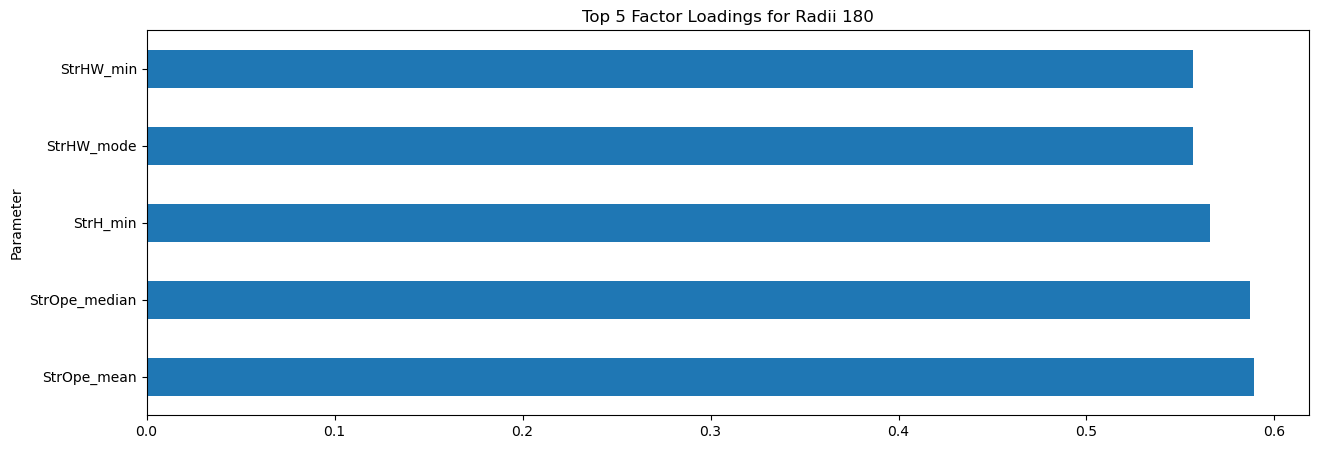

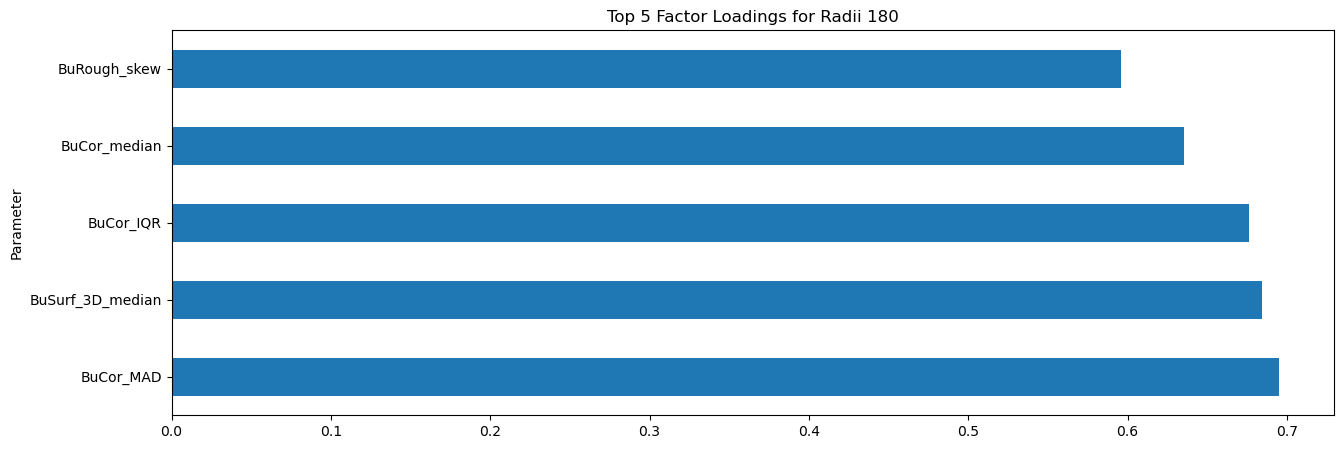

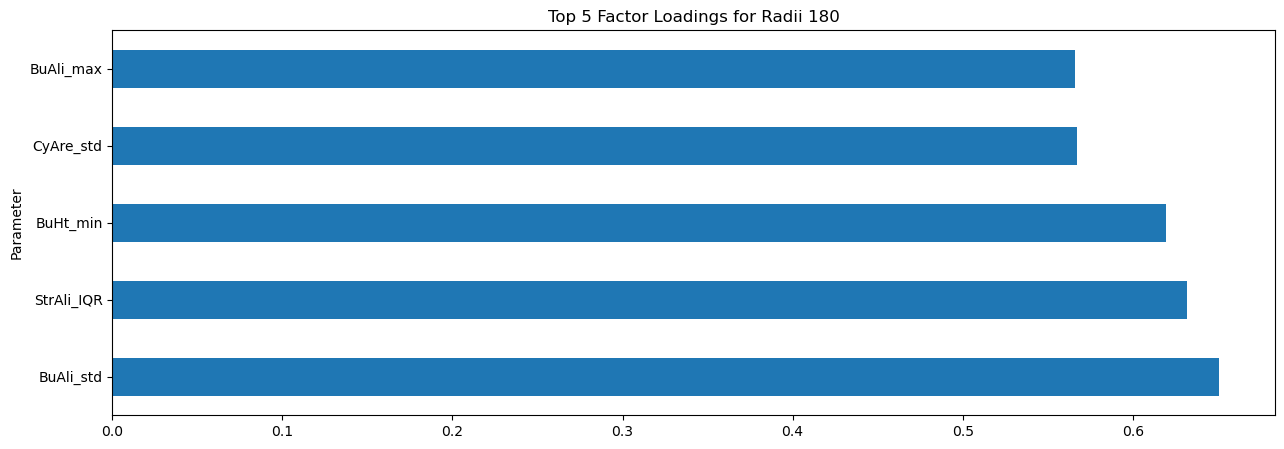

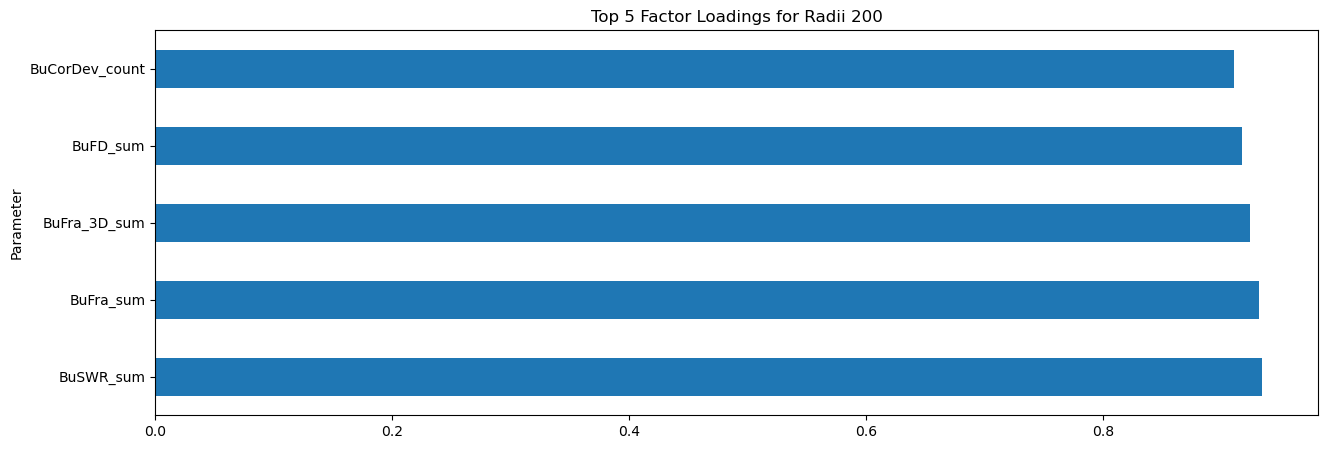

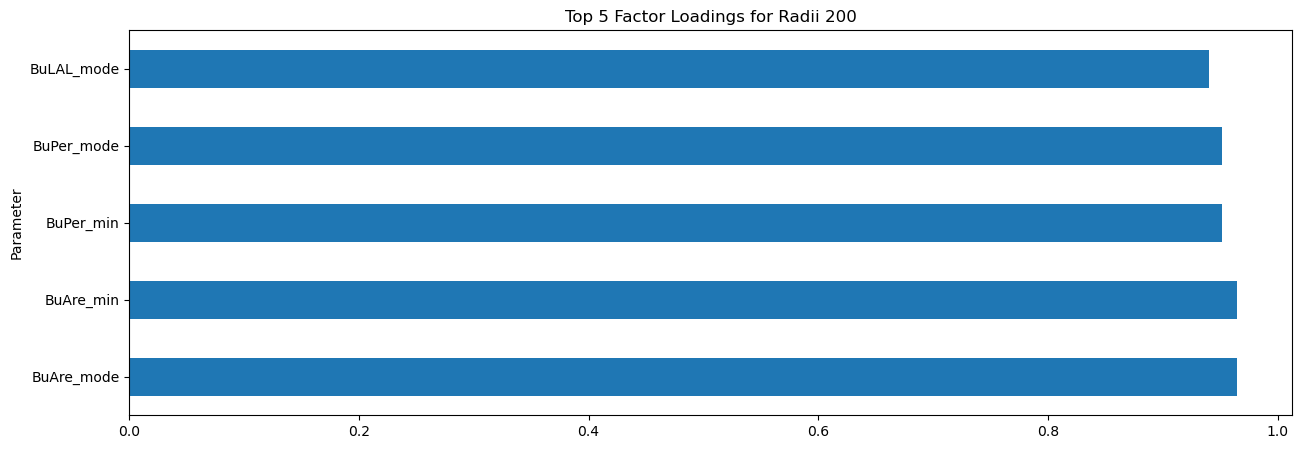

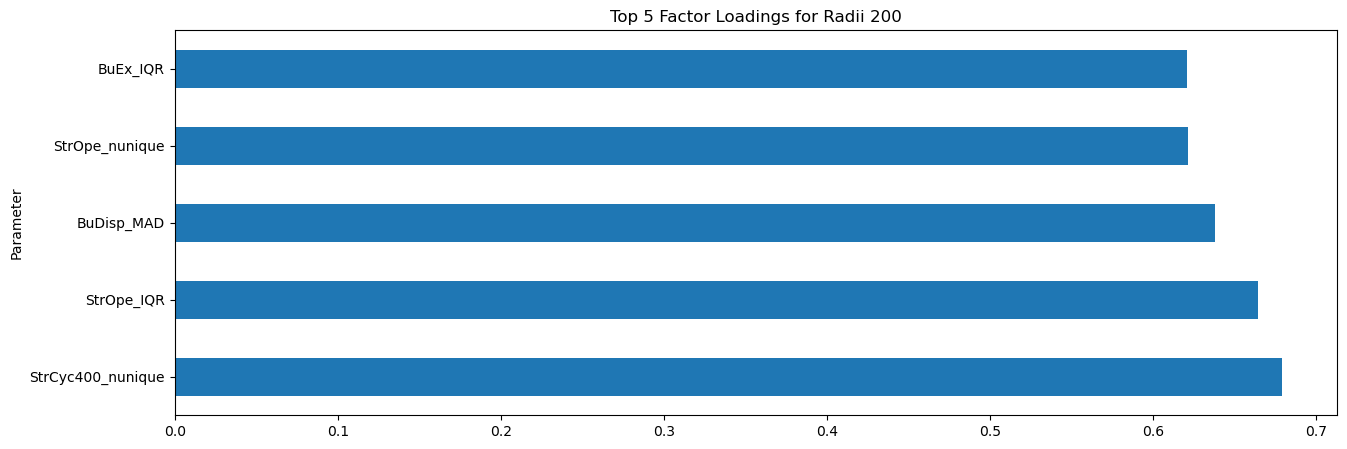

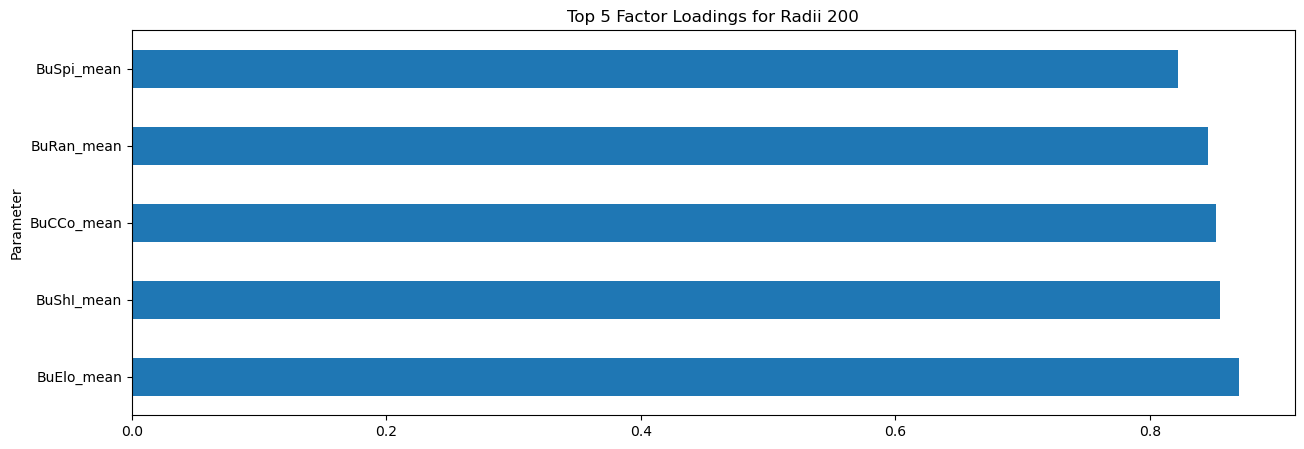

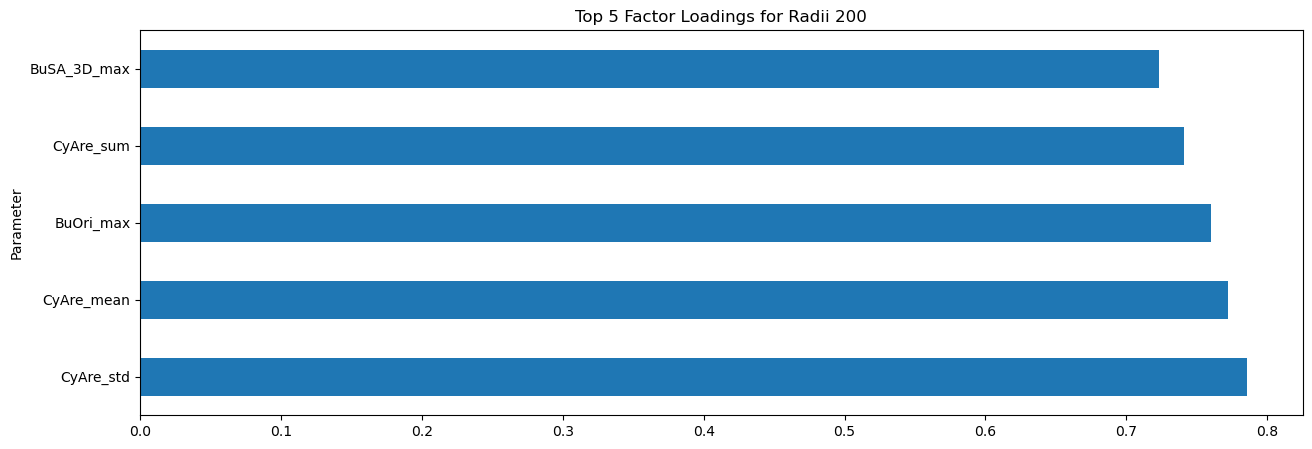

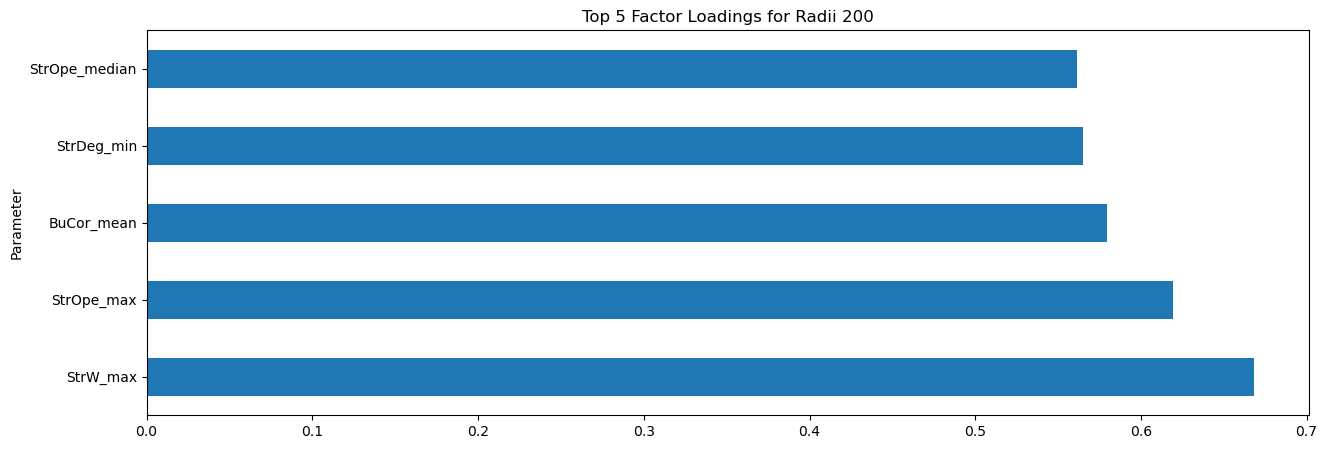

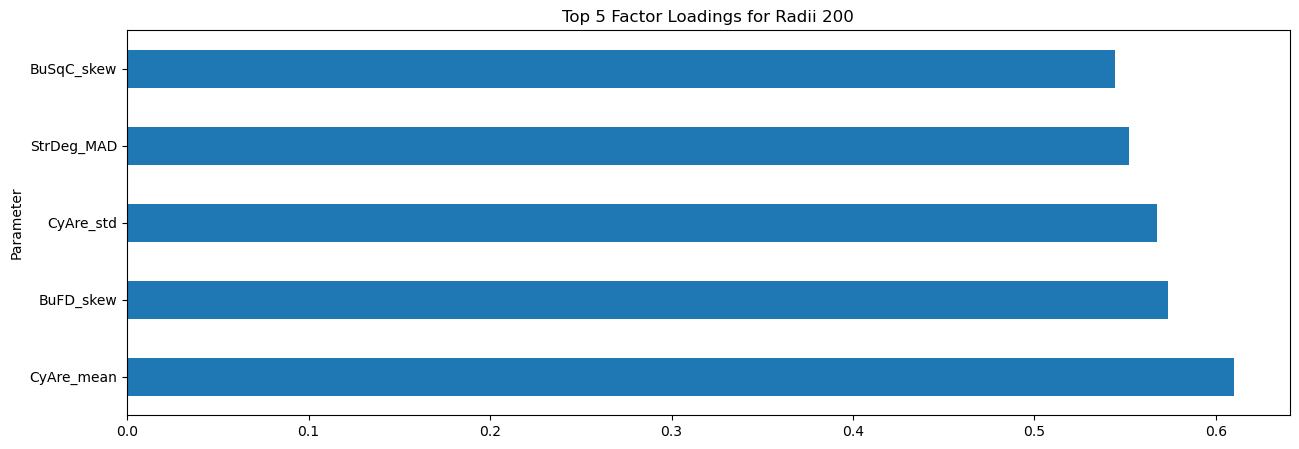

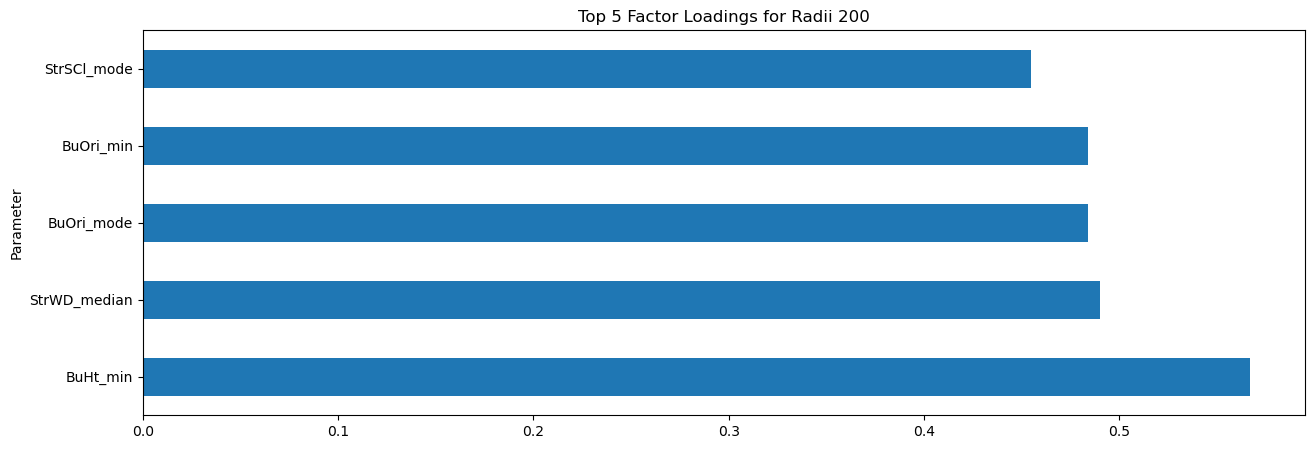

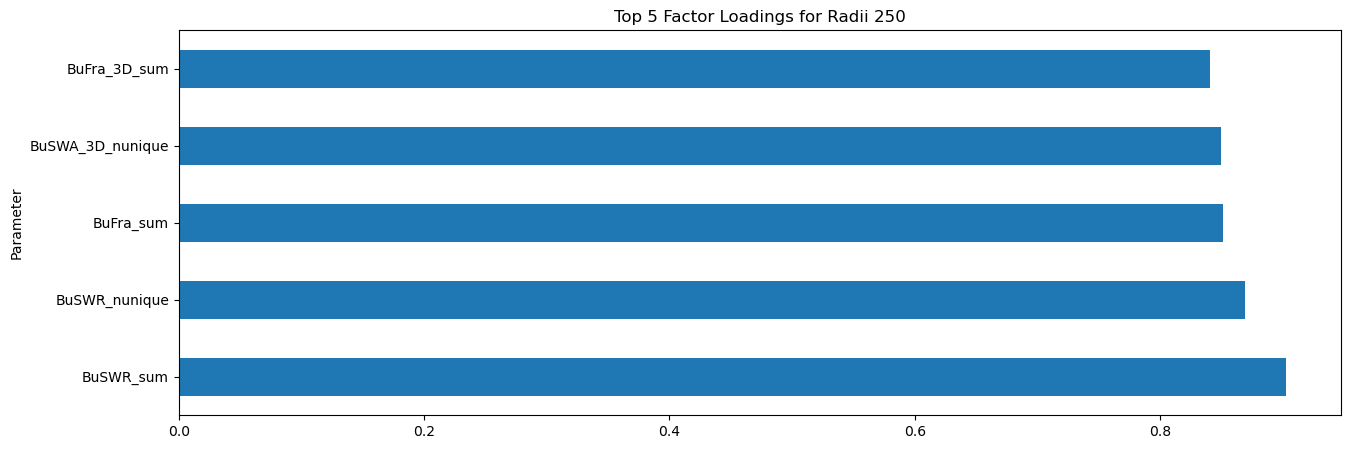

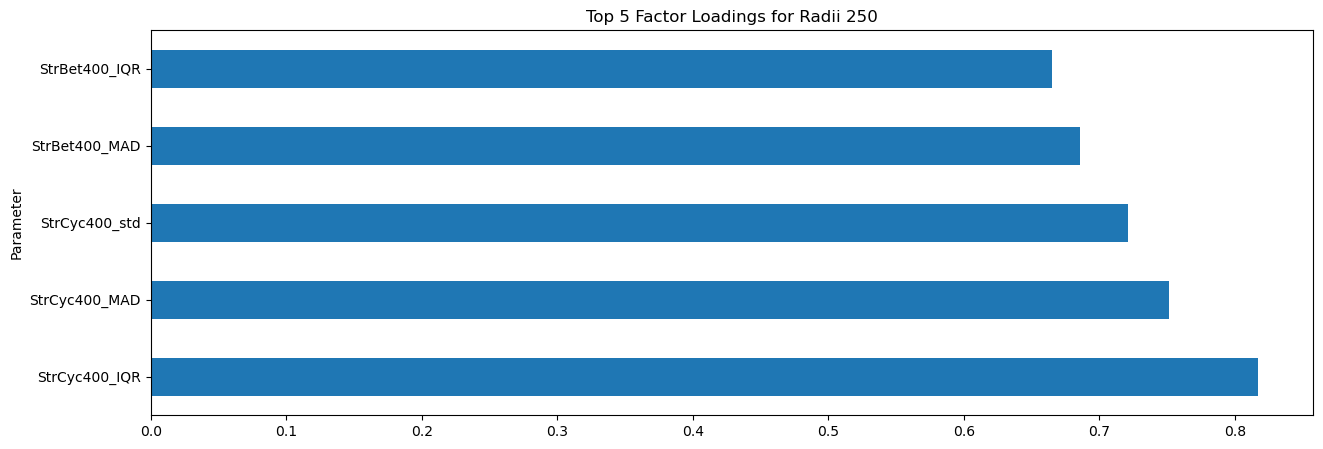

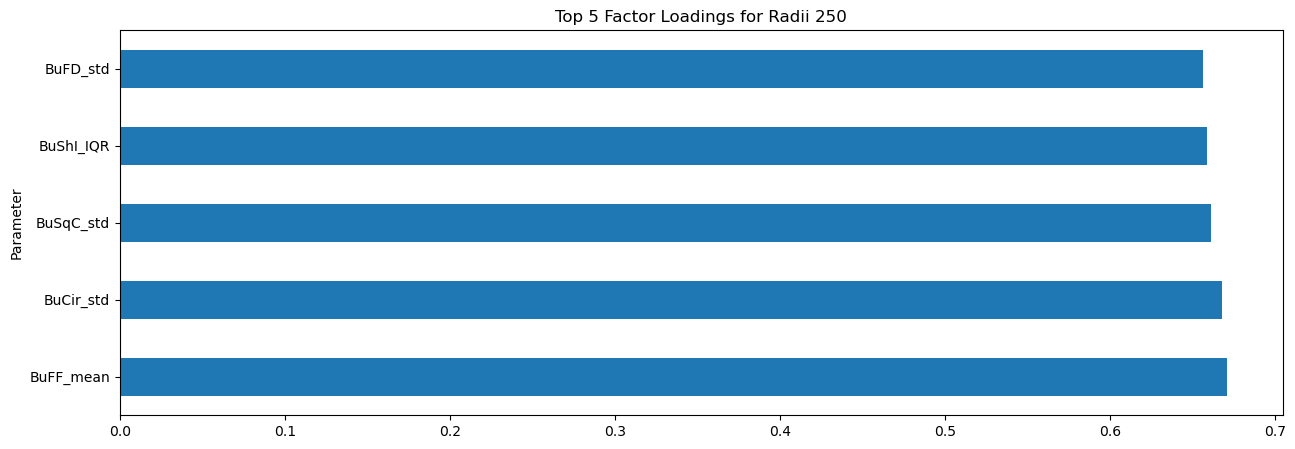

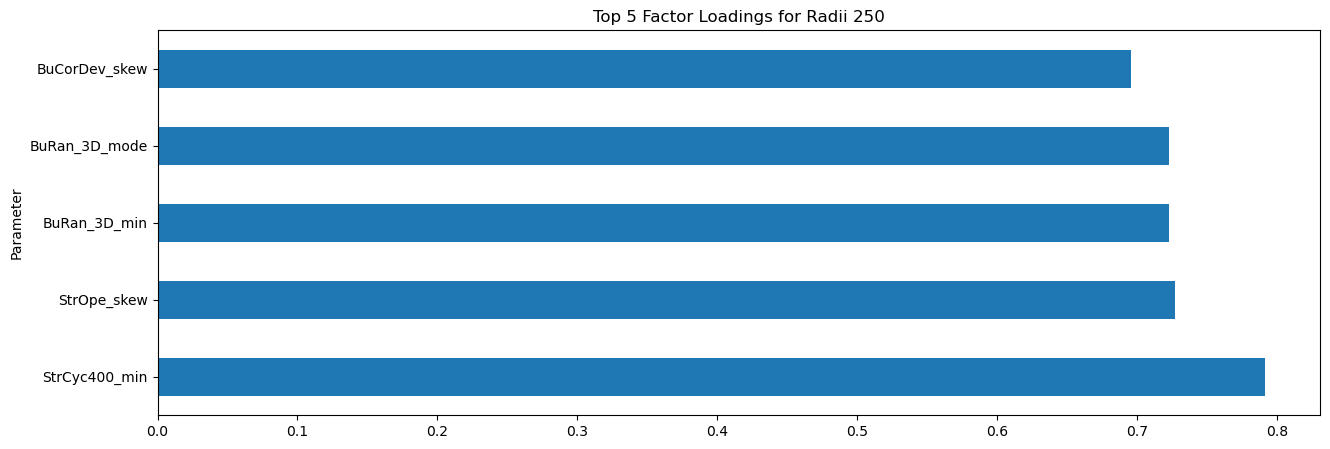

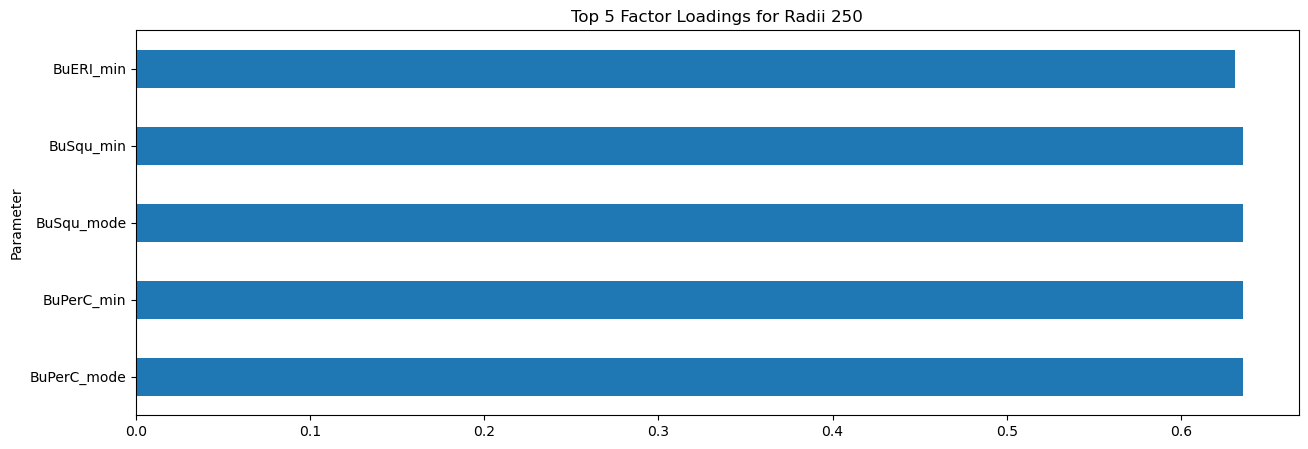

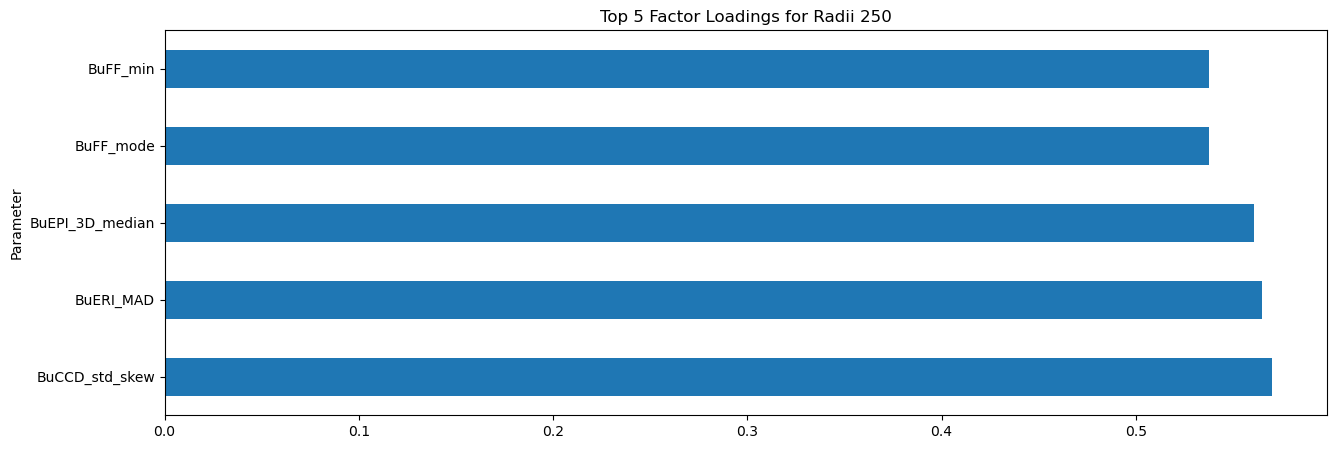

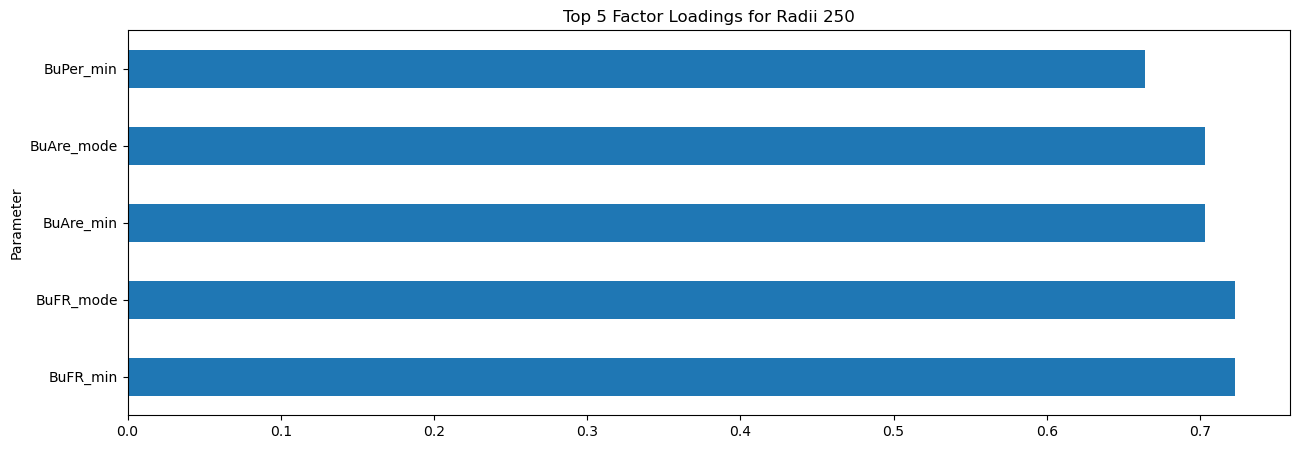

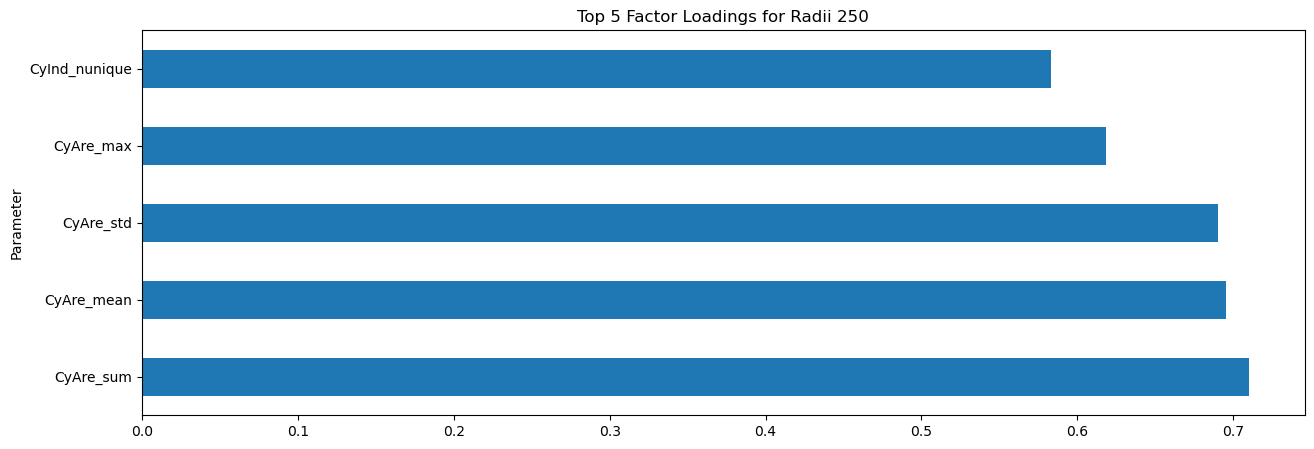

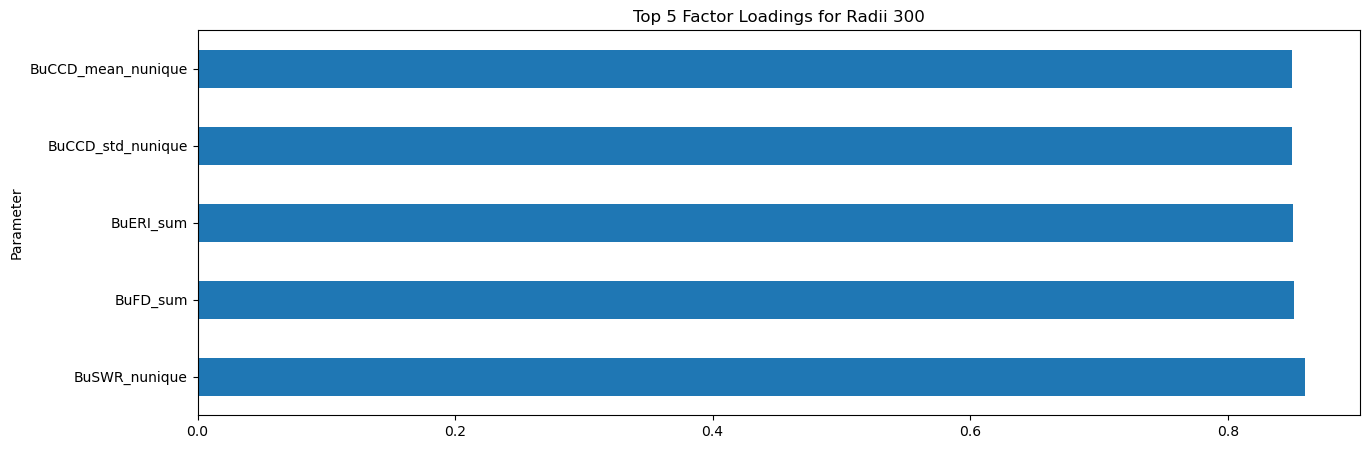

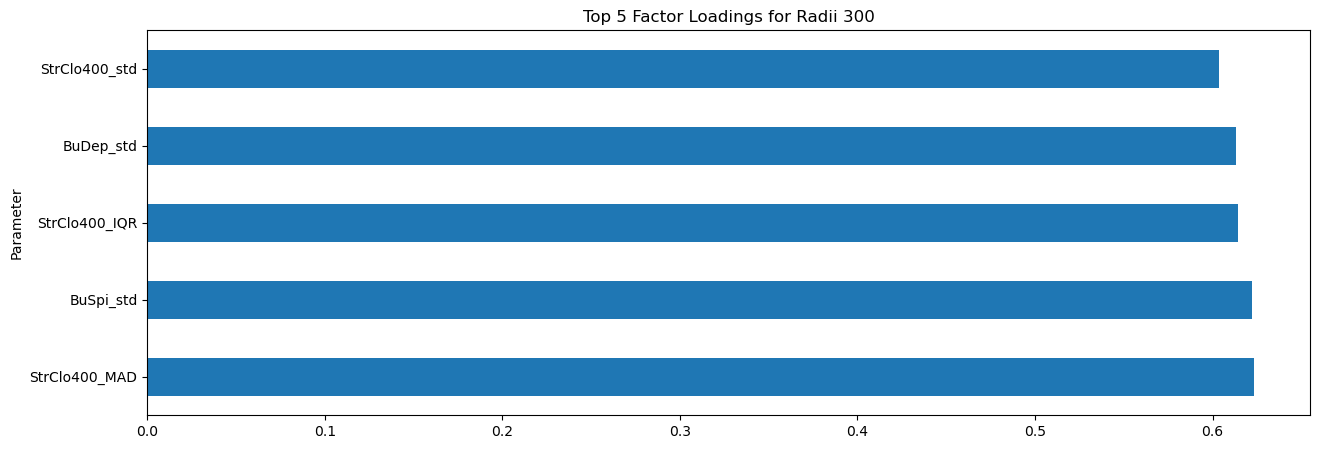

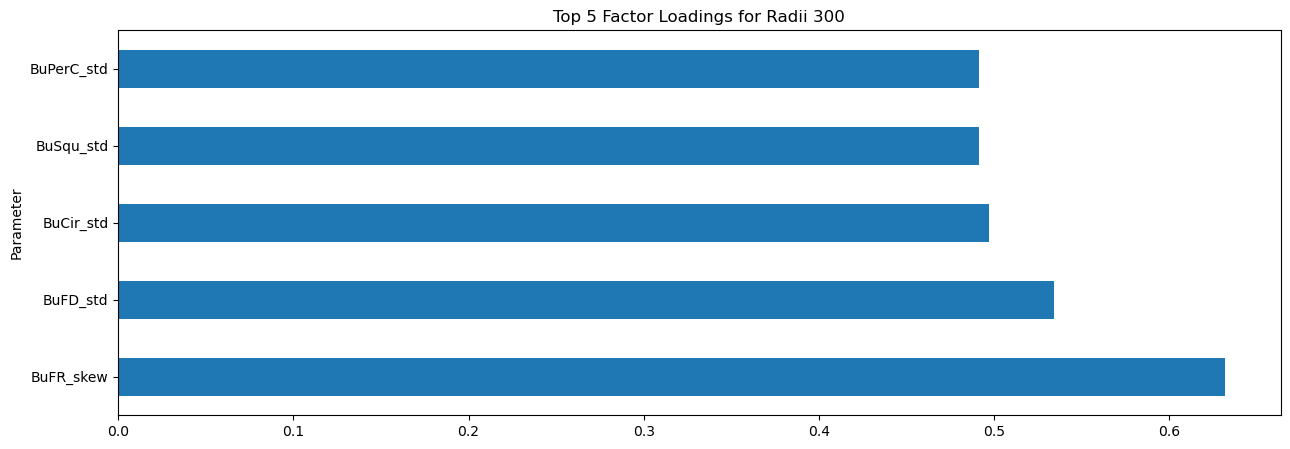

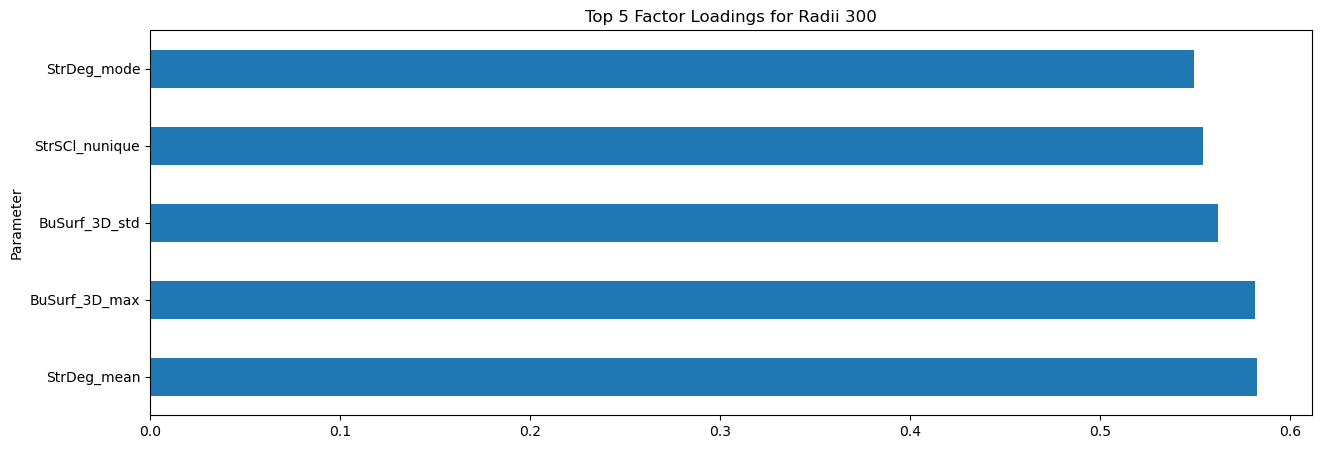

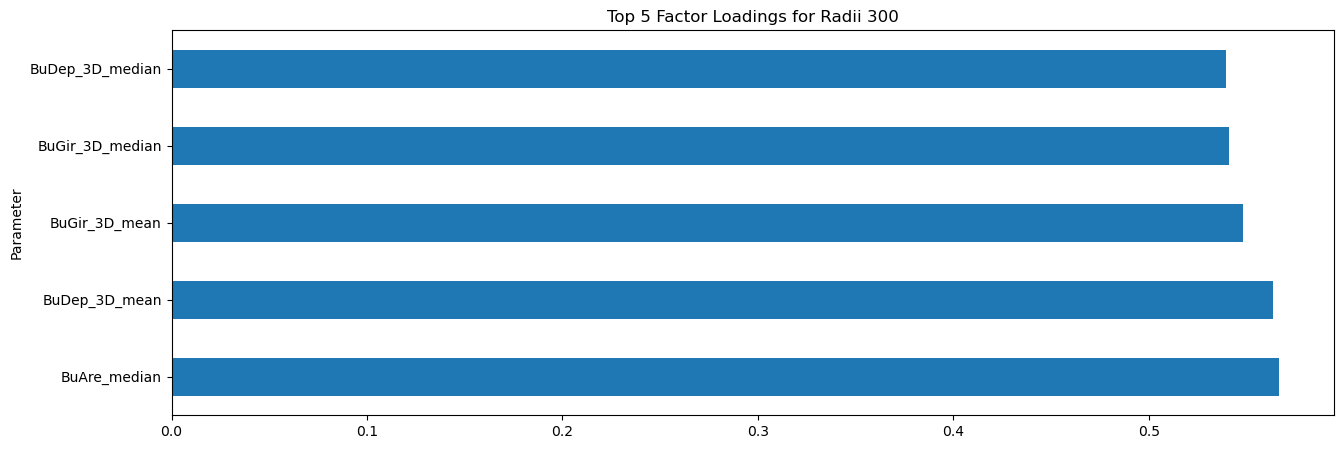

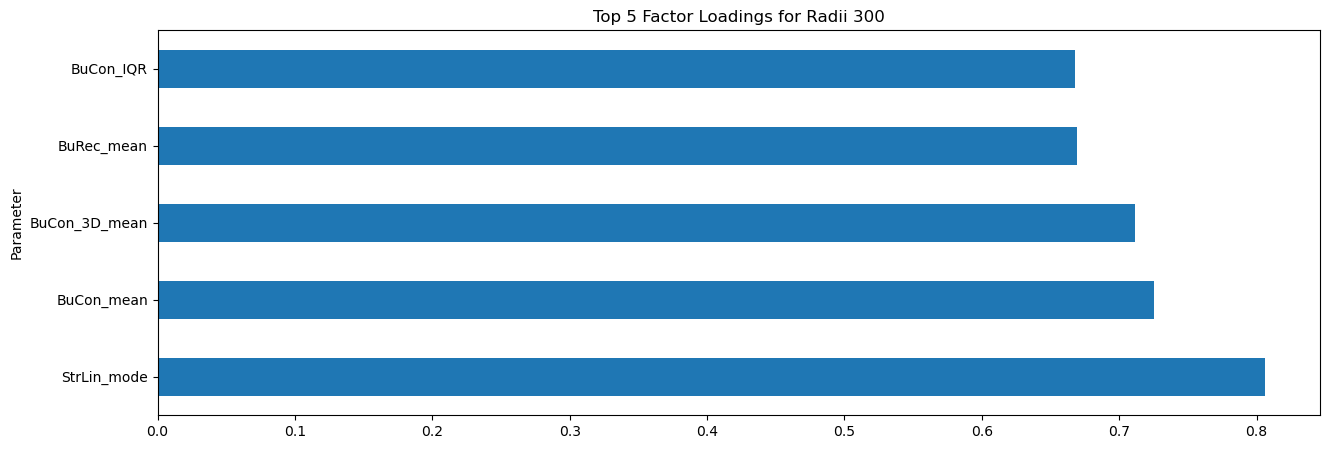

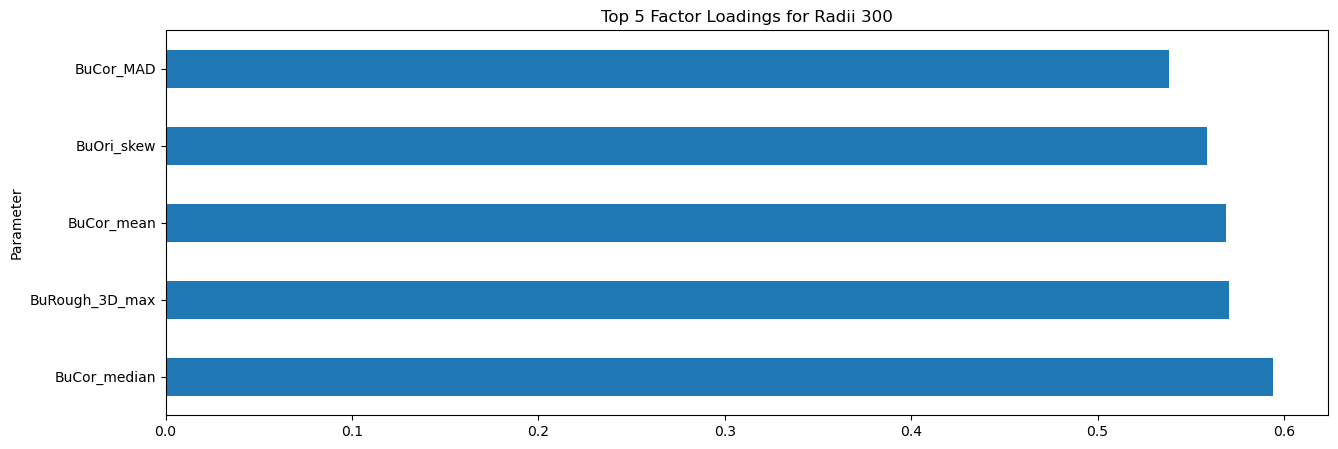

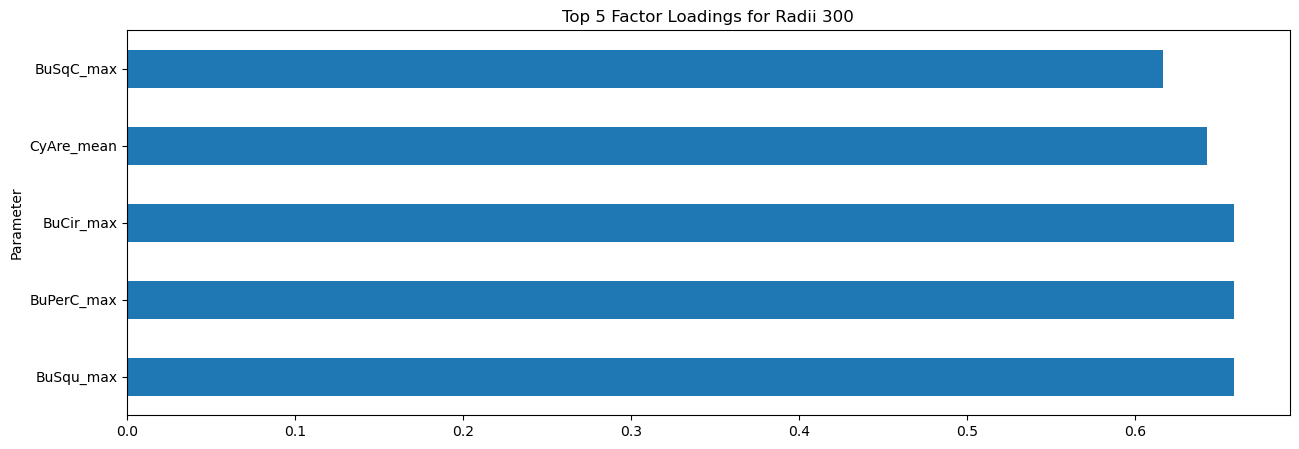

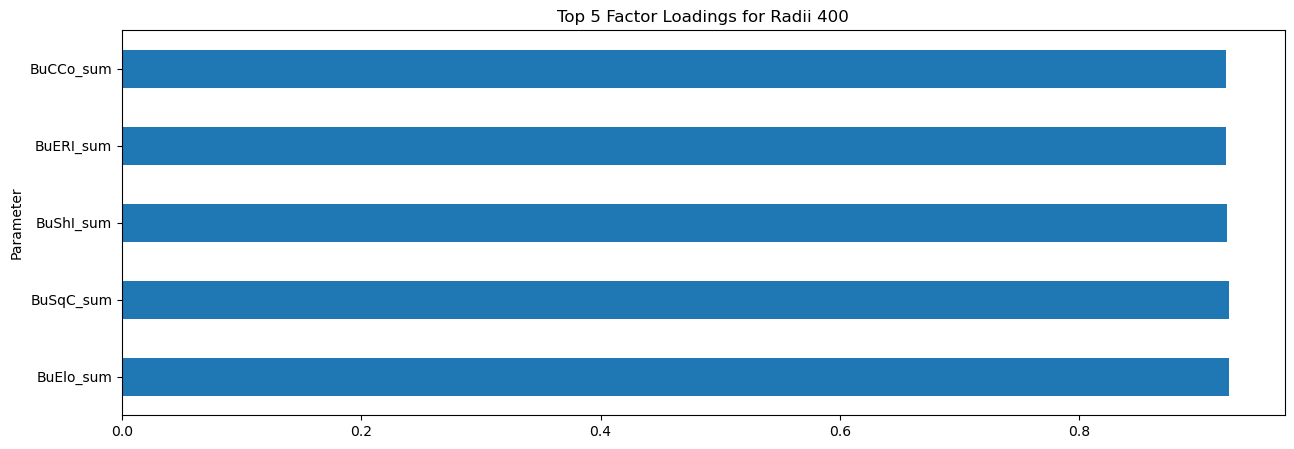

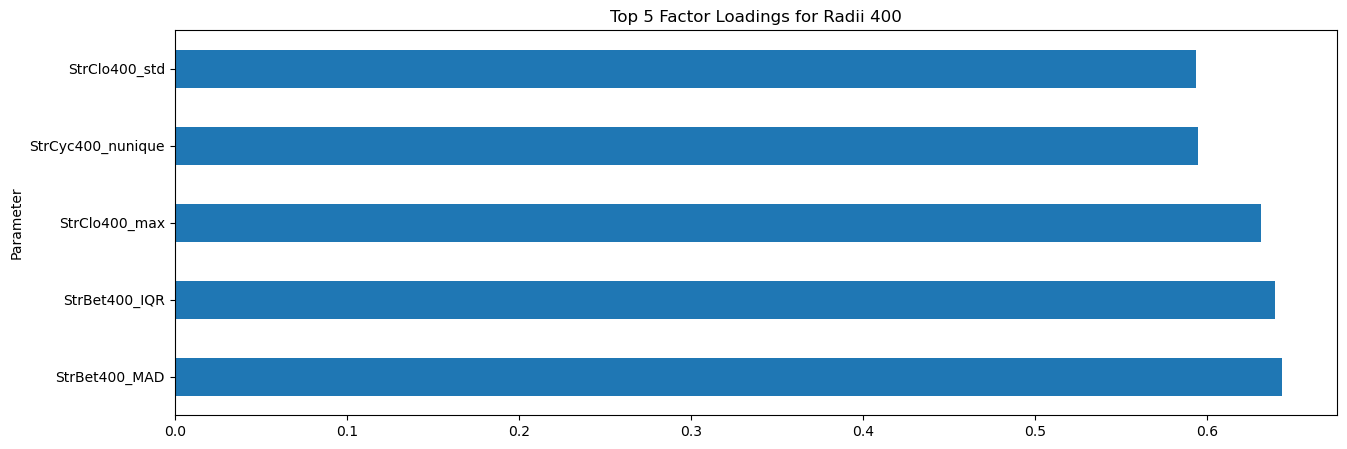

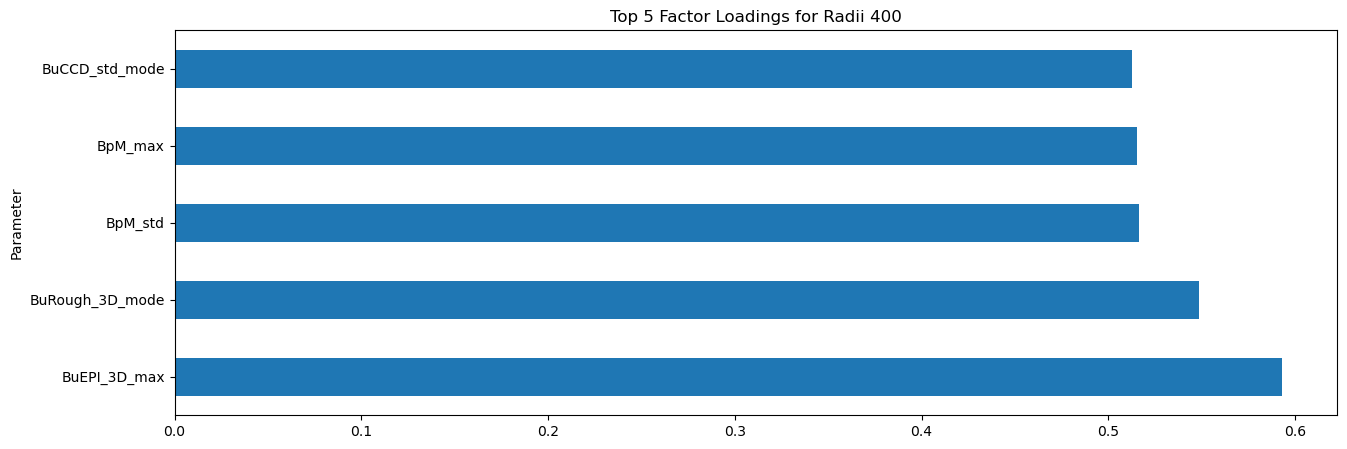

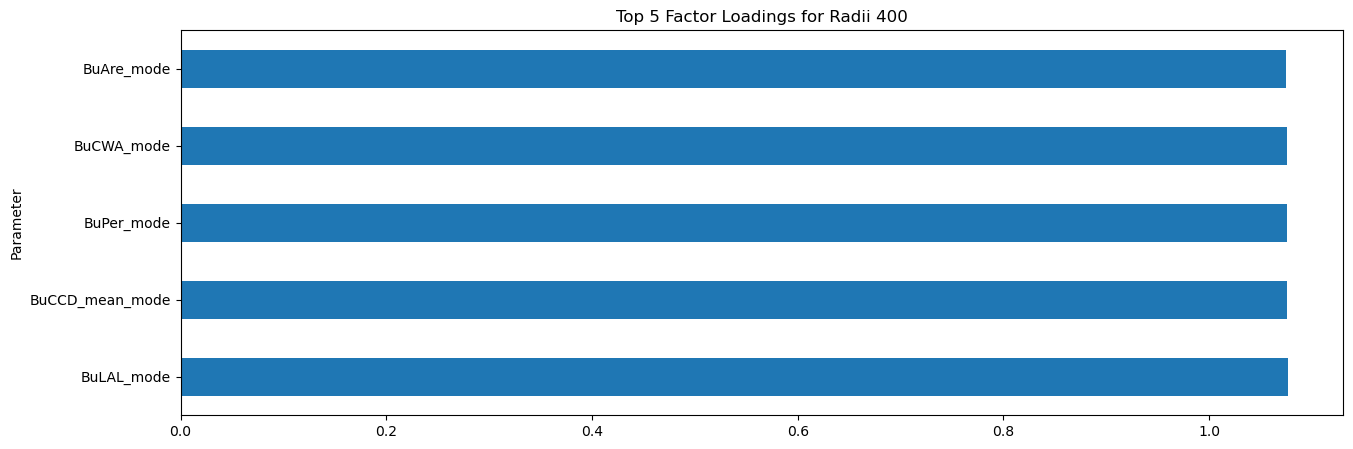

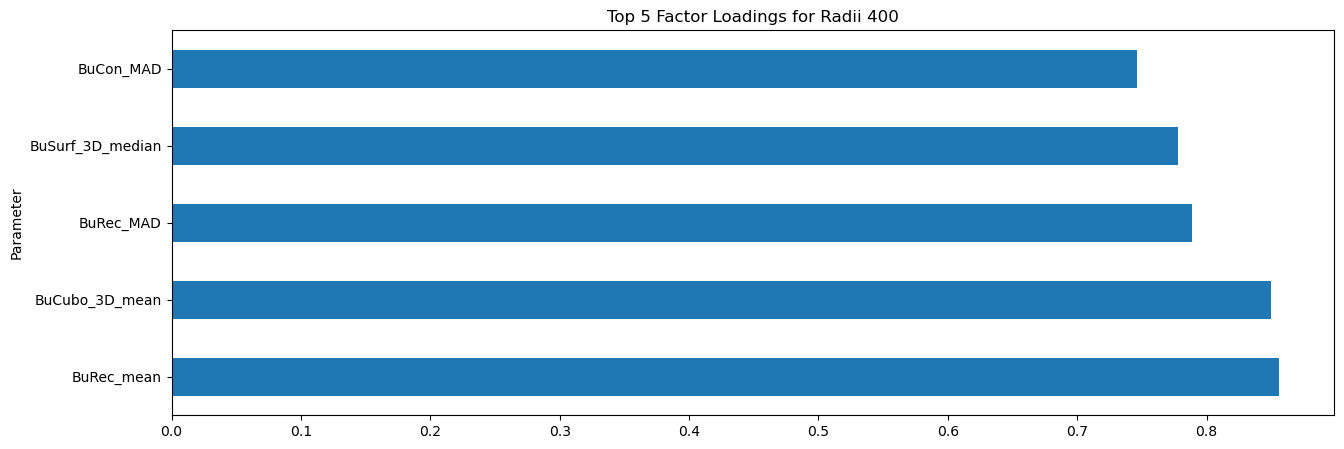

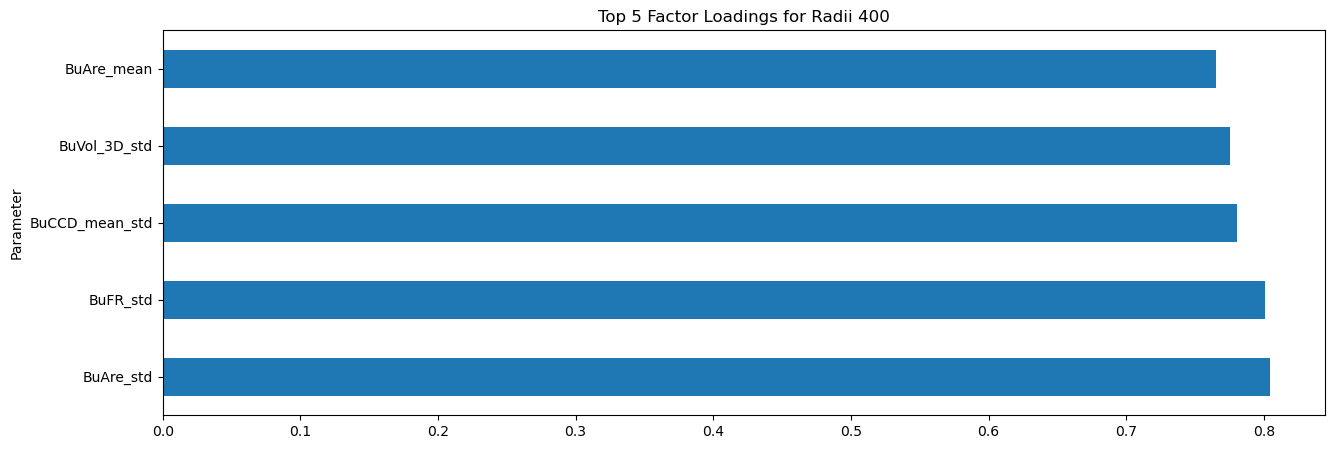

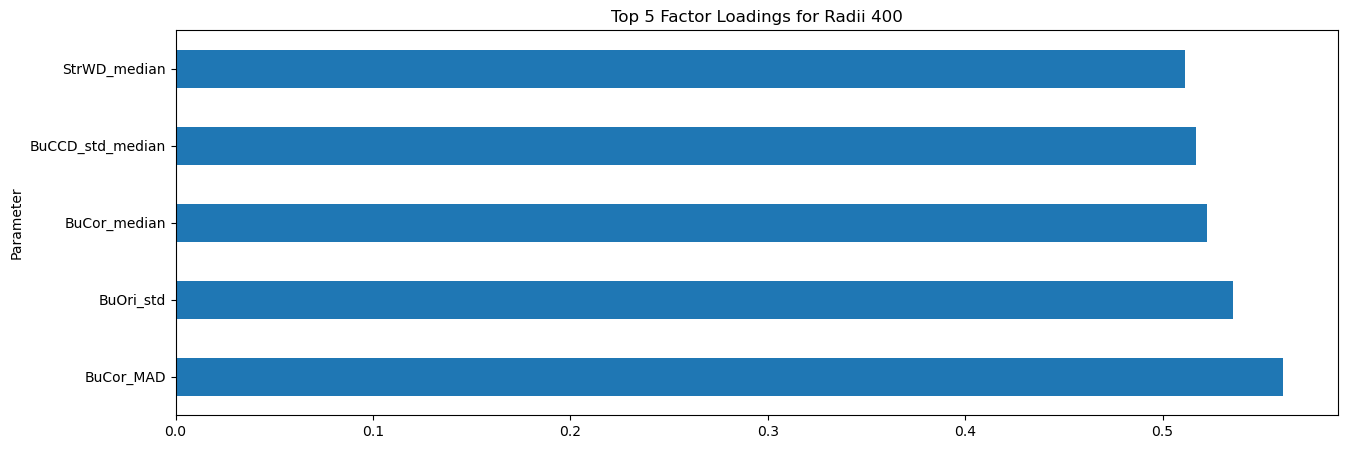

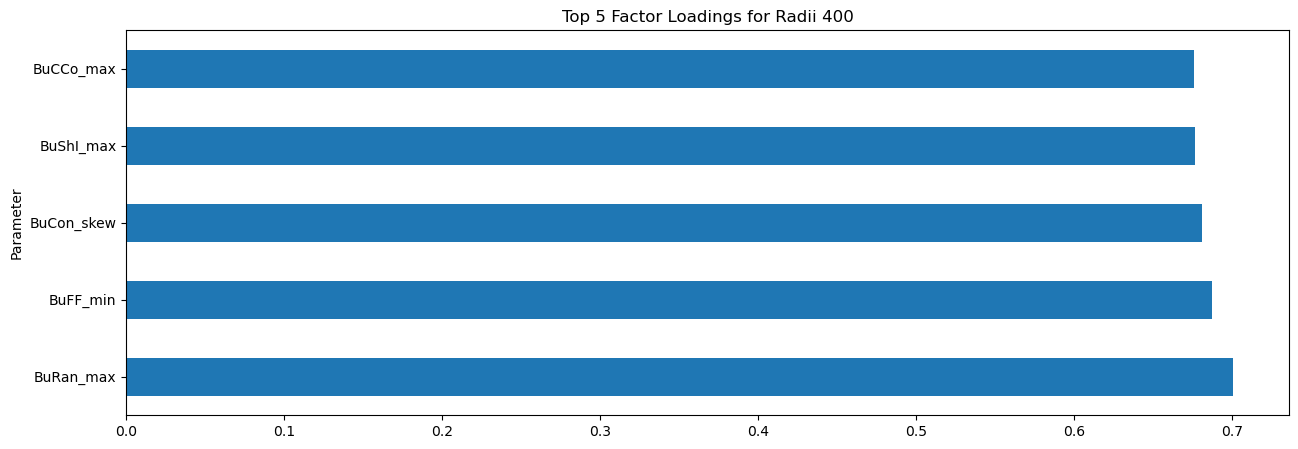

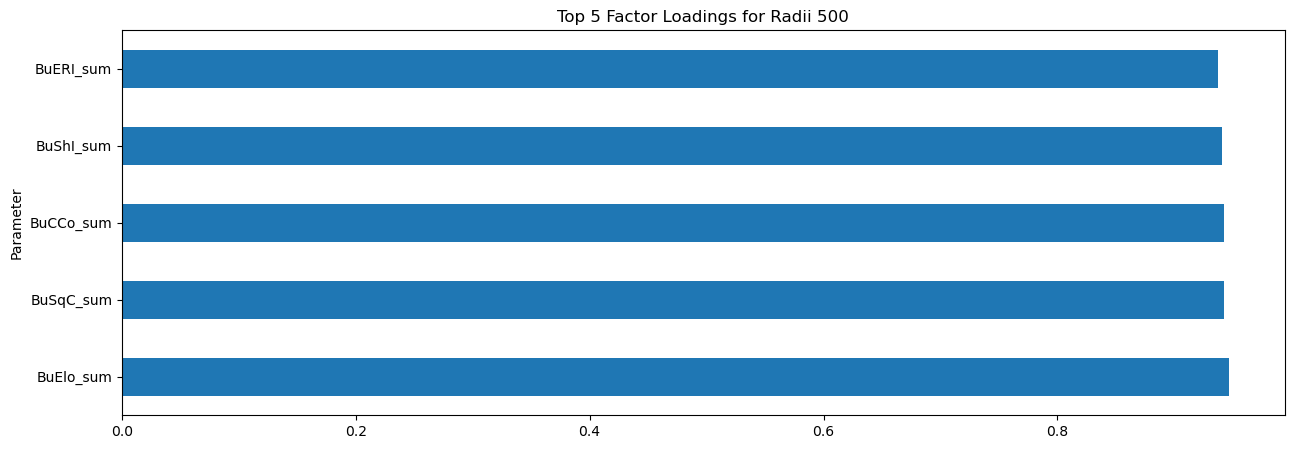

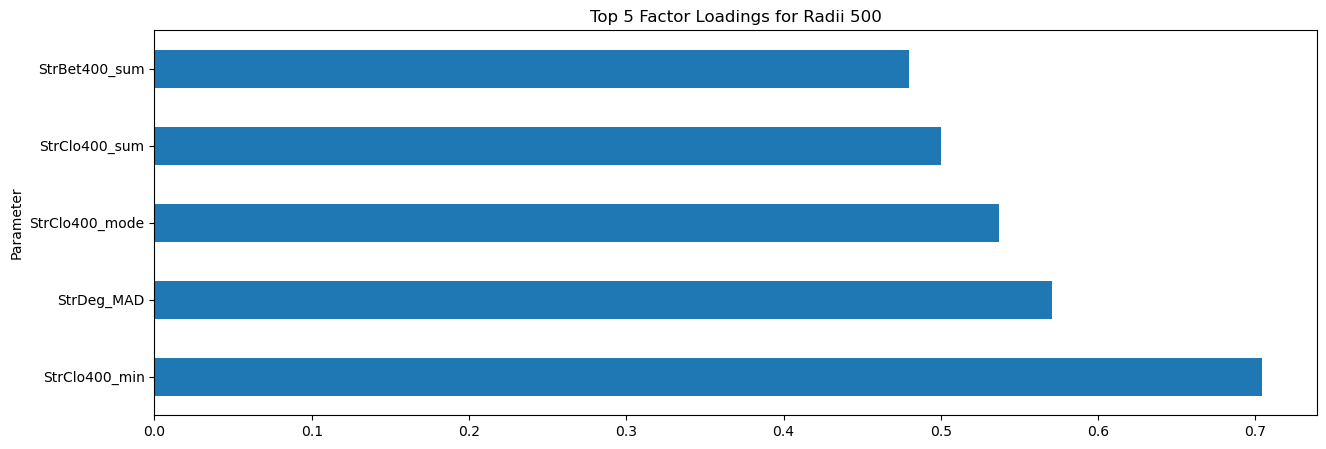

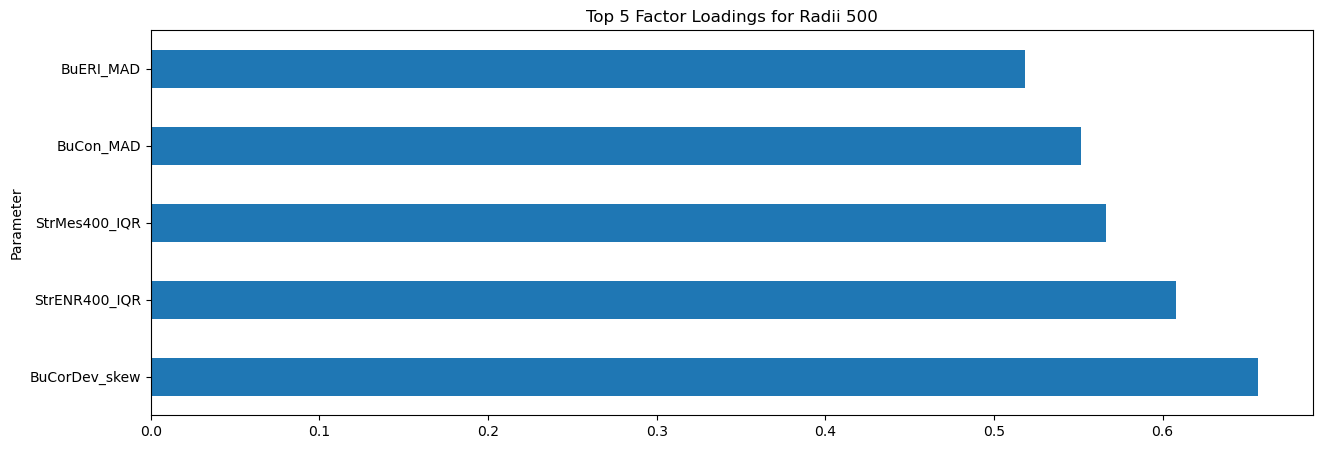

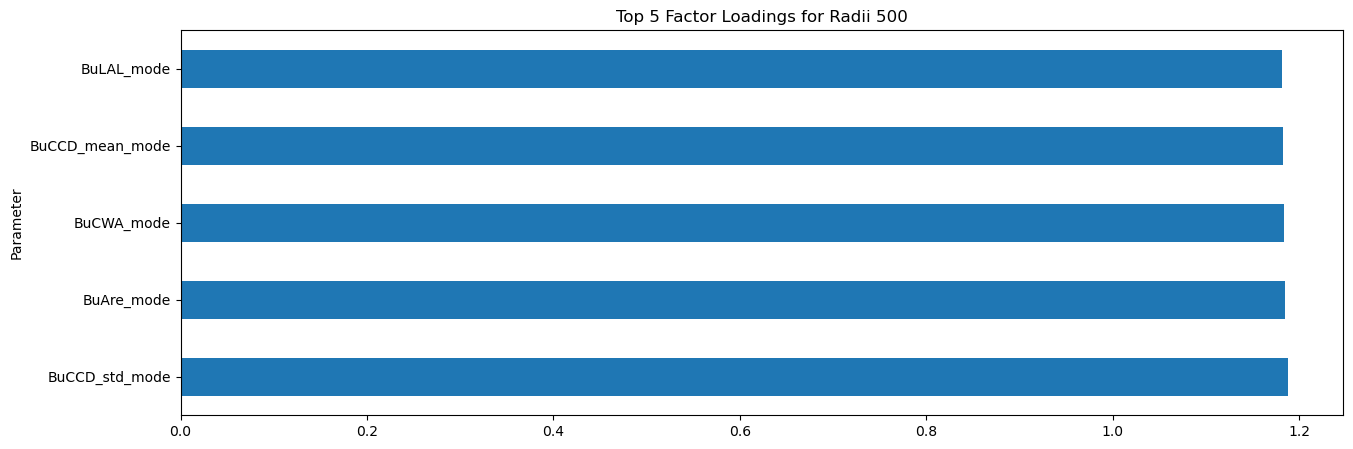

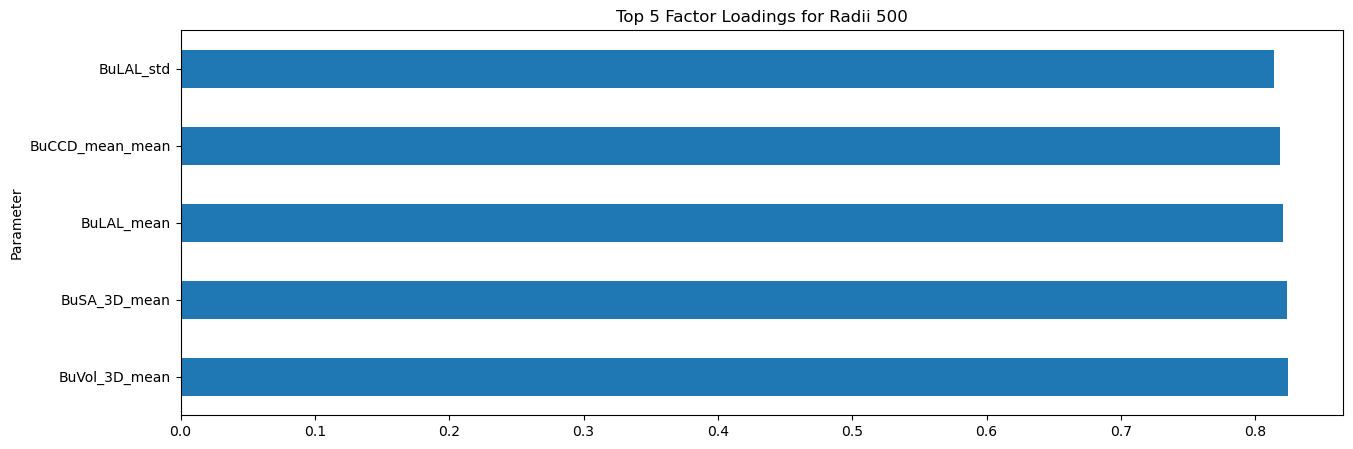

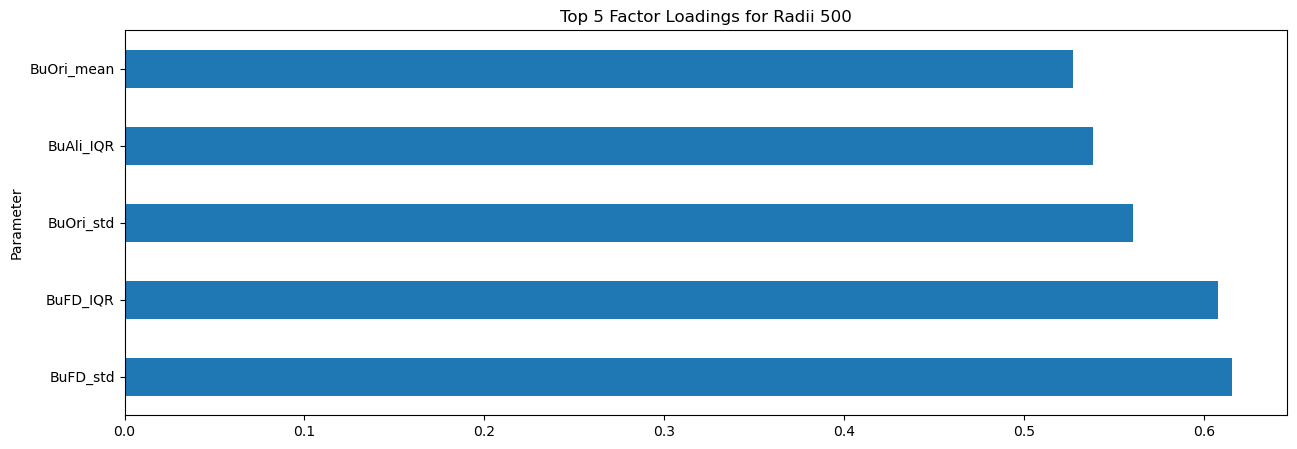

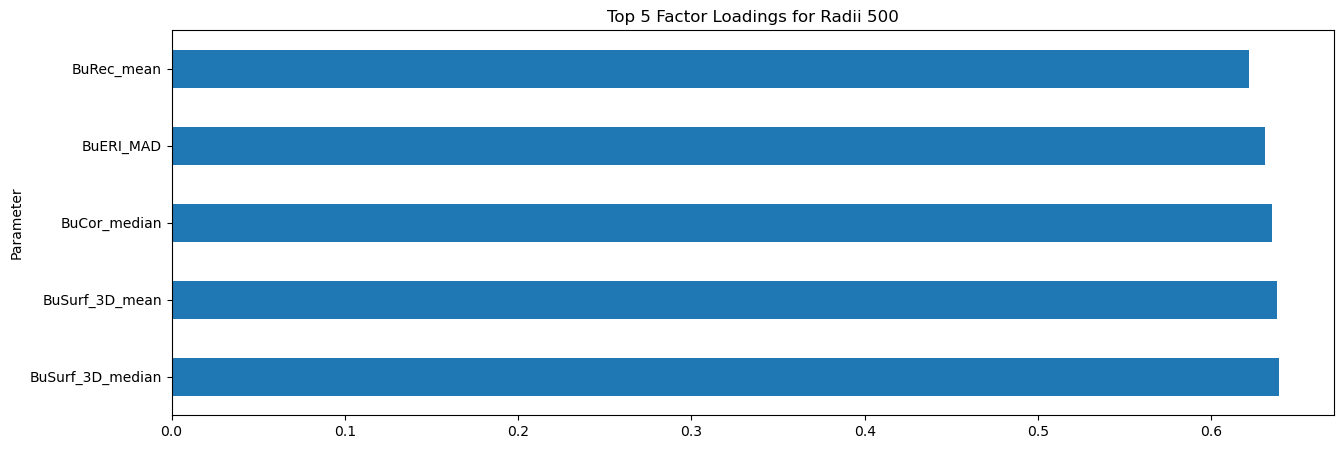

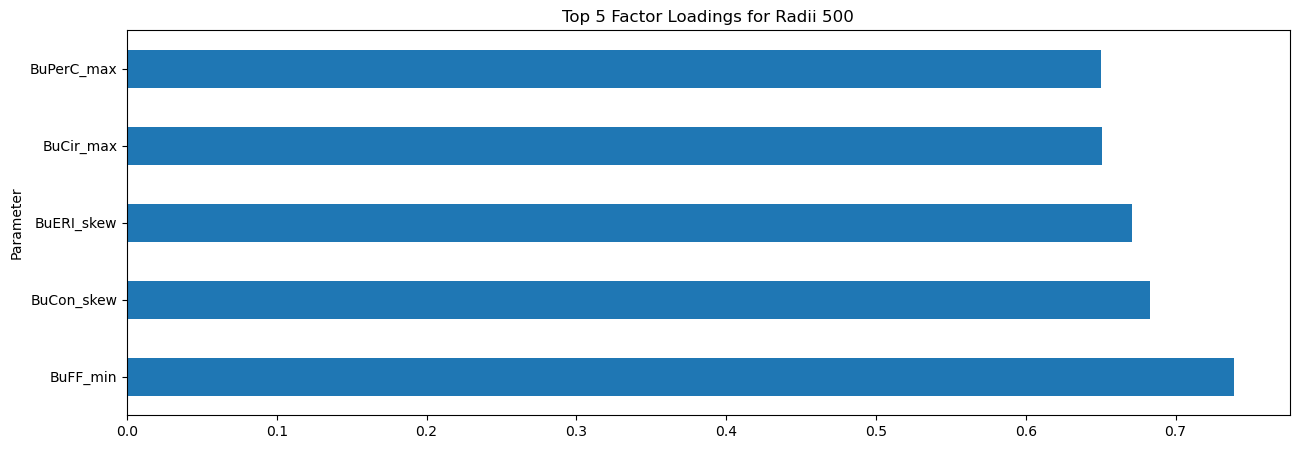

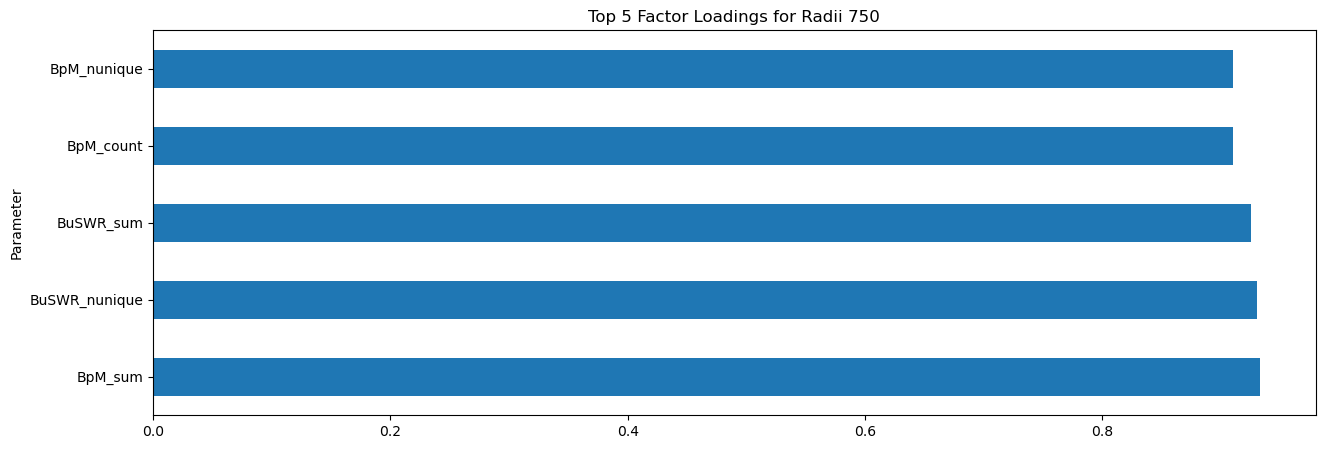

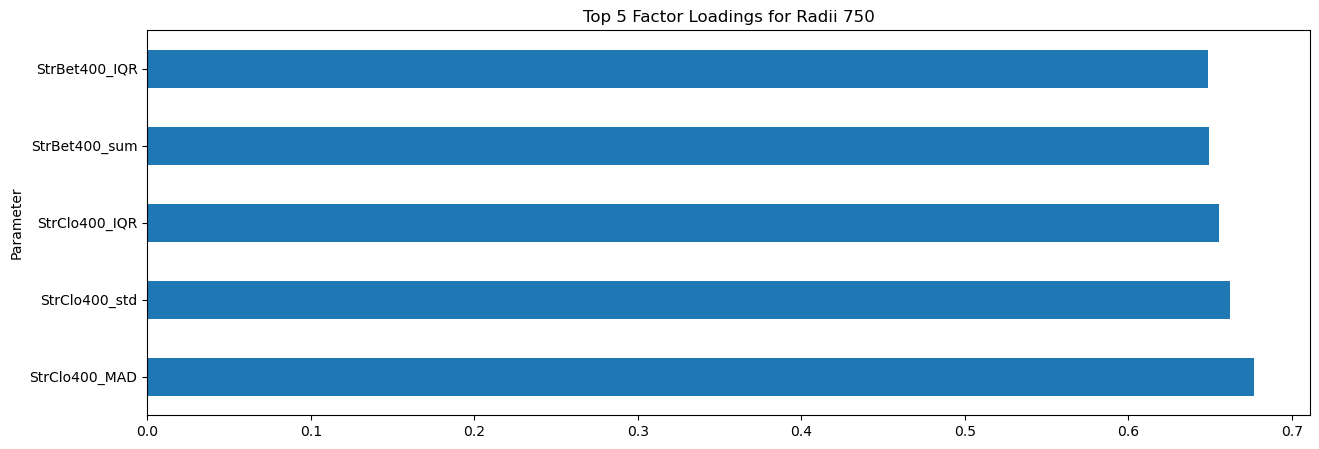

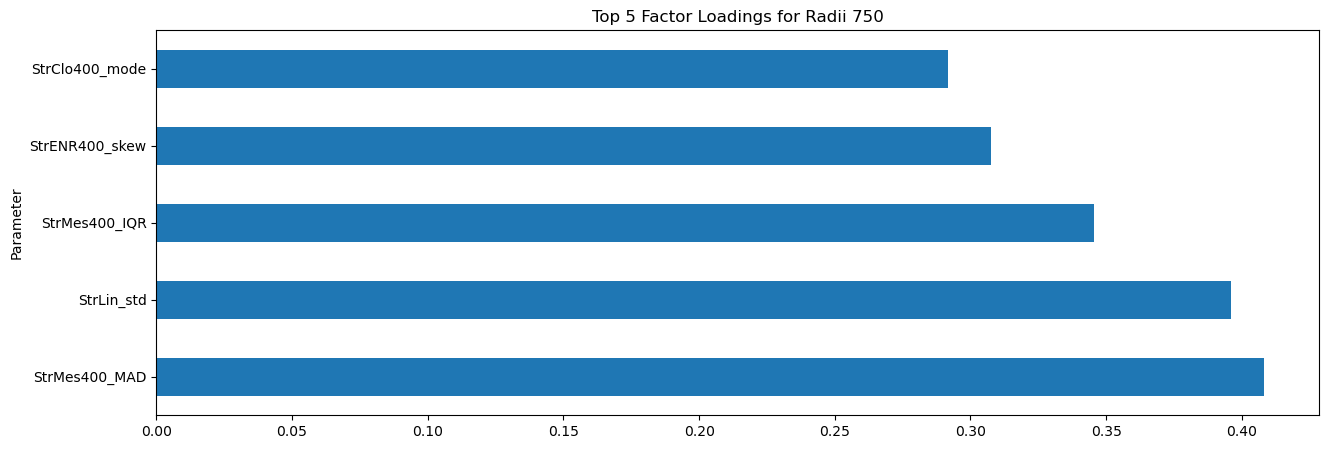

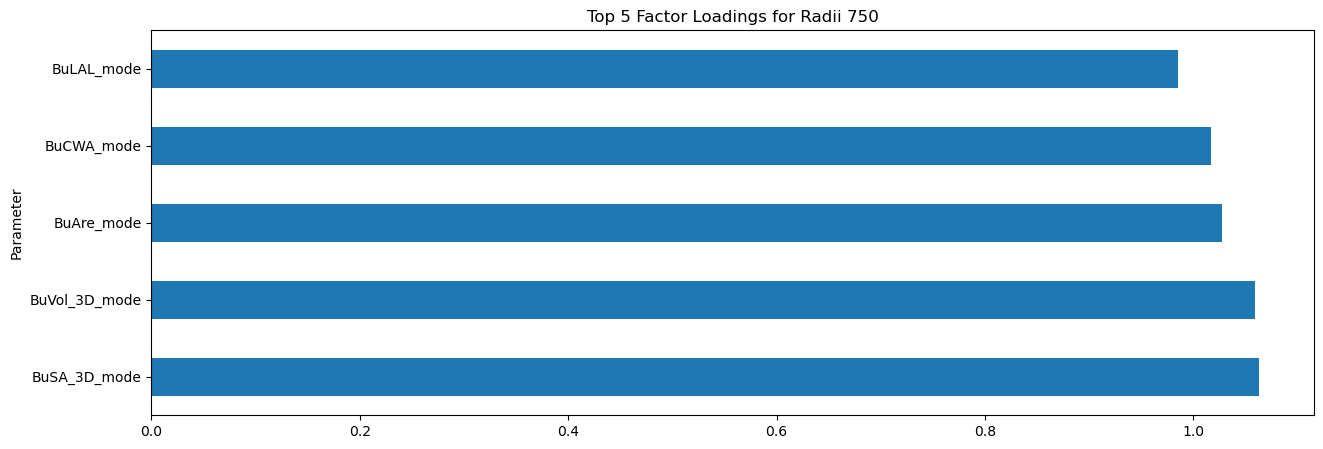

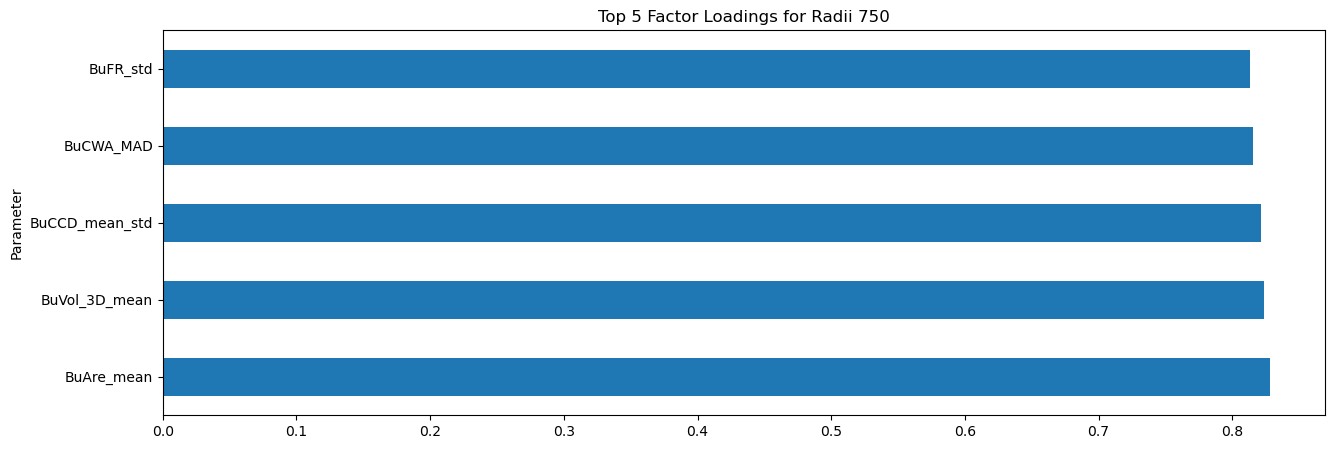

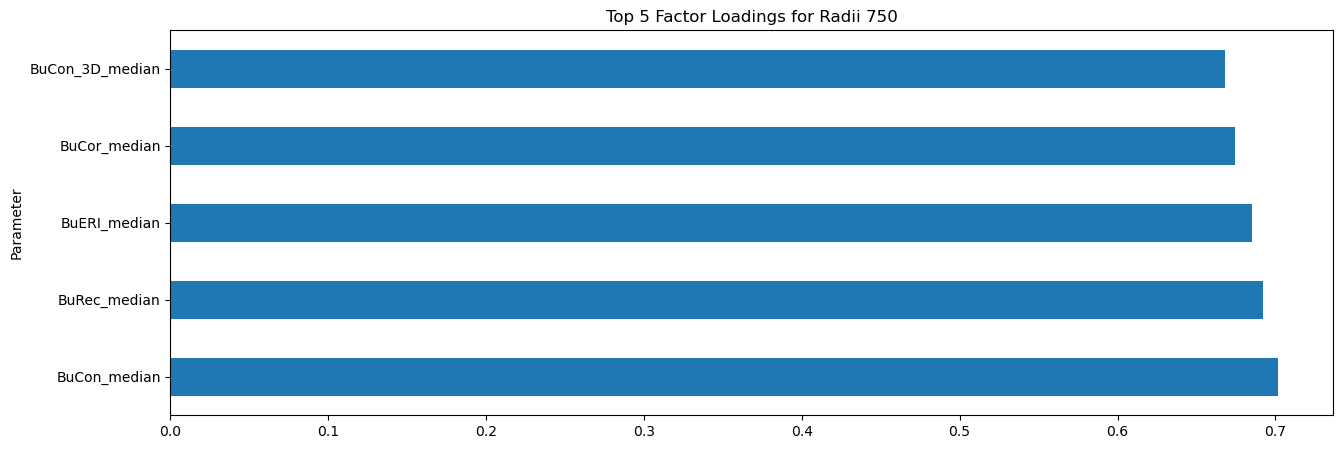

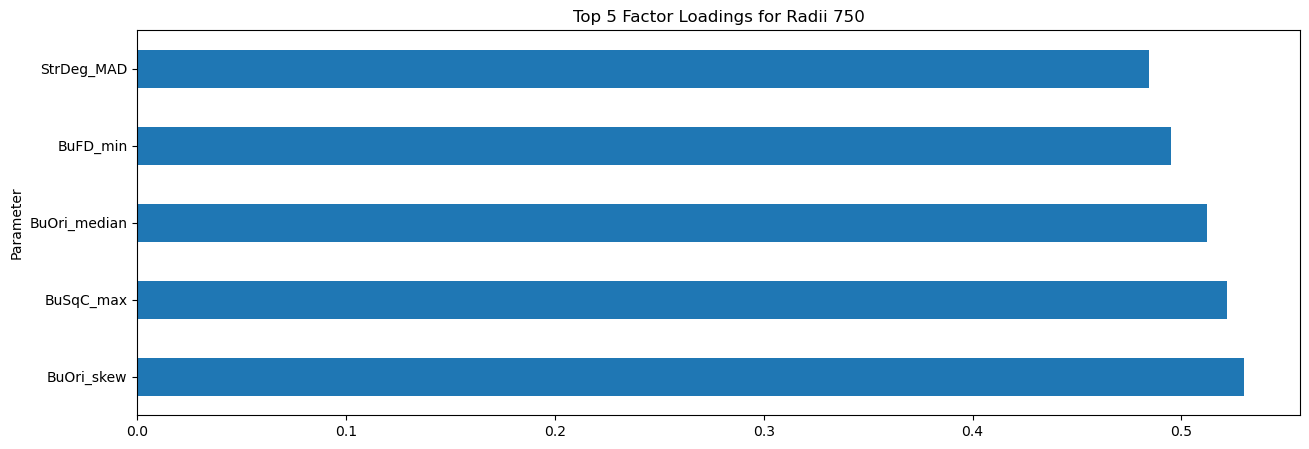

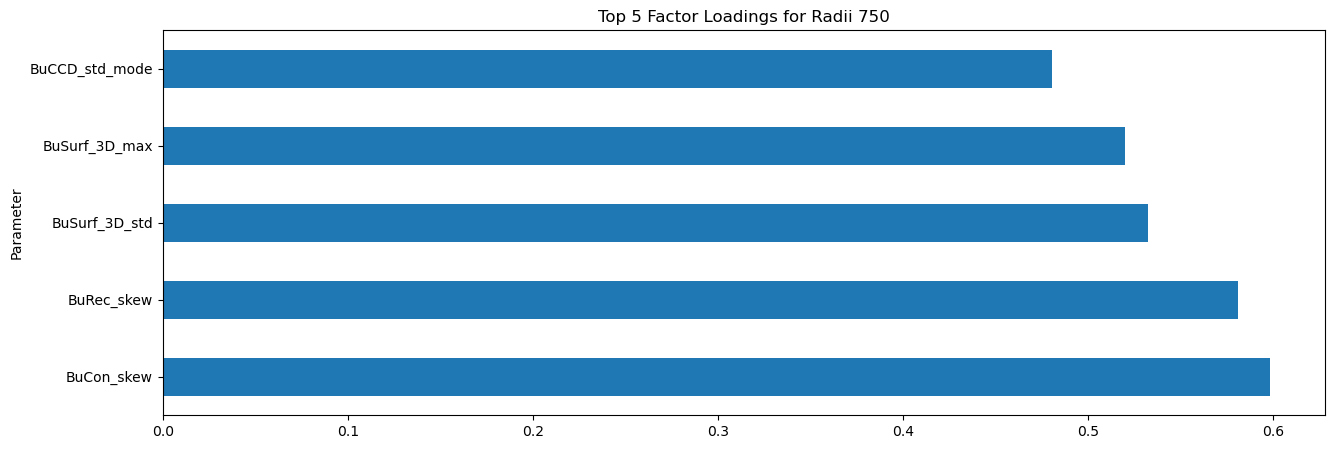

In [36]:
# plot bar chart of top 5 factors for each radii

radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]

for i in radii:
    for j in range(1,9):
        fa_scales[i].abs().sort_values(by=f"Factor {j}", ascending=False).head(5)[f"Factor {j}"].plot(kind='barh', figsize=(15, 5), title=f"Top 5 Factor Loadings for Radii {i}")
        plt.show()

In [ ]:
# plot bar chart
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
    

In [ ]:
# for each factor, print the top 5 highest loadings
factor_loadings_abs = factor_loadings.abs()

for i in range(n_factors):
    print(factor_loadings_abs.nlargest(5, f'Factor {i+1}'))
